In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow-gpu==2.0.0

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
import random
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from skopt import gp_minimize #貝氏優化
from skopt.space import Real, Integer
from skopt.utils import use_named_args

print(tf.__version__)

2.0.0


In [2]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

In [5]:
#location = 'E:/咪聽/SVDD/deep SVDD/checkpoints/'
location = 'D:/svdd/checkpoint/SASVDD'

## pretrain

In [6]:
img_size = 28
flatten_size = img_size * img_size 
z_dim = 32
h_dim = [8, 4]

In [7]:
class Autoencoder():
    
    def __init__(self, label_num, img_size = 28, z_dim = 32, h_dim = [8, 4]):
        
        self.label_num = label_num
        self.img_size = img_size
        self.flatten_size = img_size * img_size
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.ae_optimizer = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.5e-3)
        

    def make_encoder(self):

        inputs = tf.keras.Input(shape=(self.flatten_size,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, self.img_size, self.img_size, 1))
        x = tf.keras.layers.Conv2D(self.h_dim[0], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(self.h_dim[1], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Flatten(name = 'Flatten')(x)    
        x = tf.keras.layers.Dense(self.z_dim, use_bias = False, name = 'dense')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model    
   
    def make_decoder(self):

        inputs = tf.keras.Input(shape=(self.z_dim,), name='inputs')
        x = tf.keras.layers.Dense(self.h_dim[1] * 7 * 7,  use_bias = False)(inputs)
        x = tf.reshape(x, shape = (-1, 7, 7, self.h_dim[1]))
        x = tf.keras.layers.LeakyReLU()(x)
        #x = tf.keras.layers.UpSampling2D((2, 2))(x)    

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[1], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)   

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[0], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x) 

        x = tf.keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same',  use_bias = False)(x)

        x = tf.reshape(x, shape = (-1, self.flatten_size))
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model   
    
    @tf.function
    def train_ae_model(self, batch_x):
        with tf.GradientTape() as ae_tape:
            ae_output = self.decoder(self.encoder(batch_x, training=True), training=True)
            loss = tf.reduce_mean((ae_output - batch_x) ** 2)

        grads = ae_tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        return loss
    
    def train_ae( self, n_ae_epochs, train_dataset, ae_lr_milestone = 50):
        #loss_list = []
        for epoch in range(n_ae_epochs):
            epoch_ae_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % ae_lr_milestone == 0:
                self.ae_optimizer.lr = 0.1 * self.ae_optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):

                ae_loss = self.train_ae_model(batch_x)
                #epoch_ae_loss_avg(ae_loss)
            #loss_list.append(epoch_ae_loss_avg.result())
        
        self.encoder.save_weights('D:/7107018014/checkpoint/revist_deepSVDD/oneclassAE_label_{}' .format(self.label_num))
        #print('LOSS: {:.4f} '.format(epoch_ae_loss_avg.result()))
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        

## training data

In [8]:
def load_data(label_num, outlier_nu):

    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') /255.
    x_test = x_test.astype('float32') /255.
    
    random.seed (1120)
    normal_n = sum(y_train == label_num)
    outlier_n = sum(y_train != label_num)
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    
    x_train = np.vstack( (x_train[y_train==label_num], x_train[y_train!=label_num][indices]))
    y_train = np.hstack( (y_train[y_train==label_num], y_train[y_train!=label_num][indices]))

    # Flatten the dataset
    x_train = x_train.reshape((-1, 28 * 28))
    x_test = x_test.reshape((-1, 28 * 28))


    return  x_train, y_train, x_test, y_test

## 資料分割

In [9]:
def split_data(x_train, y_train, batch_size = 200):
    x_novali, x_vali, y_novali, y_vali = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
    
    
    n_samples = len(x_novali)
    train_dataset = tf.data.Dataset.from_tensor_slices(x_novali)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    
    validation_n = len(x_vali)
    
    return train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n

## SVDD 模型(encoder 初始值 + certer初始值)

In [10]:
class make_SVDD_model():
    def __init__(self, x_train, encoder, z_dim = 32):
        self.encoder = encoder
        self.z_dim = z_dim
        self.x_train = x_train
        self.SVDD_model = self.make_model()
    
    def init_center_c(self,  eps = 0.1):

        positive = tf.fill([self.z_dim], eps)
        negative = tf.fill([self.z_dim], -eps)
        c = tf.zeros(shape = [self.z_dim], dtype = tf.float32, name = 'c')
        c = tf.reduce_mean(self.encoder(self.x_train, training = False), axis = 0, name = 'outputs') 
        # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.

        c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
        c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
        
        return c
    
    def initializer(self):
        
        #bias_init = np.array(self.init_center_c( eps = 0.1))
        kernel_initializer = self.encoder.get_layer('dense').get_weights()[0]
        
        return  kernel_initializer
    
    def make_model(self):
        
        kernel_initializer = self.initializer()
        
        self.encoder.trainable = True
        x = self.encoder.get_layer('Flatten').output
        outputs = tf.keras.layers.Dense(
        self.z_dim, activation=None, kernel_initializer = tf.constant_initializer(kernel_initializer), use_bias=False)(x)
        model_new = tf.keras.Model(inputs = self.encoder.input, outputs = outputs)
    
        return model_new
    

## 訓練結果

In [11]:
def distance_plot(label_num, dis, R, label_ = None, train = True):

    if train:
        plt.title('label = {} train data'.format(label_num))
        plt.hist(dis[label_!=label_num], rwidth=0.3, color='r' ,bins = 100, label = 'anomaly')
        plt.hist(dis[label_==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
        plt.axvline(float(R ** 2), color='g')
        plt.legend()
        plt.show()

    else:
        plt.title('label = {} test data'.format(label_num))
        plt.hist(dis[label_!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
        plt.hist(dis[label_==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
        plt.axvline(float(R ** 2), color='g')
        plt.legend()
        plt.show()
        


In [12]:
def threshold_img(data, dist2radius):
    dict_score = {}
    for i in range(len(dist2radius)):
        dict_score[float(dist2radius[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [13]:
def threshold_uncertain_img(data, dists, r):
    dist2radius = (dists - r**2)
    normal = dist2radius[dist2radius<0]
    anomaly = dist2radius[dist2radius>0]
    normal_score = {}
    anomaly_score = {}
    for i in range(len(normal)):
        normal_score[float(normal[i])] = i
    for i in range(len(anomaly)):
        anomaly_score[float(anomaly[i])] = i
    normalsort_score = [(k, normal_score[k]) for k in sorted(normal_score.keys())]
    anomalysort_score = [(k, anomaly_score[k]) for k in sorted(anomaly_score.keys())]
    
    n_digits = min([len(normal),len(anomaly),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[normalsort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[anomalysort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [14]:
def false_img(data, labels_,  dists, r, label_num):
    dist2radius = (dists - r**2)
    dist_n = dist2radius[labels_ != label_num]
    dist_p = dist2radius[labels_ == label_num]
    data_n = data[labels_ != label_num]
    data_p = data[labels_ == label_num]
    fn = dist_n[dist_n<0]
    fp = dist_p[dist_p>0]
    fn_score = {}
    fp_score = {}
    for i in range(len(fn)):
        fn_score[float(fn[i])] = i
    for i in range(len(fp)):
        fp_score[float(fp[i])] = i
        
    fn_score_sort = [(k, fn_score[k]) for k in sorted(fn_score.keys())]
    fp_score_sort = [(k, fp_score[k]) for k in sorted(fp_score.keys())]
    
    if sum(labels_ != label_num) > 0:
    
        n_digits = min([len(fn),len(fp),20])#20  # how many digits we will display
        fig = plt.figure(figsize=(20, 4))
        #print('normal:', len(normal), 'anomaly', len(anomaly))
        for i in range(1, n_digits):
            # display fn
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(data_n[fn_score_sort[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display fp
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()
        
    else:
        n_digits = min([len(fp),20])
        fig = plt.figure(figsize=(20, 4))
        #print('normal:', len(normal), 'anomaly', len(anomaly))
        for i in range(1, n_digits):

            # display fp
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()

## Train SVDD_model

In [43]:
class SA_DeepSVDD_Trainer():
    
    def __init__(self, label_num, nu, SVDD_model, lr_milestone, train_dataset, warm_up_n_epochs, lr_change):
        self.SVDD_model = SVDD_model
        self.label_num = label_num
        self.nu = nu
        self.lr_mile_stone = lr_milestone
        self.train_dataset = train_dataset
        self.warm_up_n_epochs = warm_up_n_epochs
        self.nu = nu
        self.lr_change = lr_change
        ## 設置lagrange因子、Radius
        self.center = self.init_center_c()
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-4, epsilon = 1e-6)
        
    def init_center_c(self):

        for batch, (batch_x) in enumerate(self.train_dataset):
            output = self.SVDD_model(batch_x, training=False)            
            if batch ==0:
                modeloutput = output
            else:
                modeloutput = tf.concat([modeloutput, output], 0)
        c = tf.Variable(tf.reduce_mean(modeloutput, axis = 0, name = 'outputs')) 
        
        return c
    
    def get_radius(self, data):
        
        output = self.SVDD_model(data, training=False)  
        distance = output - self.center
        dis_square = tf.reduce_sum(tf.square(distance), 1)
        
        return tfp.stats.percentile(tf.sqrt(dis_square), (1 - self.nu)*100)
   
    def loss_function(self, output, center):
        
        distance = output - center 
        all_distance = tf.reduce_sum(tf.square(distance), 1)
        objective =  tf.reduce_sum(all_distance)
        
        return objective
    
    def validation_objective_loss(self, data, center):
        
        output = self.SVDD_model(data, training = False)
        distance = output - center 
        all_distance = tf.reduce_sum(tf.square(distance), 1)
        objective =  tf.reduce_sum(all_distance)

        return objective

    @tf.function
    def train_model(self, data, center):
        with tf.GradientTape() as tape:
            output = self.SVDD_model(data, training=True)
            loss_train = self.loss_function( output, center)

        grads = tape.gradient(loss_train, ( self.SVDD_model.trainable_variables))
        self.optimizer.apply_gradients(zip(grads, (self.SVDD_model.trainable_variables)))

        return loss_train
    
    @tf.function
    def train_center(self, data, center):
        with tf.GradientTape() as tape:
            output = self.SVDD_model(data, training=False)
            loss_train = self.loss_function( output, center)

        grads = tape.gradient(loss_train, ([self.center]))
        self.optimizer.apply_gradients(zip(grads, ([self.center])))

        return loss_train
    
    def train(self, x_vali, x_novali):
        objective_break = False
   
        objective_list = []
        validation_loss_list = []

        
        pre_objective_loss = np.inf
        objective_loss = 0
        pre_validation_loss = np.inf
        objective_loss = 0
        
        epoch = 0
        save = False
        while abs(pre_objective_loss - objective_loss) > 1e-8:

            epoch_loss_avg = tf.metrics.Mean()
        
            pre_objective_loss = objective_loss
            if (epoch+1) % self.lr_mile_stone == 0:
                self.optimizer.lr = self.lr_change * self.optimizer.lr
            
            for batch, (batch_x) in enumerate(self.train_dataset):
                loss = self.train_model(batch_x,  self.center)
                epoch_loss_avg(loss)
                if (epoch >= self.warm_up_n_epochs):
                    self.train_center(batch_x,  self.center)
                else:
                    self.center.assign(self.init_center_c())
                
            validation_loss = self.validation_objective_loss(x_vali, self.center)
            objective_loss = epoch_loss_avg.result()

            objective_list.append(objective_loss)
            validation_loss_list.append(validation_loss)
            
            ## 檢查early stopping
            if epoch >  self.warm_up_n_epochs + 5 and epoch % 5 ==0:
                if save and pre_validation_loss - validation_loss < 0:
                    objective_break = True
                    break
                save = True
                self.SVDD_model.save_weights('D:/7107018014/checkpoint/revist_deepSVDD/model_label_{}_outlier_{}'.
                                             format( self.label_num, self.nu))
                np.save('D:/7107018014/checkpoint/revist_deepSVDD/center_label_{}_outlier_{}'.
                                             format( self.label_num, self.nu), self.center.numpy())
            pre_validation_loss  =  validation_loss
            
            epoch += 1
        
        #print('{:4d}: R: {:.4f} objective loss:{:4f}  lr:{:4f}'.format(
            #epoch, self.radius.numpy(), objective_loss,  self.optimizer.lr.numpy()))
        ### 決定使用的model
        if objective_break:
            self.SVDD_model.load_weights('D:/7107018014/checkpoint/revist_deepSVDD/model_label_{}_outlier_{}'.
                                             format( self.label_num, self.nu))
            self.center = tf.Variable(
                np.load('D:/7107018014/checkpoint/revist_deepSVDD/center_label_{}_outlier_{}.npy'.
                                             format( self.label_num, self.nu)))
        else:
            print('model converge')
            
        self.SVDD_model.save_weights('D:/7107018014/checkpoint/revist_deepSVDD/model_label_{}_outlier_{}'.
                                             format( self.label_num, self.nu))
        np.save('D:/7107018014/checkpoint/revist_deepSVDD/center_label_{}_outlier_{}'.
                                             format( self.label_num, self.nu),  self.center.numpy())
        radius = self.get_radius(x_novali)
        np.save('D:/7107018014/checkpoint/revist_deepSVDD/radius_label_{}_outlier_{}'.
                                             format( self.label_num, self.nu), radius.numpy())

        ## 劃出loss結果
        
        plt.plot(objective_list, label = 'train')
        plt.plot(validation_loss_list, label = 'validation')
        plt.title('{} loss'.format(self.label_num))
        plt.legend()
        plt.show()
        '''
        plt.plot(objective_list[-1000:])
        plt.title('last 1000 train objective loss')
        plt.show()
        plt.plot(validation_loss_list[-1000:])
        plt.title('last 1000 validation objective loss')
        plt.show()
        '''
    def difference_between_center(self, x_train, ori_center):
        
        new_center =  tf.reduce_mean(self.SVDD_model(x_train, training = False), axis = 0)
        difference = ori_center - new_center
            
        print('difference_between_center',difference.numpy())       
        
    def distance(self, data, load_model = True):
        if load_model:
            self.SVDD_model.load_weights('D:/7107018014/checkpoint/revist_deepSVDD/model_label_{}_outlier_{}'.
                                             format( self.label_num, self.nu))
            center_end = np.load('D:/7107018014/checkpoint/revist_deepSVDD/center_label_{}_outlier_{}.npy'.
                                             format( self.label_num, self.nu))
            radius_end = np.load('D:/7107018014/checkpoint/revist_deepSVDD/radius_label_{}_outlier_{}.npy'.
                                             format( self.label_num, self.nu))

        output = self.SVDD_model(tf.convert_to_tensor(data), training=False)
        distance = output - center_end
        dis_square = tf.reduce_sum(tf.square(distance), 1)                 
        dis_square = dis_square.numpy()
        
        return dis_square, radius_end
    
    def result(self, dist, y_test, radius_end, show_img = False):
        
        y_true = y_test == self.label_num
        scores = dist - radius_end ** 2
        y_prob = 1/dist
        auc = roc_auc_score(y_true, y_prob)
        confusionmatrix = confusion_matrix(y_true, scores<0)
        if show_img:
            print('AUC:', auc)
            print('confusion_matrix:')
            print(confusionmatrix)

        return auc, confusionmatrix 
            
    def train_result(self, x_train, y_train, load_model = True, show_img = False):
            
        dis_square, radius_end = self.distance(x_train, load_model = load_model)
        if sum(y_train != self.label_num) > 0:
            auc, confusionmatrix = self.result(dis_square, y_train, radius_end, show_img = show_img)
        else:
            auc = 0
            confusionmatrix = 0
        if show_img:
            distance_plot(self.label_num, dis_square, radius_end, label_ = y_train, train = True)

            print(' train label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_train, dis_square, radius_end)
            print('train label = {} distance oder'.format(self.label_num))
            threshold_img(x_train, dis_square)
            print('train label = {} false_img'.format(self.label_num))
            false_img(x_train, y_train,  dis_square, radius_end, self.label_num)
                
        return auc, confusionmatrix
    
    def test_result(self, x_test, y_test, load_model = True, show_img = False, search = False):
            
        dis_square, radius_end = self.distance(x_test, load_model = load_model)
        auc, confusionmatrix = self.result(dis_square, y_test, radius_end, show_img = show_img)
        if show_img:
            distance_plot(self.label_num, dis_square, radius_end, label_ = y_test, train = False)
            print('test label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_test, dis_square, radius_end)
            print('test label = {} distance oder'.format(self.label_num))
            threshold_img(x_test, dis_square)
            print('test label = {} false_img'.format(self.label_num))
            false_img(x_test, y_test,  dis_square, radius_end, self.label_num)
        if search:
            print('nu = ', self.nu, 'auc = ', auc)
            
        return auc, confusionmatrix

## 測試

In [32]:
result = np.zeros((10, 4))
train_confusionmatrix_list = []
test_confusionmatrix_list = []

Loading  0


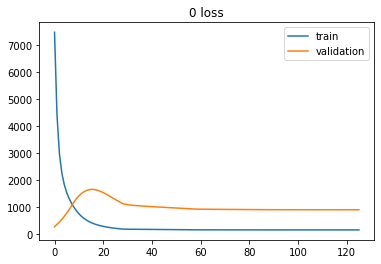

auc =  0.981896239648853
Loading  1


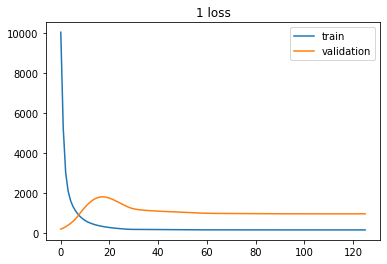

auc =  0.9958092881226226
Loading  2


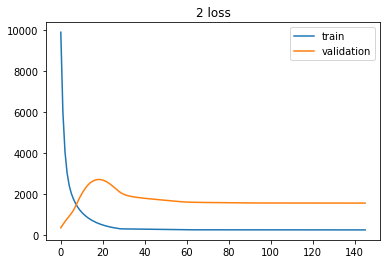

auc =  0.8685520092110448
Loading  3


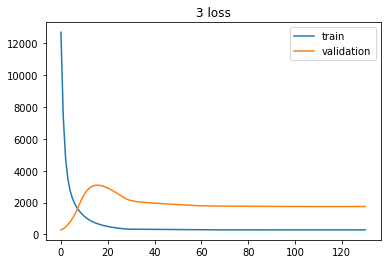

auc =  0.90683592330312
Loading  4


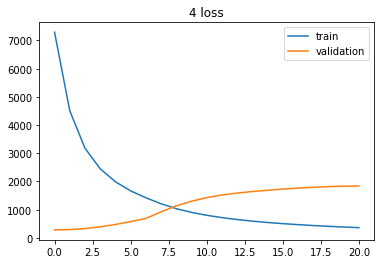

auc =  0.9418176545754384
Loading  5


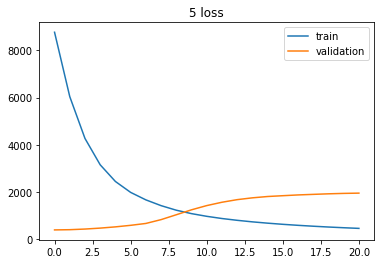

auc =  0.8950440380604643
Loading  6


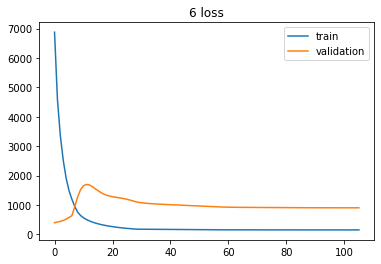

auc =  0.9775054616383114
Loading  7


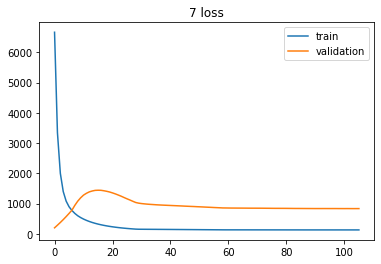

auc =  0.950438437091791
Loading  8


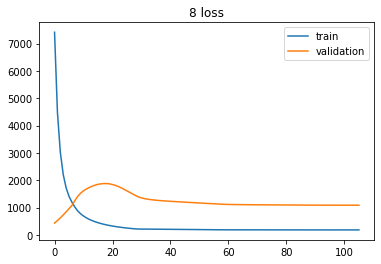

auc =  0.8820838590410274
Loading  9


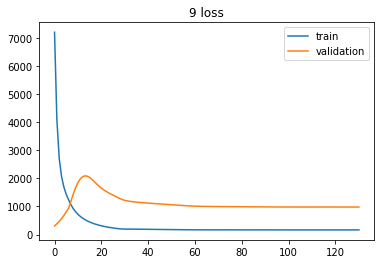

auc =  0.9437348371386473


array([[ 0.        ,  0.        ,  0.98189624, 56.51810384],
       [ 1.        ,  0.        ,  0.99580929, 67.32236099],
       [ 2.        ,  0.        ,  0.86855201, 60.44335628],
       [ 3.        ,  0.        ,  0.90683592, 60.92197037],
       [ 4.        ,  0.        ,  0.94181765, 37.68390918],
       [ 5.        ,  0.        ,  0.89504404, 31.87079787],
       [ 6.        ,  0.        ,  0.97750546, 53.26506543],
       [ 7.        ,  0.        ,  0.95043844, 59.93534374],
       [ 8.        ,  0.        ,  0.88208386, 52.85684013],
       [ 9.        ,  0.        ,  0.94373484, 57.94840837]])

In [33]:
nu = 0.1
outlier_nu = 0.
lr_milestone = 30
warm_up_n_epochs = 7
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae(n_ae_epochs = 0, train_dataset = train_dataset, ae_lr_milestone = 50)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset, warm_up_n_epochs)
    train_SVDD.train( x_vali, x_novali)
    #train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    test_confusionmatrix_list.append(confusionmatrix)
result

Loading  0


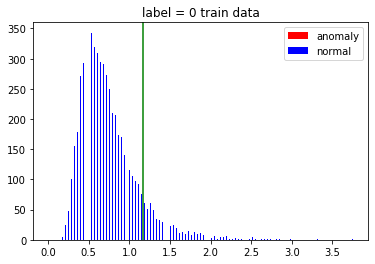

 train label = 0 uncertain_img


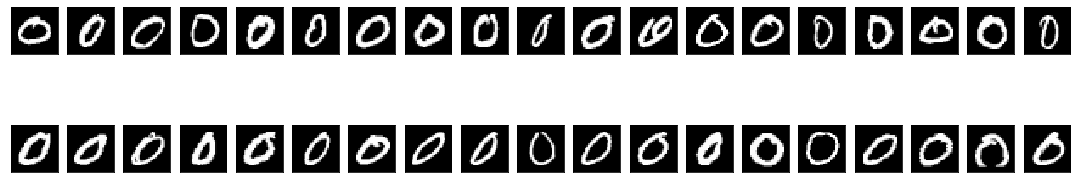

train label = 0 distance oder


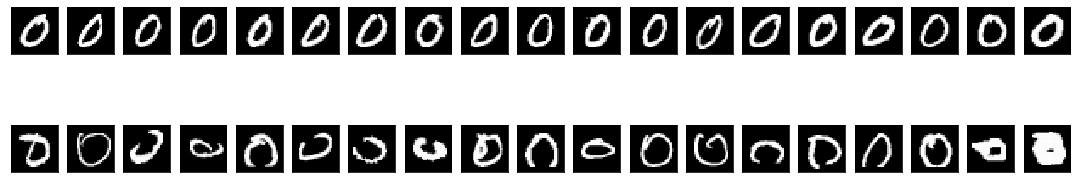

train label = 0 false_img


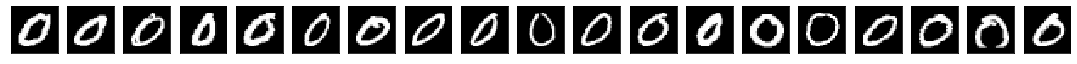

AUC: 0.981896239648853
confusion_matrix:
[[8689  331]
 [ 109  871]]


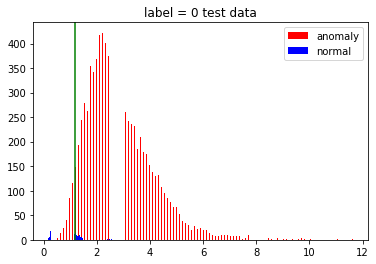

test label = 0 uncertain_img


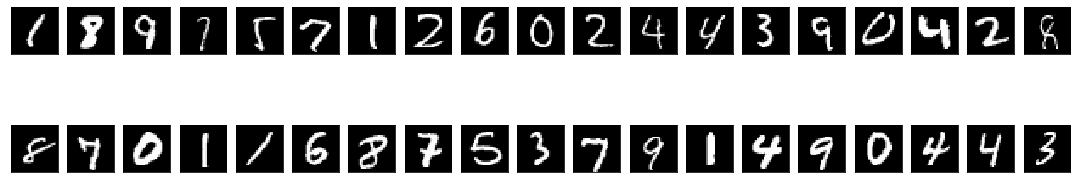

test label = 0 distance oder


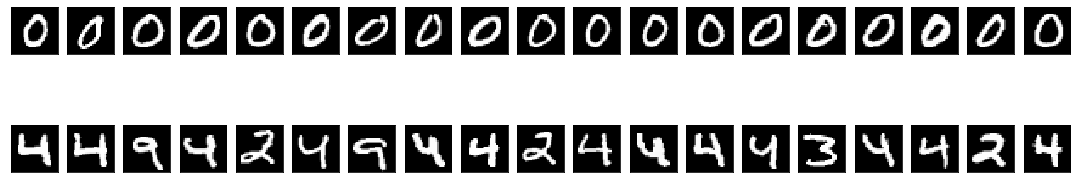

test label = 0 false_img


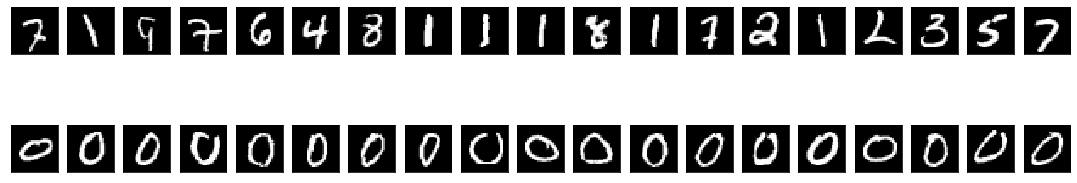

Loading  1


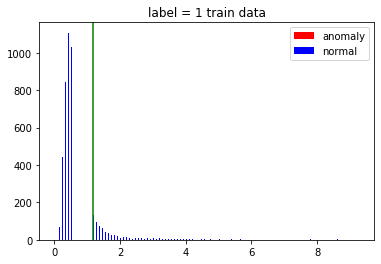

 train label = 1 uncertain_img


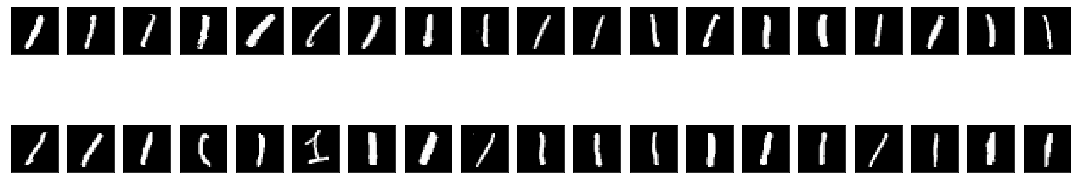

train label = 1 distance oder


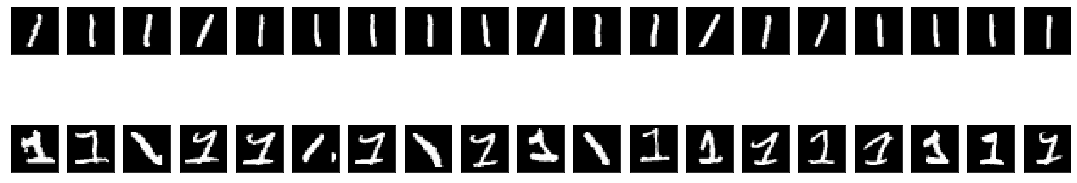

train label = 1 false_img


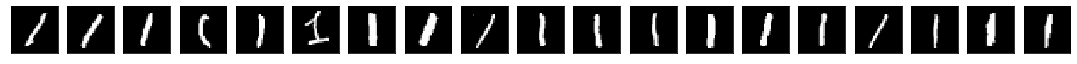

AUC: 0.9958092881226226
confusion_matrix:
[[8847   18]
 [ 115 1020]]


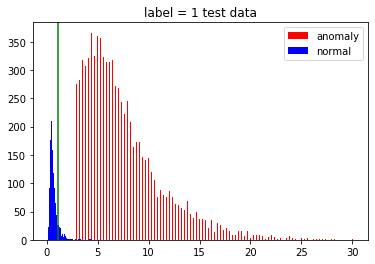

test label = 1 uncertain_img


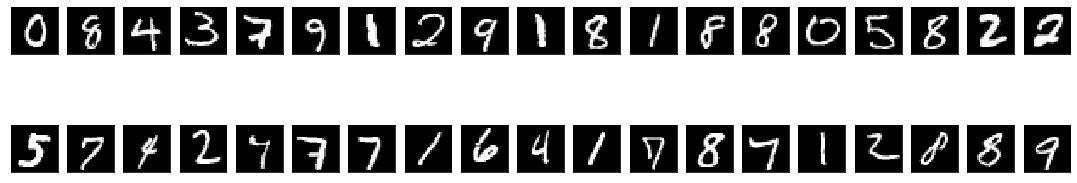

test label = 1 distance oder


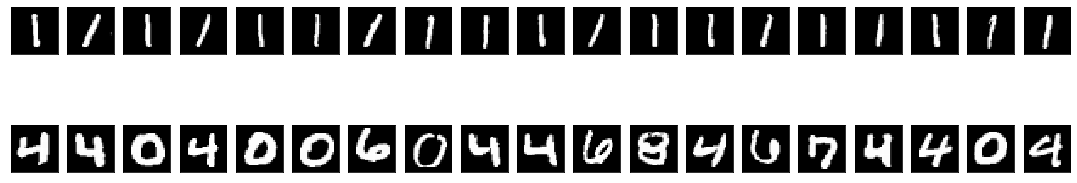

test label = 1 false_img


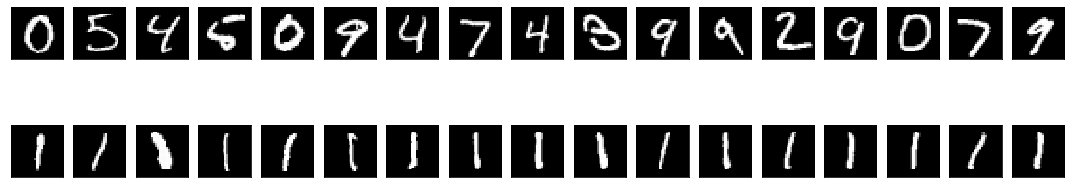

Loading  2


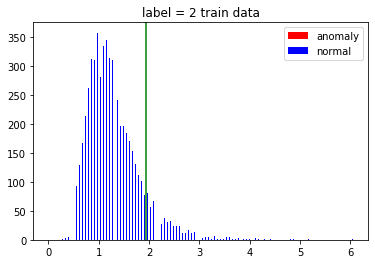

 train label = 2 uncertain_img


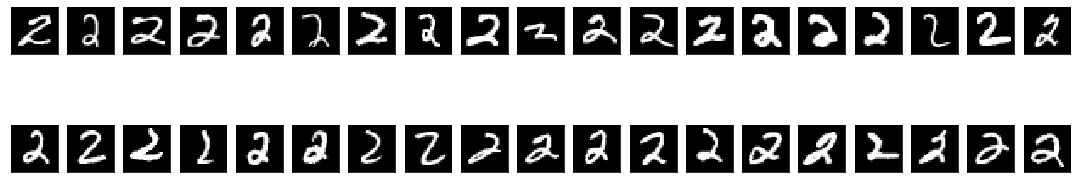

train label = 2 distance oder


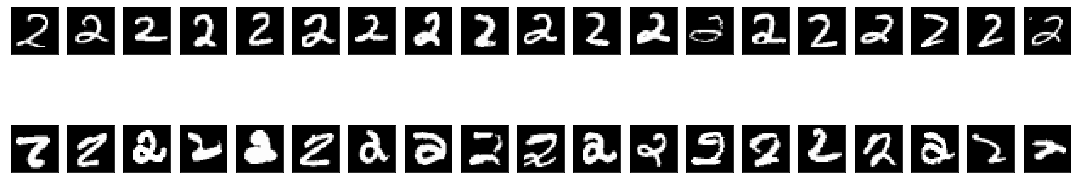

train label = 2 false_img


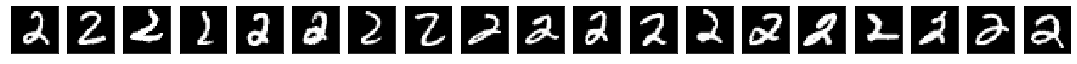

AUC: 0.8685520092110448
confusion_matrix:
[[5882 3086]
 [  93  939]]


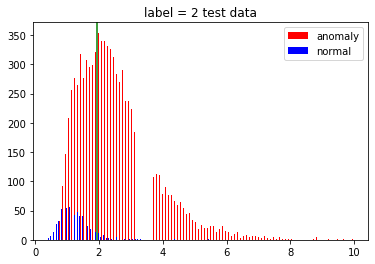

test label = 2 uncertain_img


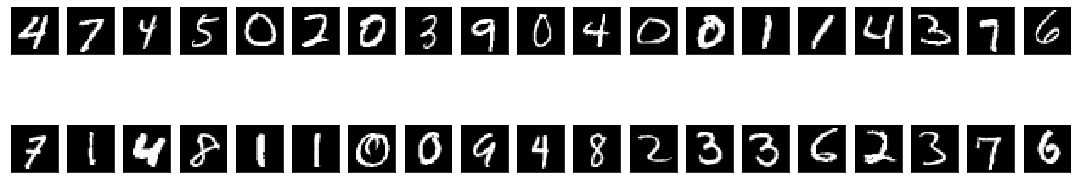

test label = 2 distance oder


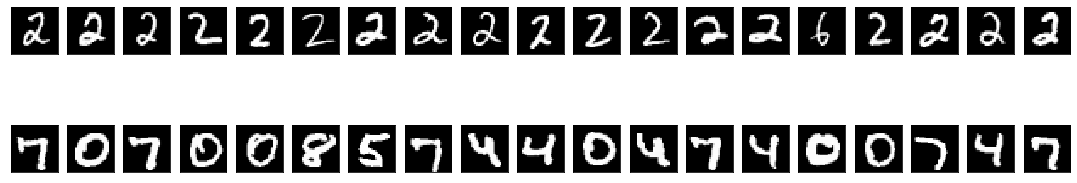

test label = 2 false_img


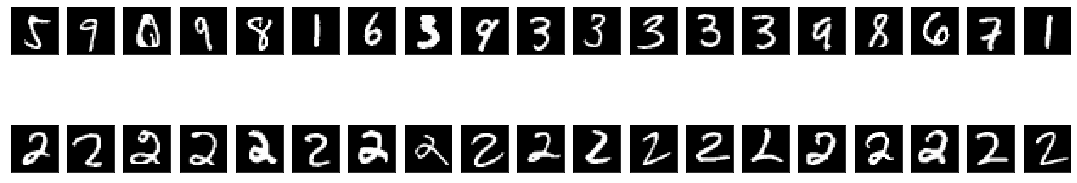

Loading  3


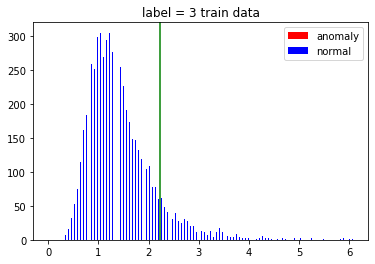

 train label = 3 uncertain_img


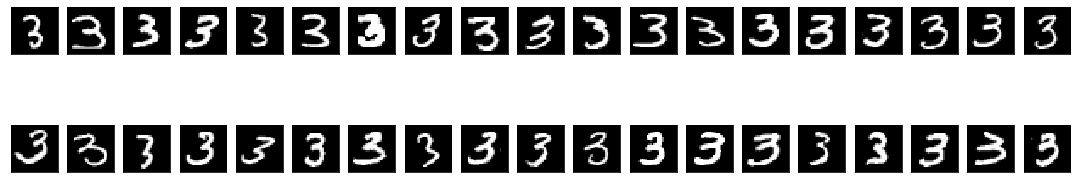

train label = 3 distance oder


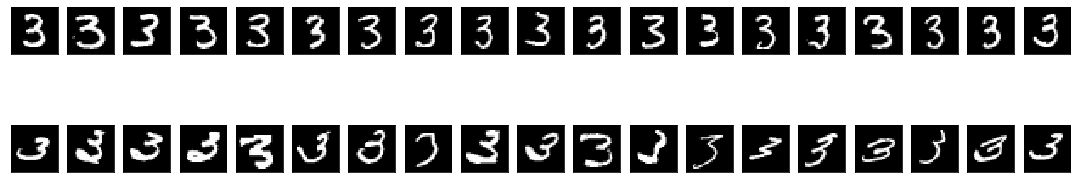

train label = 3 false_img


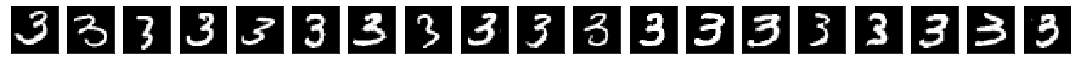

AUC: 0.90683592330312
confusion_matrix:
[[6191 2799]
 [  92  918]]


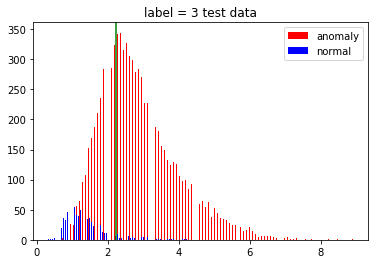

test label = 3 uncertain_img


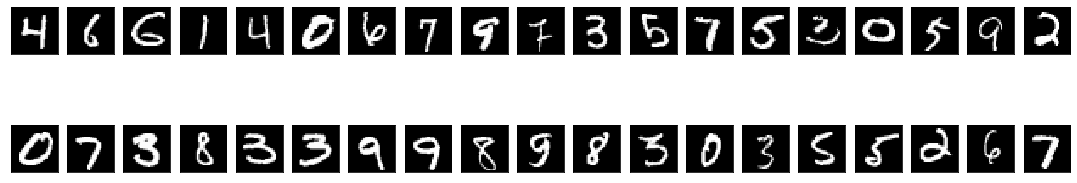

test label = 3 distance oder


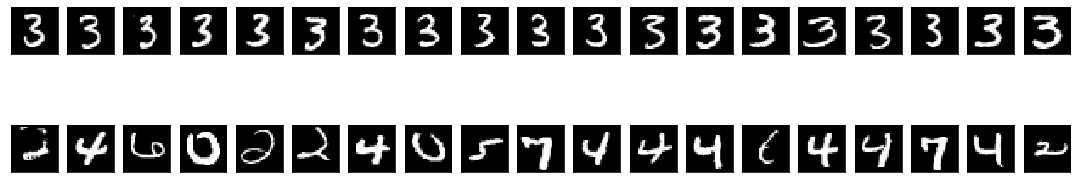

test label = 3 false_img


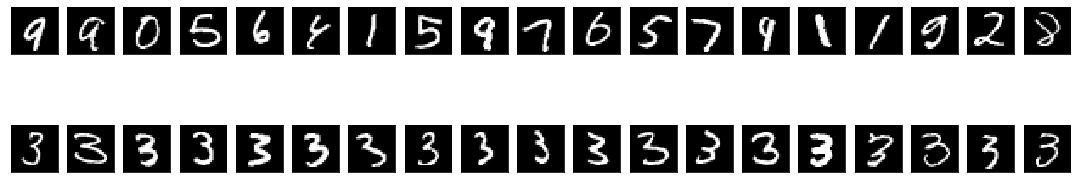

Loading  4


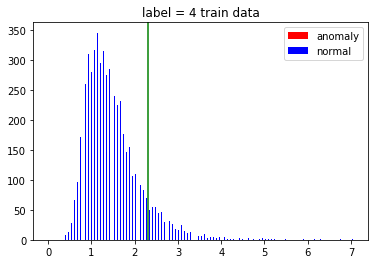

 train label = 4 uncertain_img


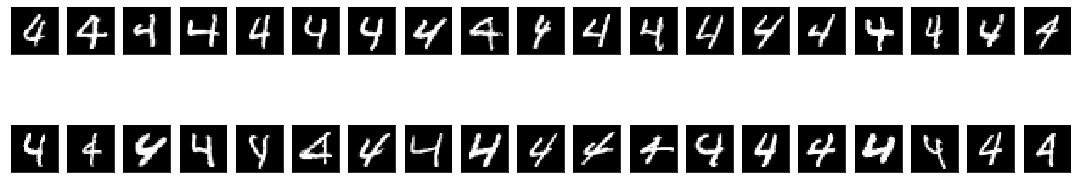

train label = 4 distance oder


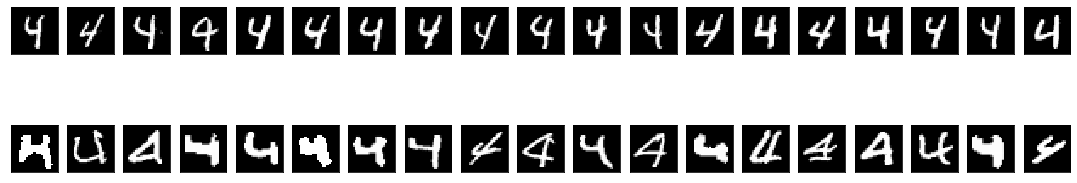

train label = 4 false_img


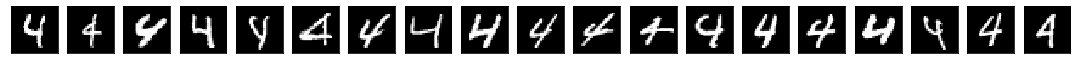

AUC: 0.9418176545754384
confusion_matrix:
[[7626 1392]
 [ 118  864]]


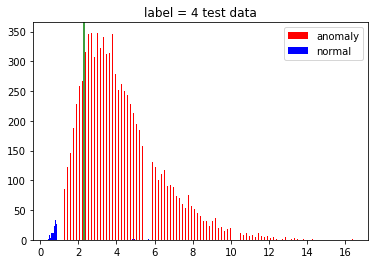

test label = 4 uncertain_img


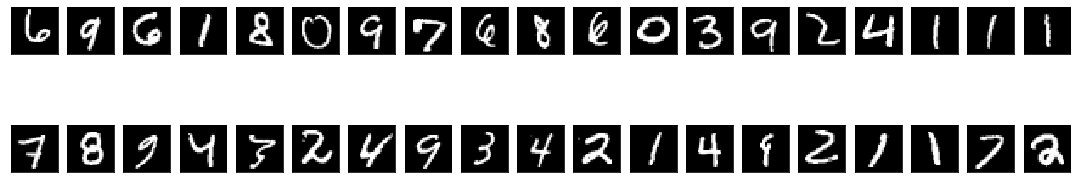

test label = 4 distance oder


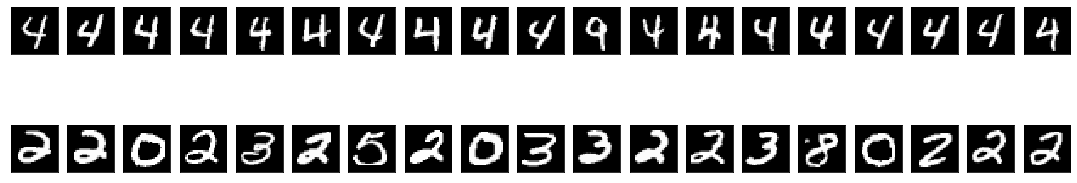

test label = 4 false_img


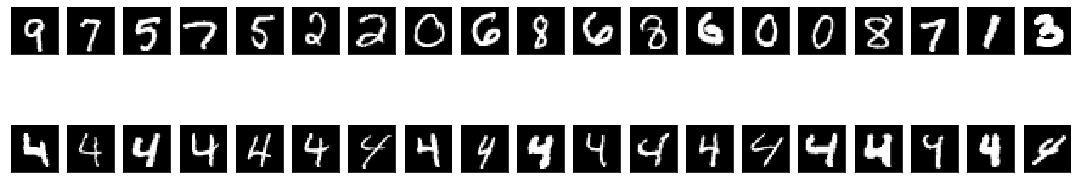

Loading  5


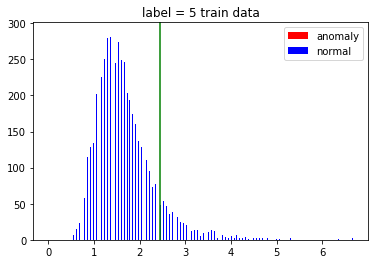

 train label = 5 uncertain_img


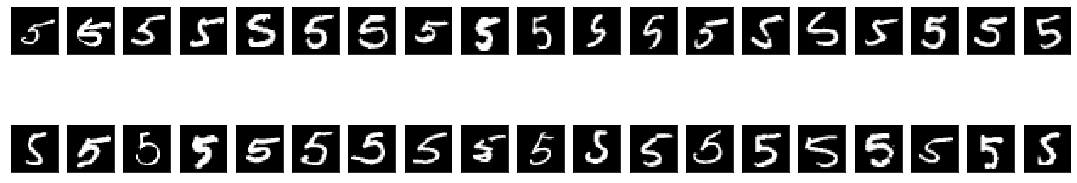

train label = 5 distance oder


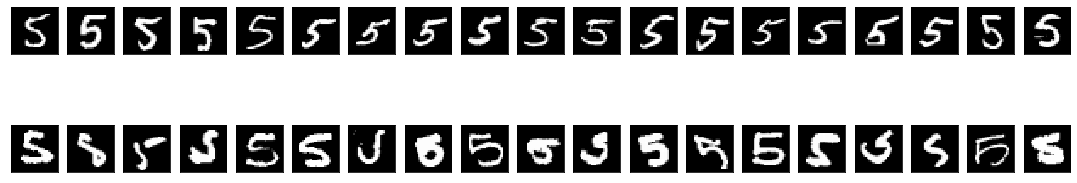

train label = 5 false_img


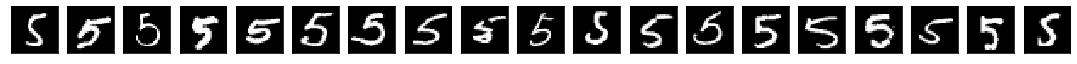

AUC: 0.8950440380604643
confusion_matrix:
[[6362 2746]
 [ 100  792]]


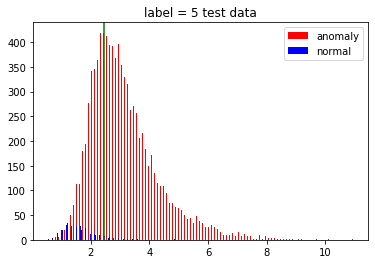

test label = 5 uncertain_img


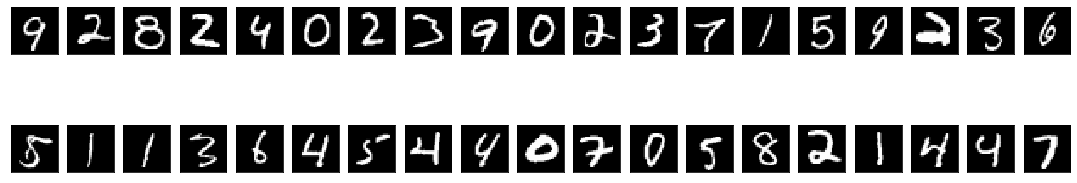

test label = 5 distance oder


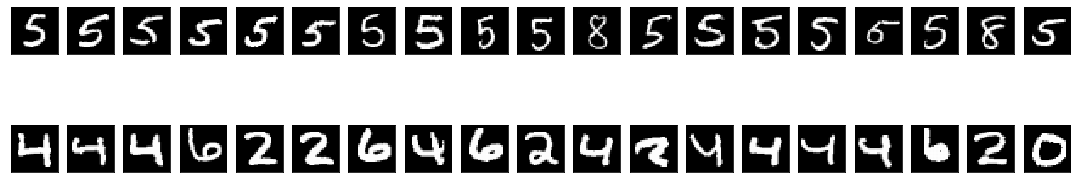

test label = 5 false_img


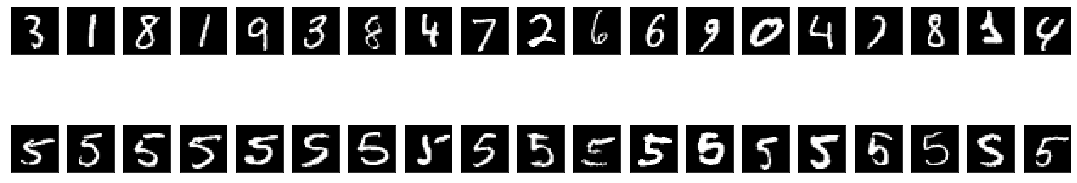

Loading  6


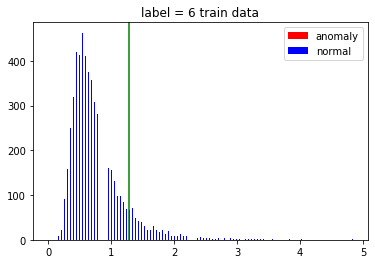

 train label = 6 uncertain_img


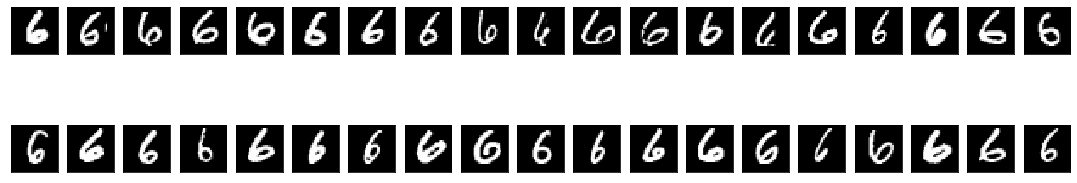

train label = 6 distance oder


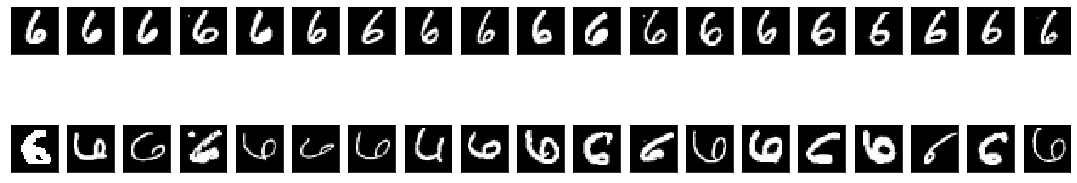

train label = 6 false_img


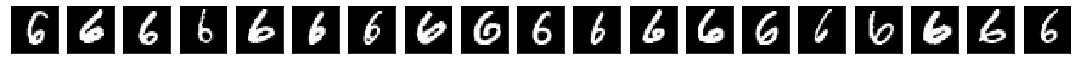

AUC: 0.9775054616383114
confusion_matrix:
[[8639  403]
 [ 103  855]]


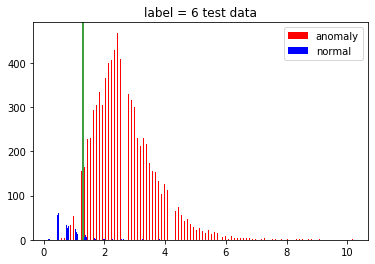

test label = 6 uncertain_img


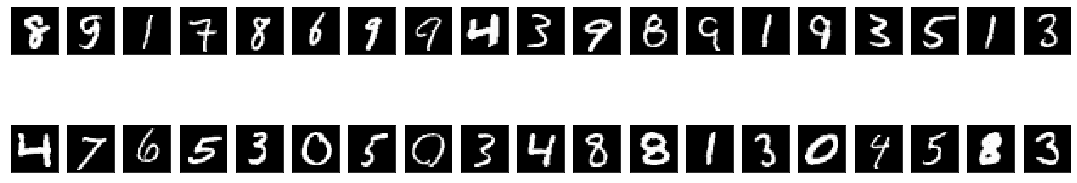

test label = 6 distance oder


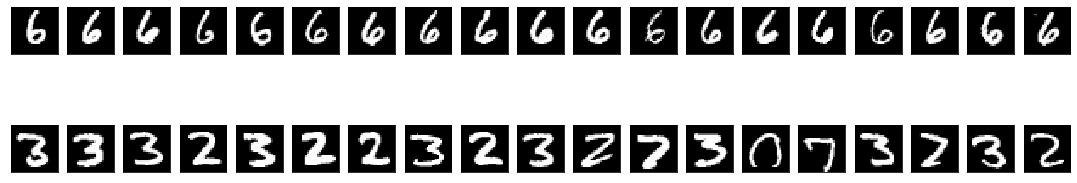

test label = 6 false_img


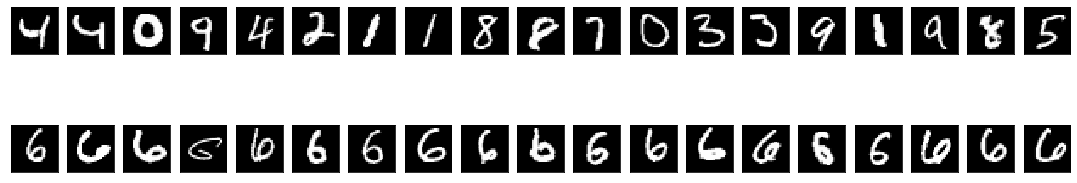

Loading  7


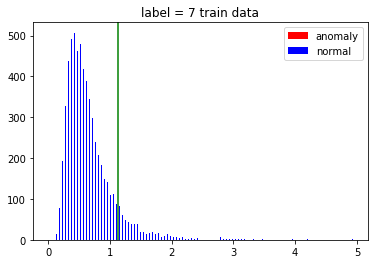

 train label = 7 uncertain_img


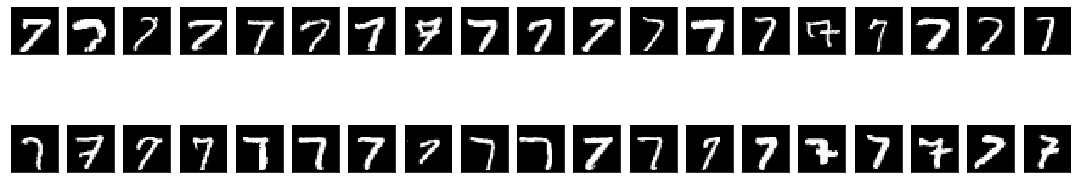

train label = 7 distance oder


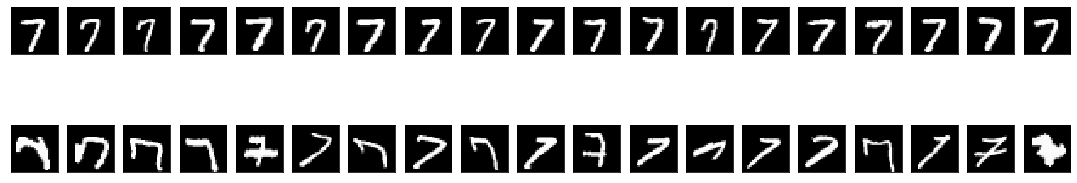

train label = 7 false_img


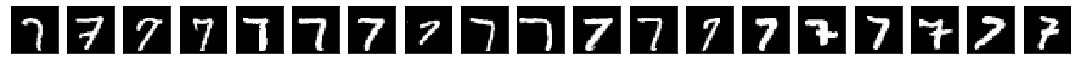

AUC: 0.950438437091791
confusion_matrix:
[[7724 1248]
 [  97  931]]


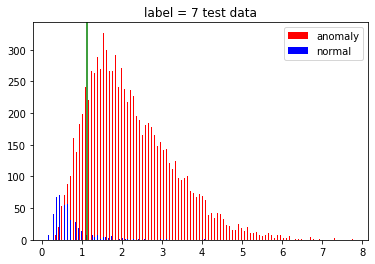

test label = 7 uncertain_img


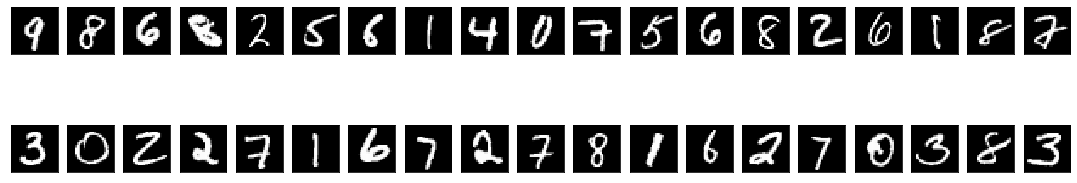

test label = 7 distance oder


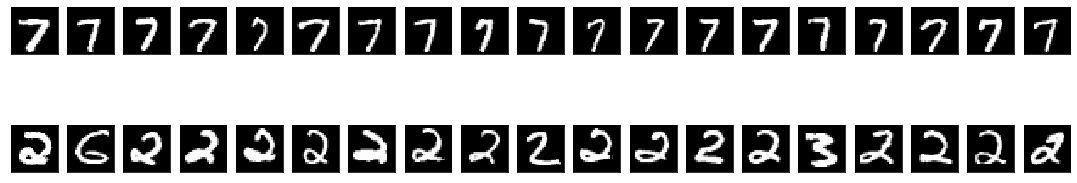

test label = 7 false_img


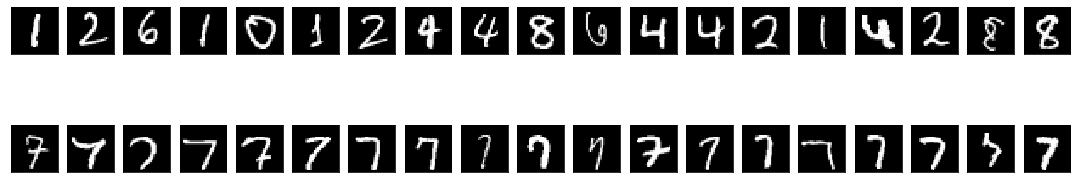

Loading  8


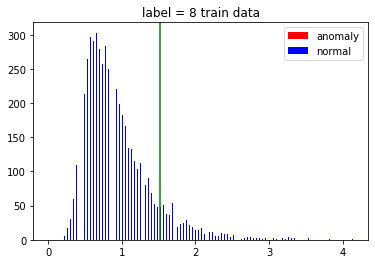

 train label = 8 uncertain_img


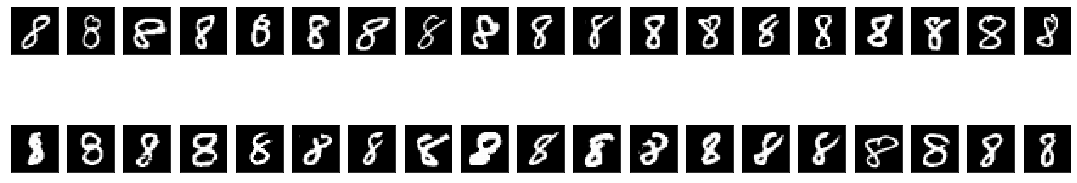

train label = 8 distance oder


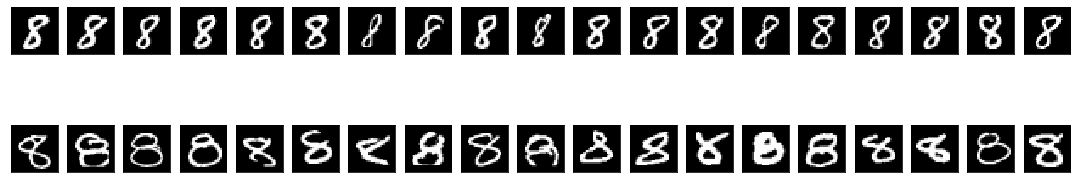

train label = 8 false_img


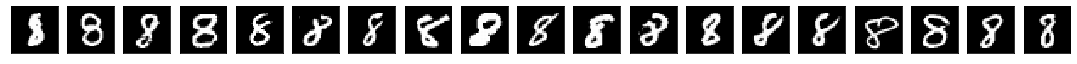

AUC: 0.8820838590410274
confusion_matrix:
[[5630 3396]
 [  98  876]]


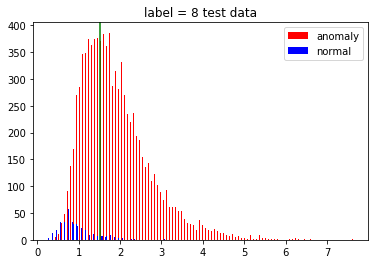

test label = 8 uncertain_img


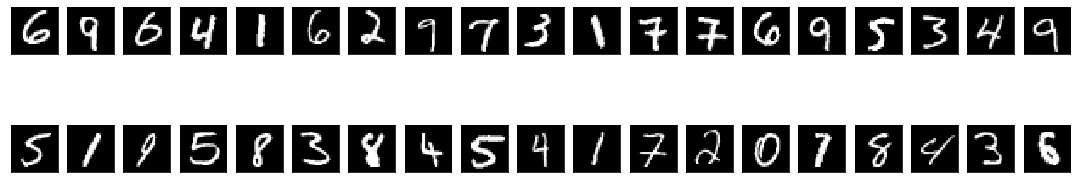

test label = 8 distance oder


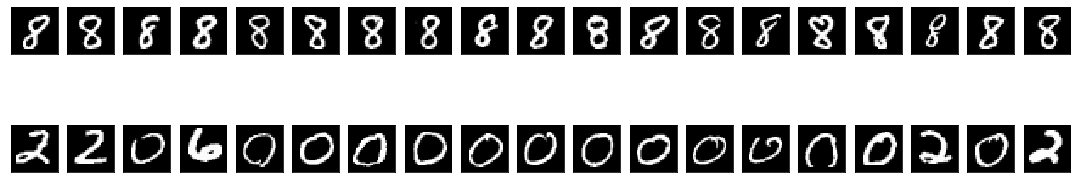

test label = 8 false_img


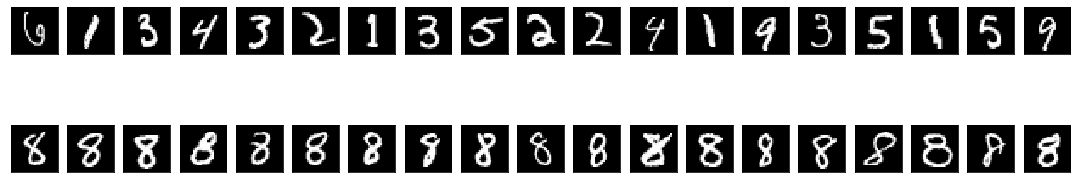

Loading  9


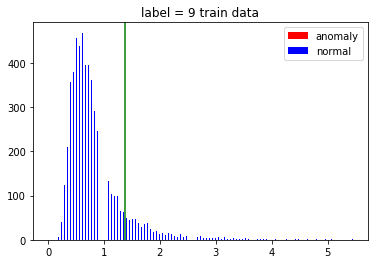

 train label = 9 uncertain_img


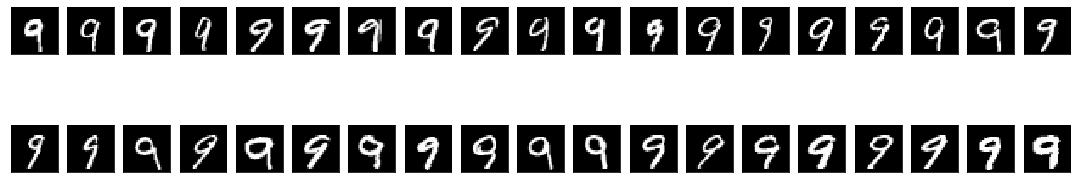

train label = 9 distance oder


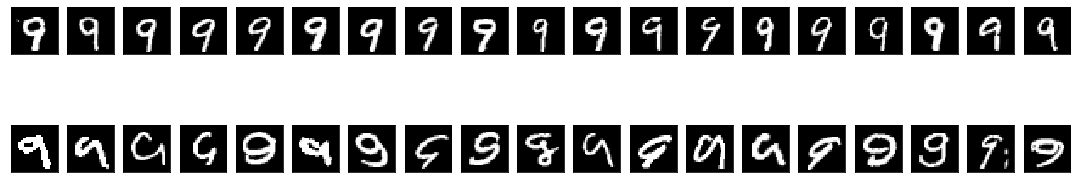

train label = 9 false_img


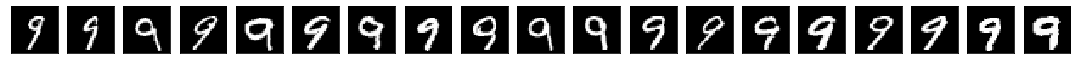

AUC: 0.9437348371386473
confusion_matrix:
[[7486 1505]
 [ 101  908]]


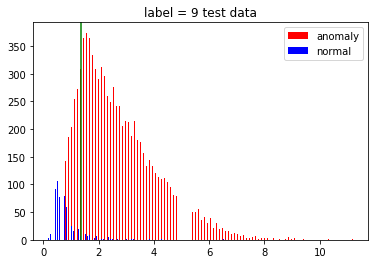

test label = 9 uncertain_img


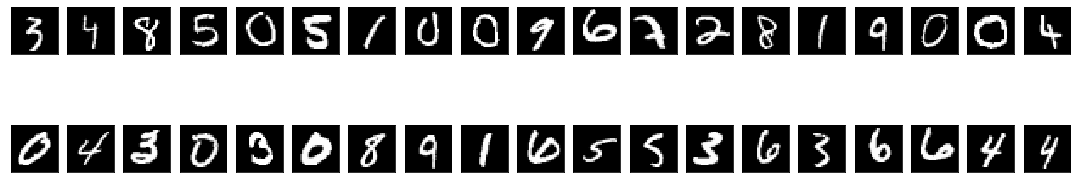

test label = 9 distance oder


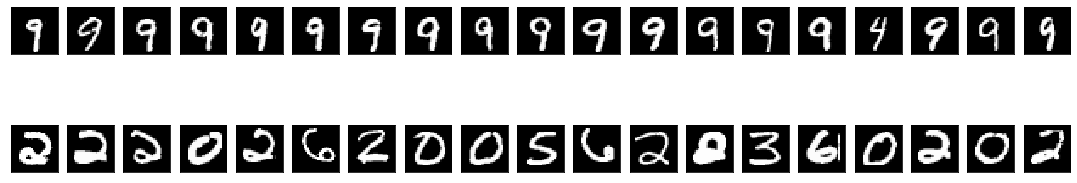

test label = 9 false_img


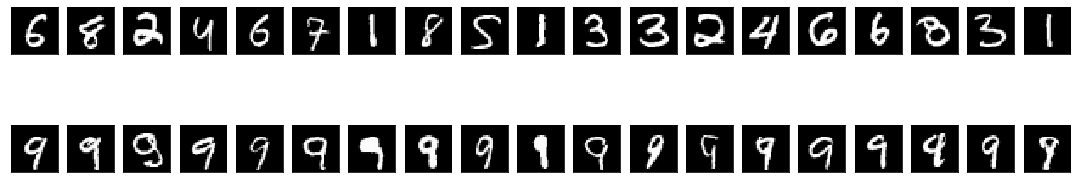

In [34]:
nu = 0.1
outlier_nu = 0.
lr_milestone = 30
warm_up_n_epochs = 7
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset, warm_up_n_epochs)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test,  load_model = True, show_img = True)


In [35]:
result = np.zeros((10, 4))
train_confusionmatrix_list = []
test_confusionmatrix_list = []

Loading  0


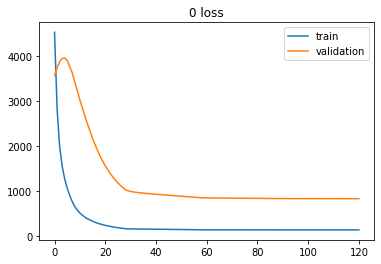

auc =  0.9400144802932258
Loading  1


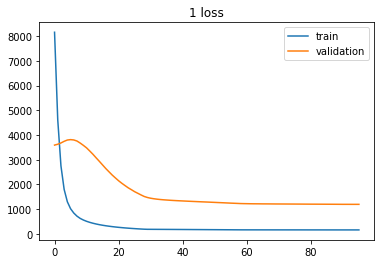

auc =  0.9936469459911397
Loading  2


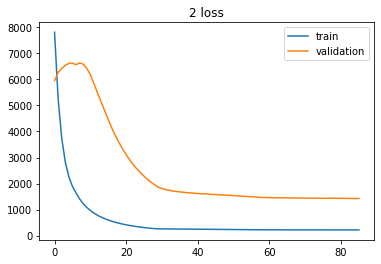

auc =  0.8560201560760395
Loading  3


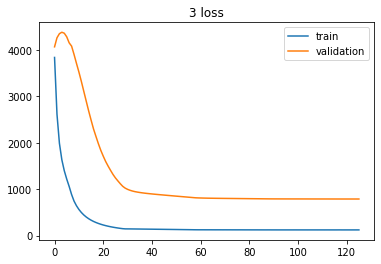

auc =  0.8513274925935308
Loading  4


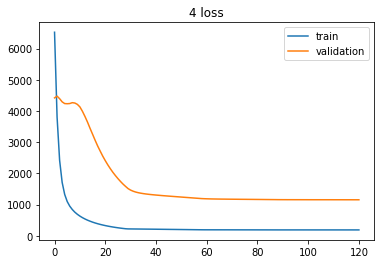

auc =  0.8965086346880803
Loading  5


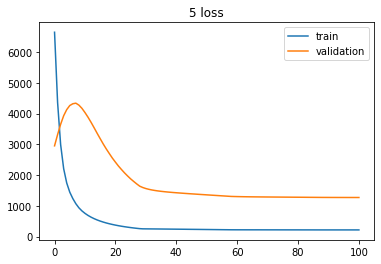

auc =  0.8679062510462393
Loading  6


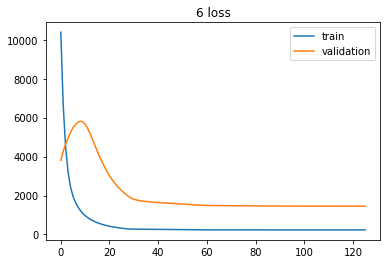

auc =  0.9585234112762572
Loading  7


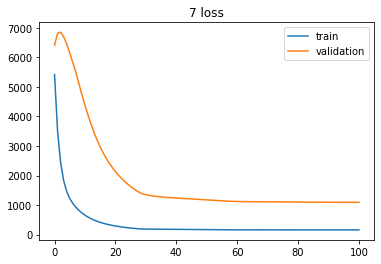

auc =  0.9176209252824612
Loading  8


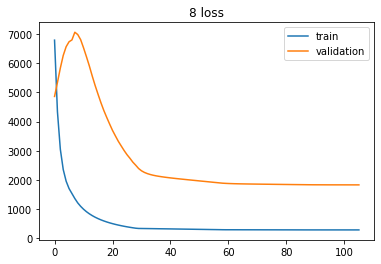

auc =  0.904197763613308
Loading  9


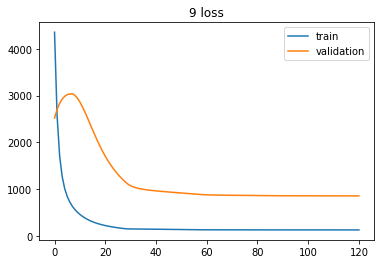

auc =  0.9510124594366418


array([[ 0.        ,  0.        ,  0.94001448, 62.45260715],
       [ 1.        ,  0.        ,  0.99364695, 70.51256537],
       [ 2.        ,  0.        ,  0.85602016, 57.19257116],
       [ 3.        ,  0.        ,  0.85132749, 65.82419372],
       [ 4.        ,  0.        ,  0.89650863, 60.72714996],
       [ 5.        ,  0.        ,  0.86790625, 51.04102492],
       [ 6.        ,  0.        ,  0.95852341, 61.70424771],
       [ 7.        ,  0.        ,  0.91762093, 64.64284039],
       [ 8.        ,  0.        ,  0.90419776, 57.68990993],
       [ 9.        ,  0.        ,  0.95101246, 61.41882801]])

In [36]:
nu = 0.05
outlier_nu = 0.05
lr_milestone = 30
warm_up_n_epochs = 7
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae(n_ae_epochs = 10, train_dataset = train_dataset, ae_lr_milestone = 50)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset, warm_up_n_epochs)
    train_SVDD.train( x_vali, x_novali)
    #train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    test_confusionmatrix_list.append(confusionmatrix)
result

In [77]:
result = np.zeros((10, 4))
train_confusionmatrix_list = []
test_confusionmatrix_list = []

Loading  0


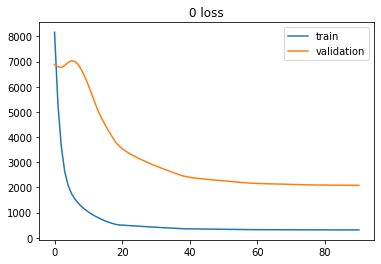

auc =  0.9592199873297433
Loading  1


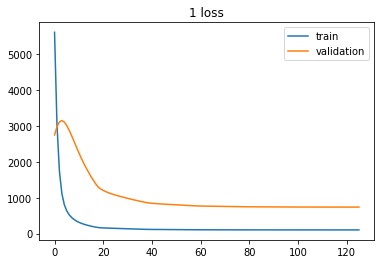

auc =  0.9935019417548097
Loading  2


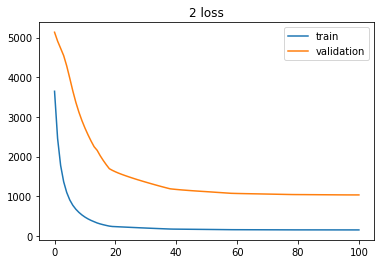

auc =  0.8396716533894847
Loading  3


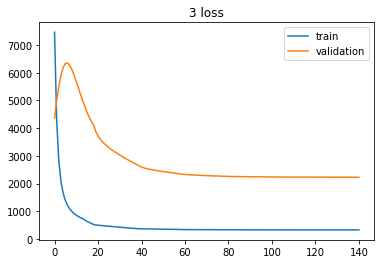

auc =  0.8997606801837024
Loading  4


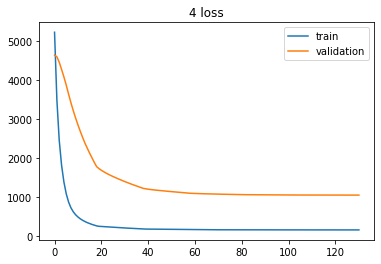

auc =  0.8724909312400319
Loading  5


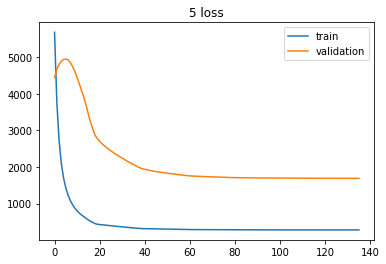

auc =  0.7956216975762695
Loading  6


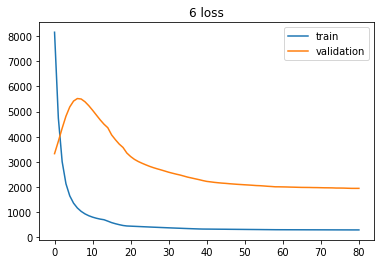

auc =  0.913530178582066
Loading  7


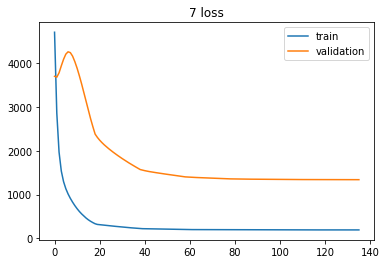

auc =  0.8887891165077345
Loading  8


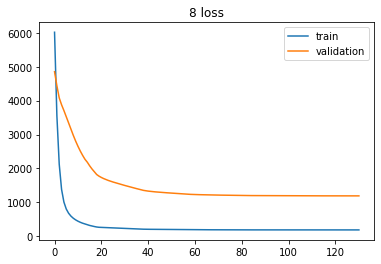

auc =  0.8906097648090322
Loading  9


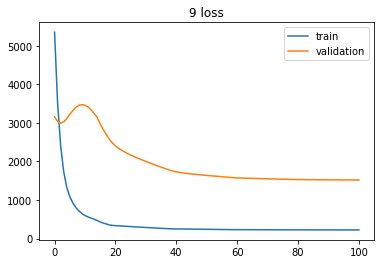

auc =  0.9345559632972914


In [78]:
nu = 0.1
outlier_nu = 0.1
lr_milestone = 20
lr_change = 0.25
warm_up_n_epochs = 14
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae(n_ae_epochs = 10, train_dataset = train_dataset, ae_lr_milestone = 50)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset,
                                     warm_up_n_epochs, lr_change)
    train_SVDD.train( x_vali, x_novali)
    #train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    test_confusionmatrix_list.append(confusionmatrix)

In [79]:
result

array([[  0.        ,   0.        ,   0.95921999, 107.212749  ],
       [  1.        ,   0.        ,   0.99350194, 138.36137247],
       [  2.        ,   0.        ,   0.83967165, 111.15590668],
       [  3.        ,   0.        ,   0.89976068, 118.85283995],
       [  4.        ,   0.        ,   0.87249093, 108.18362403],
       [  5.        ,   0.        ,   0.7956217 ,  92.89182806],
       [  6.        ,   0.        ,   0.91353018, 105.96295333],
       [  7.        ,   0.        ,   0.88878912, 125.64429069],
       [  8.        ,   0.        ,   0.89060976, 112.00484419],
       [  9.        ,   0.        ,   0.93455596, 109.92514968]])

Loading  0
AUC: 0.95977602201222
confusion_matrix:
[[ 425  167]
 [ 220 5703]]


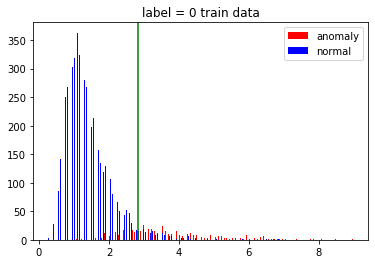

 train label = 0 uncertain_img


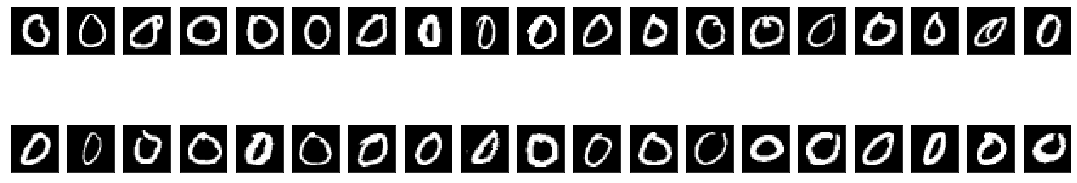

train label = 0 distance oder


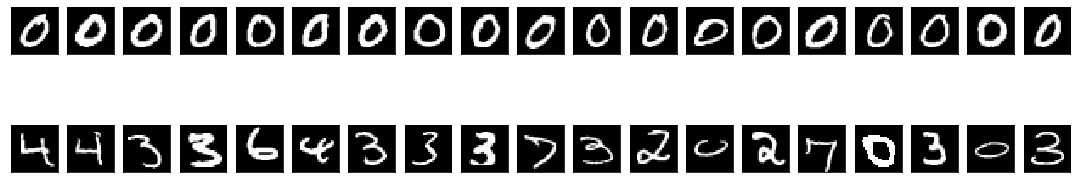

train label = 0 false_img


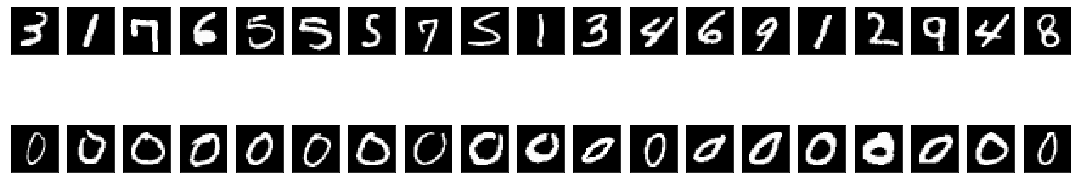

AUC: 0.9592199873297433
confusion_matrix:
[[6319 2701]
 [  34  946]]


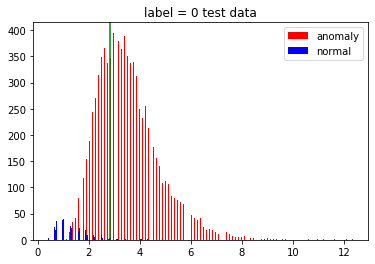

test label = 0 uncertain_img


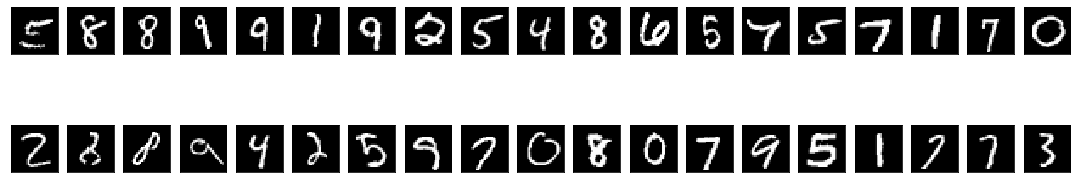

test label = 0 distance oder


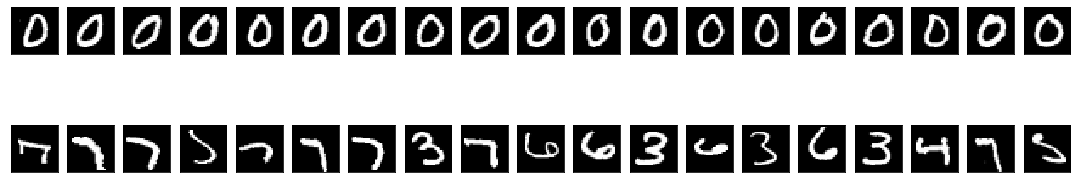

test label = 0 false_img


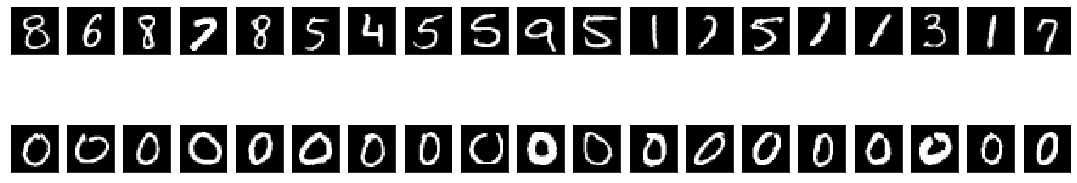

Loading  1
AUC: 0.9887540084874744
confusion_matrix:
[[ 582   92]
 [ 129 6613]]


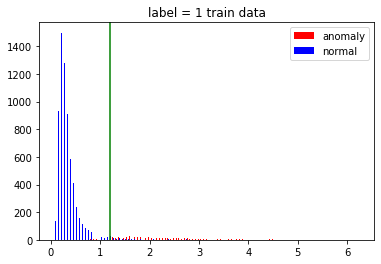

 train label = 1 uncertain_img


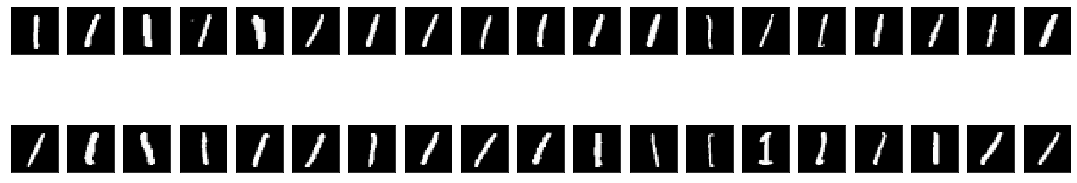

train label = 1 distance oder


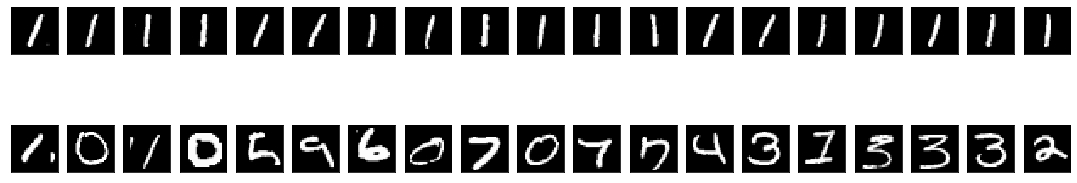

train label = 1 false_img


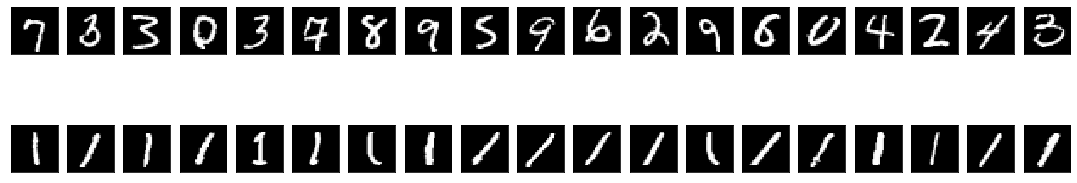

AUC: 0.9935019417548097
confusion_matrix:
[[7918  947]
 [  14 1121]]


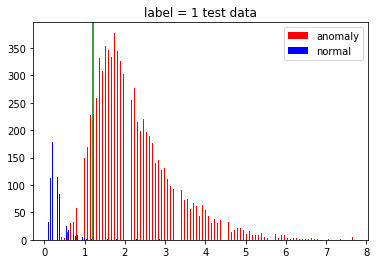

test label = 1 uncertain_img


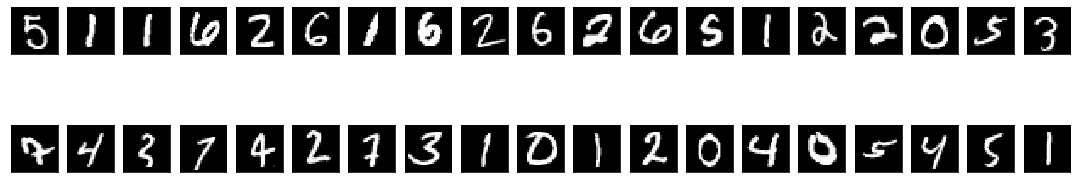

test label = 1 distance oder


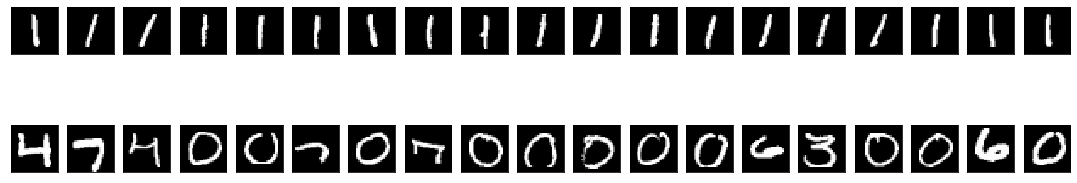

test label = 1 false_img


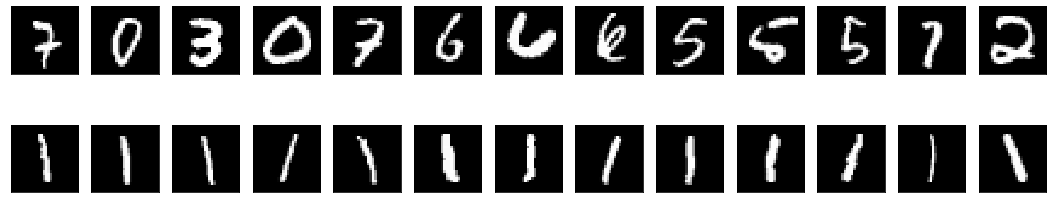

Loading  2
AUC: 0.7999393513699539
confusion_matrix:
[[ 212  383]
 [ 422 5536]]


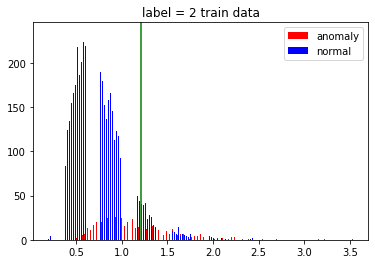

 train label = 2 uncertain_img


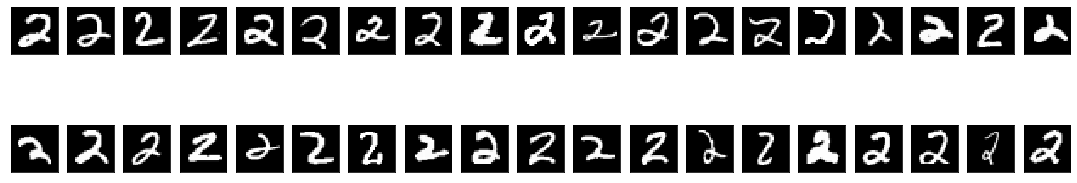

train label = 2 distance oder


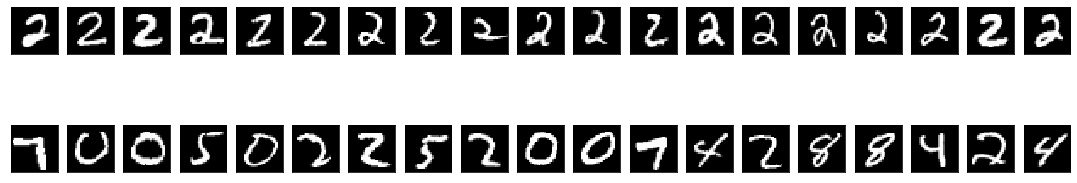

train label = 2 false_img


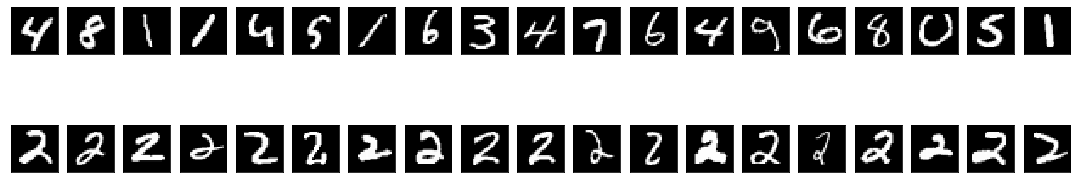

AUC: 0.8396716533894847
confusion_matrix:
[[3501 5467]
 [  57  975]]


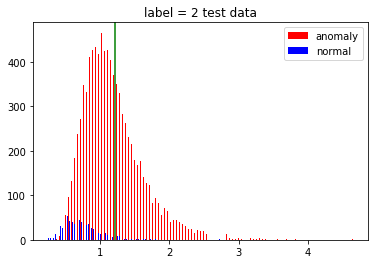

test label = 2 uncertain_img


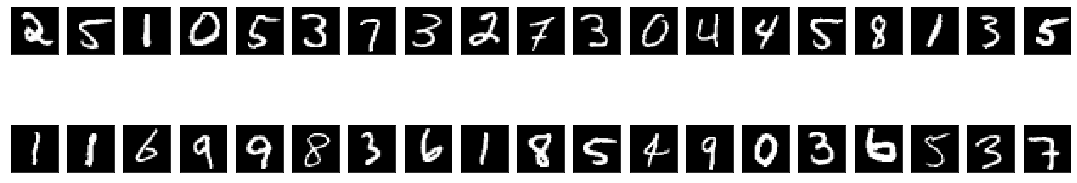

test label = 2 distance oder


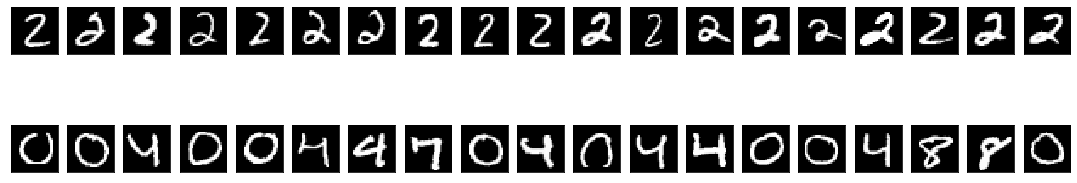

test label = 2 false_img


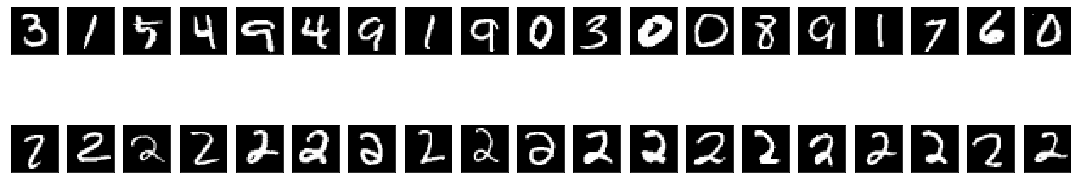

Loading  3
AUC: 0.8865408137662132
confusion_matrix:
[[ 305  308]
 [ 338 5793]]


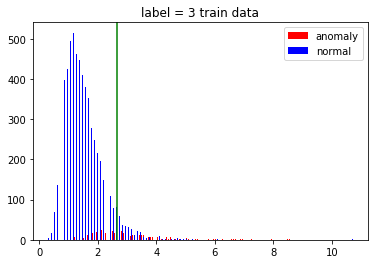

 train label = 3 uncertain_img


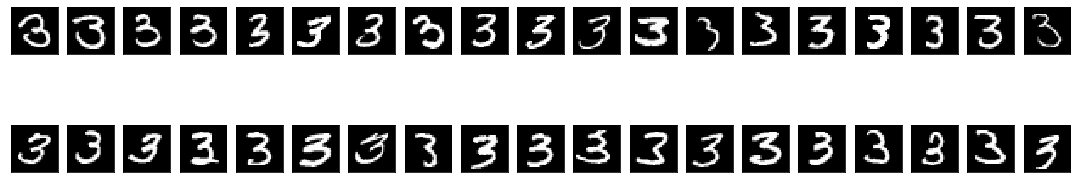

train label = 3 distance oder


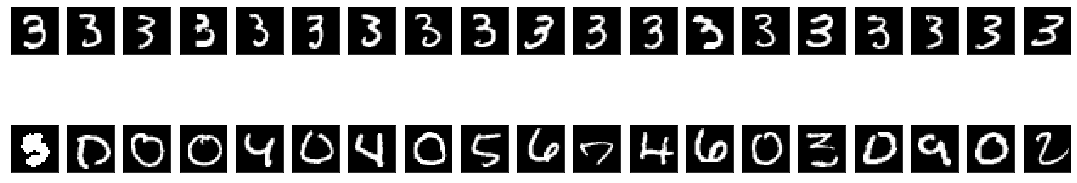

train label = 3 false_img


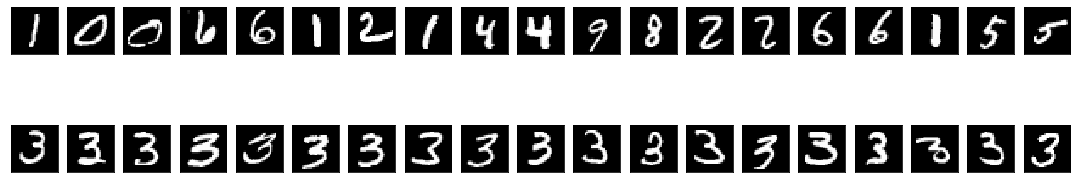

AUC: 0.8997606801837024
confusion_matrix:
[[4641 4349]
 [  58  952]]


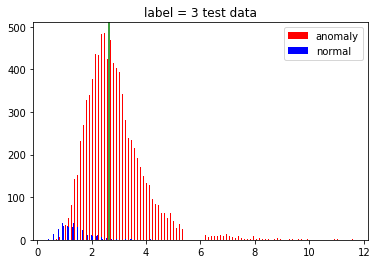

test label = 3 uncertain_img


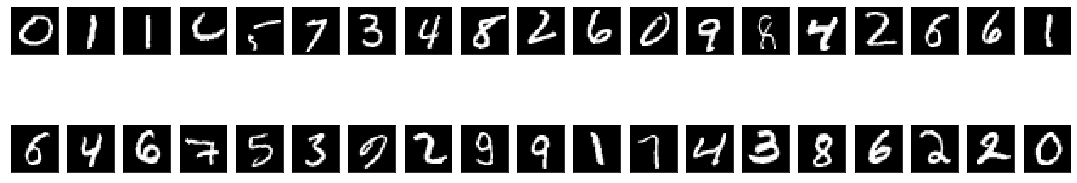

test label = 3 distance oder


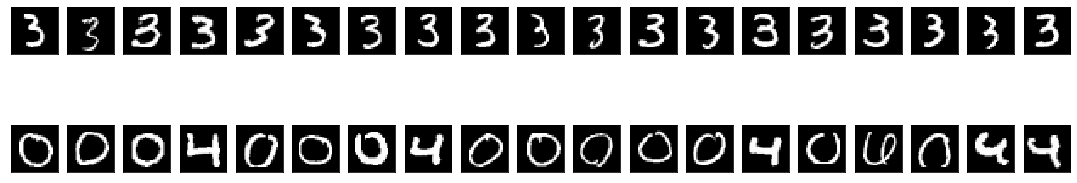

test label = 3 false_img


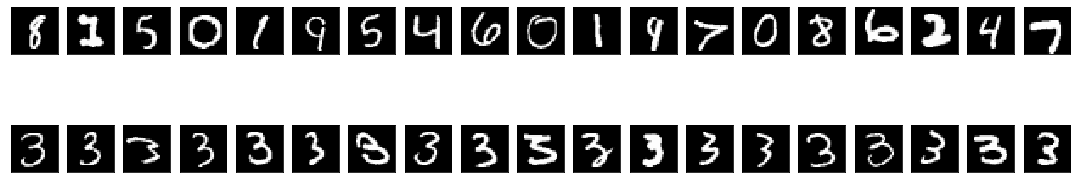

Loading  4
AUC: 0.8628258172984482
confusion_matrix:
[[ 322  262]
 [ 346 5496]]


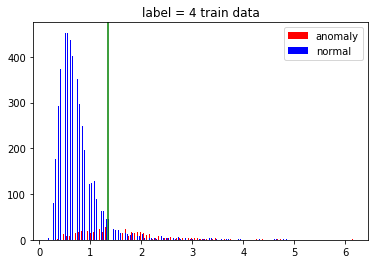

 train label = 4 uncertain_img


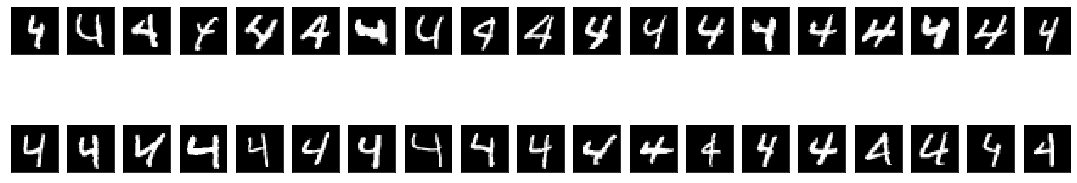

train label = 4 distance oder


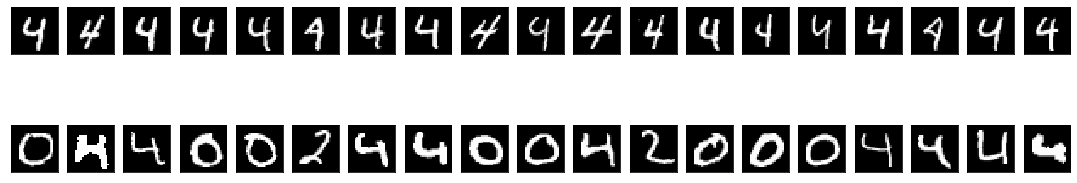

train label = 4 false_img


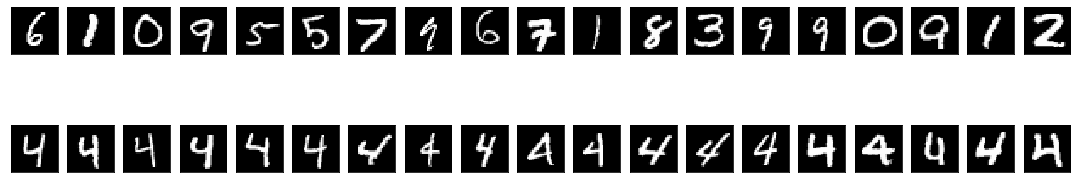

AUC: 0.8724909312400319
confusion_matrix:
[[4664 4354]
 [  51  931]]


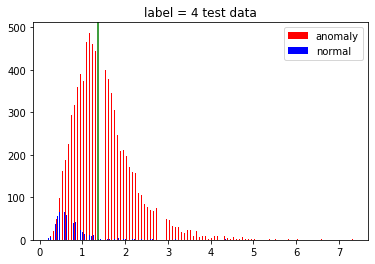

test label = 4 uncertain_img


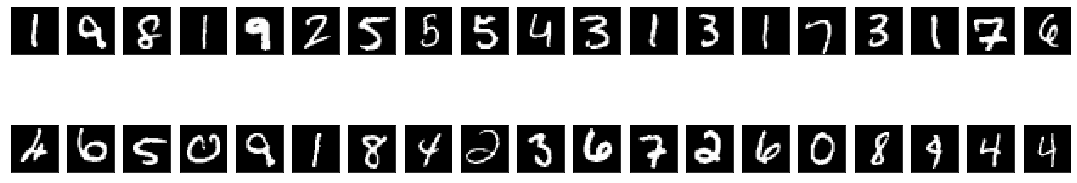

test label = 4 distance oder


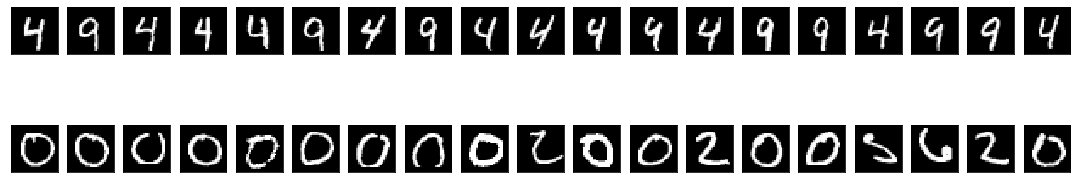

test label = 4 false_img


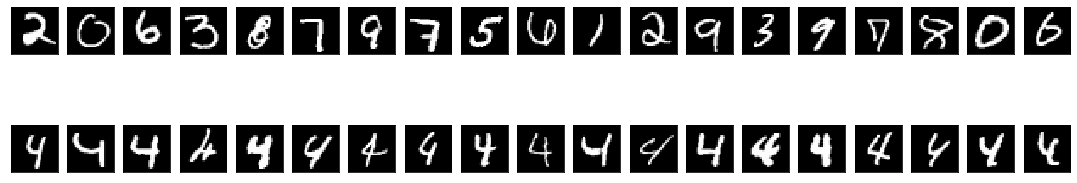

Loading  5
AUC: 0.8043303648310417
confusion_matrix:
[[ 221  321]
 [ 402 5019]]


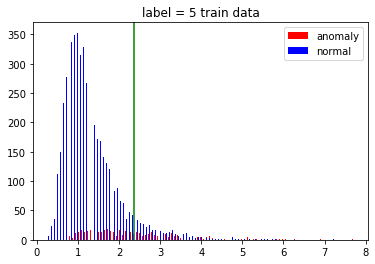

 train label = 5 uncertain_img


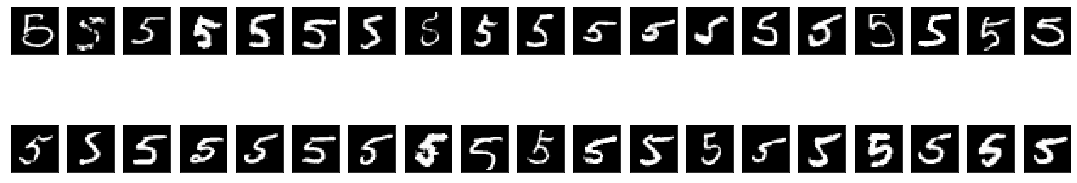

train label = 5 distance oder


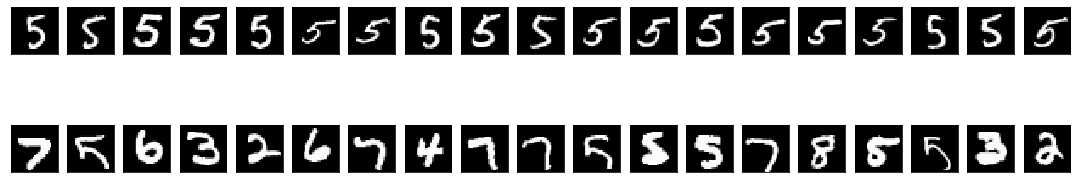

train label = 5 false_img


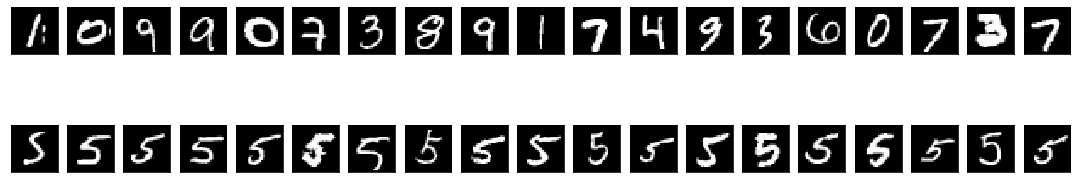

AUC: 0.7956216975762695
confusion_matrix:
[[3632 5476]
 [  55  837]]


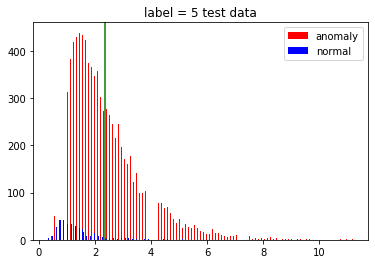

test label = 5 uncertain_img


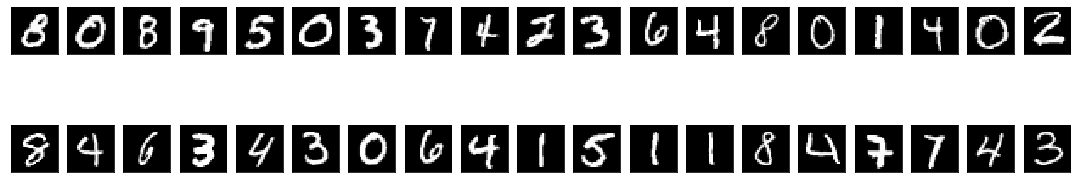

test label = 5 distance oder


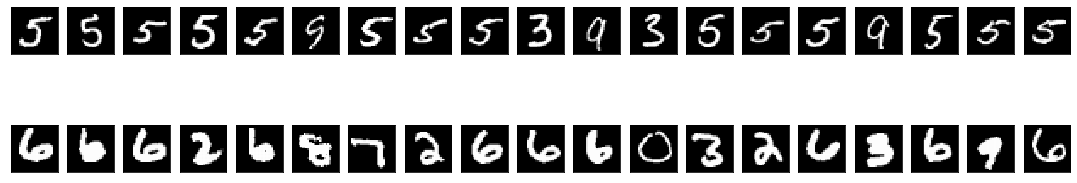

test label = 5 false_img


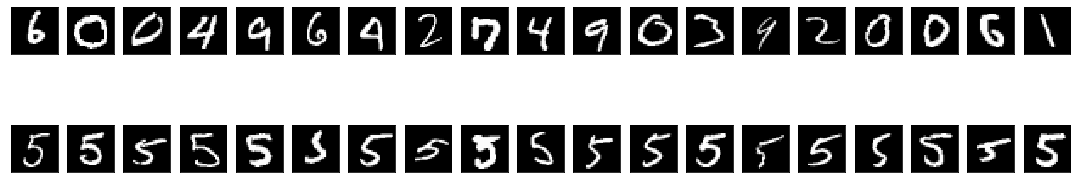

Loading  6
AUC: 0.9279884879020615
confusion_matrix:
[[ 371  220]
 [ 274 5644]]


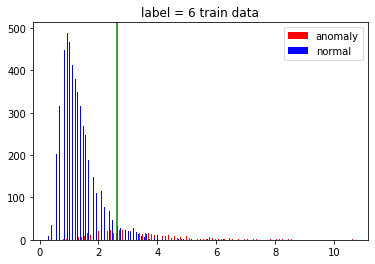

 train label = 6 uncertain_img


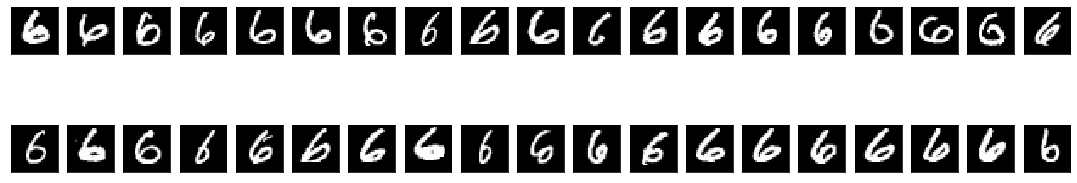

train label = 6 distance oder


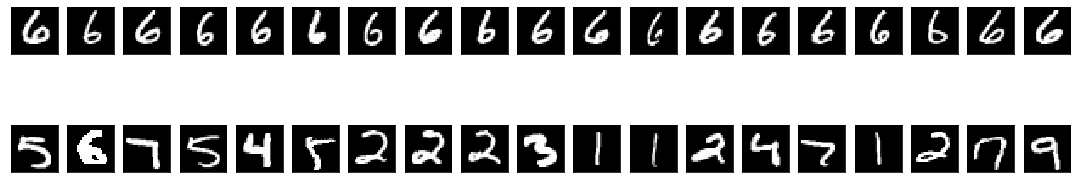

train label = 6 false_img


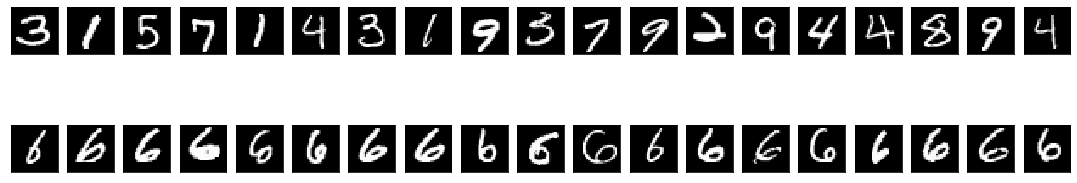

AUC: 0.913530178582066
confusion_matrix:
[[5568 3474]
 [  59  899]]


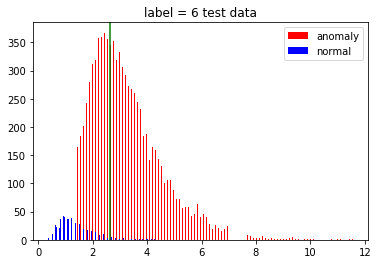

test label = 6 uncertain_img


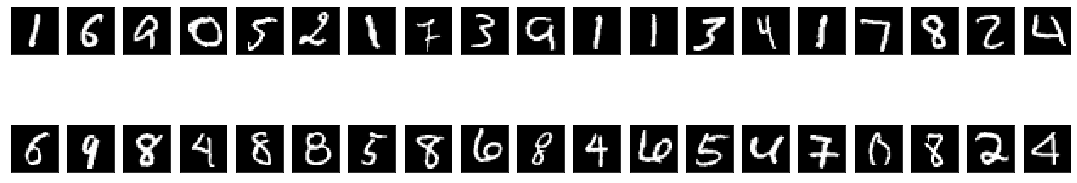

test label = 6 distance oder


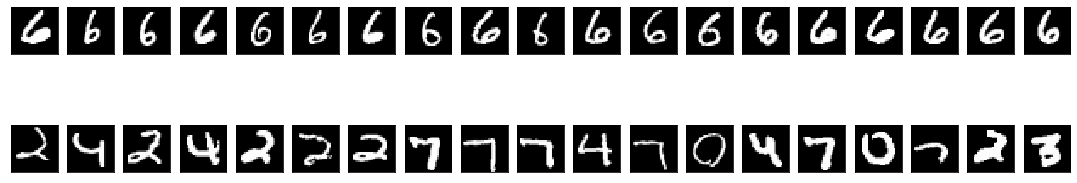

test label = 6 false_img


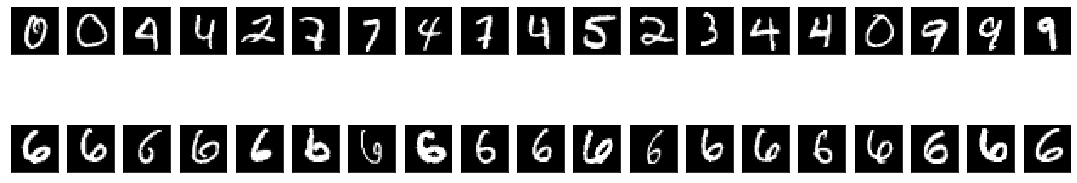

Loading  7
AUC: 0.8887857640066397
confusion_matrix:
[[ 359  267]
 [ 329 5936]]


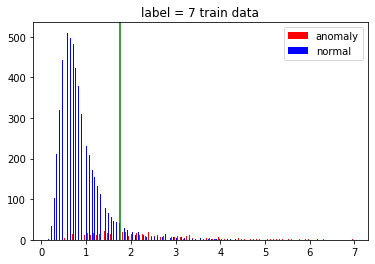

 train label = 7 uncertain_img


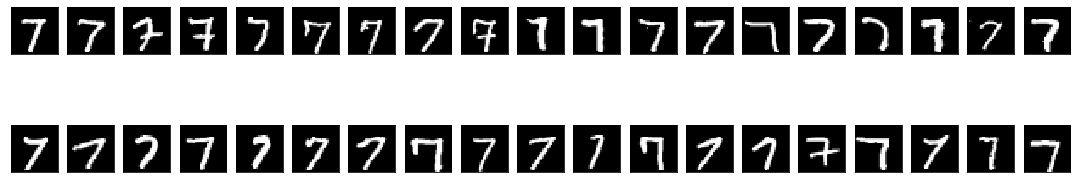

train label = 7 distance oder


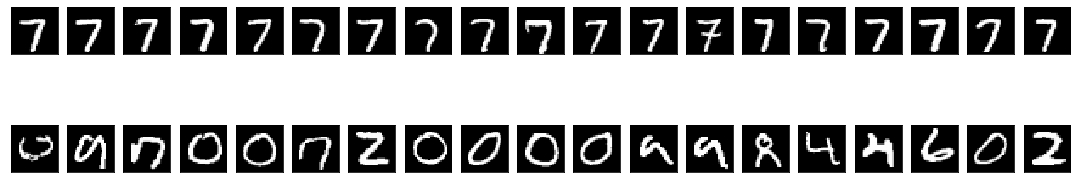

train label = 7 false_img


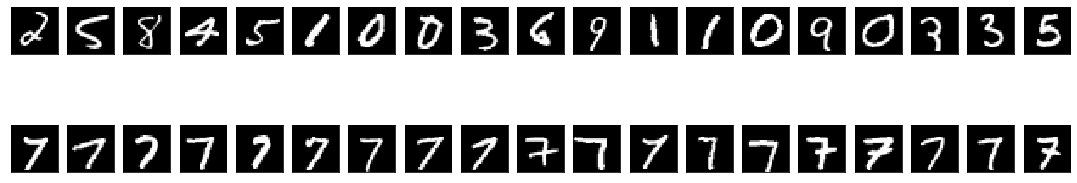

AUC: 0.8887891165077345
confusion_matrix:
[[4948 4024]
 [  53  975]]


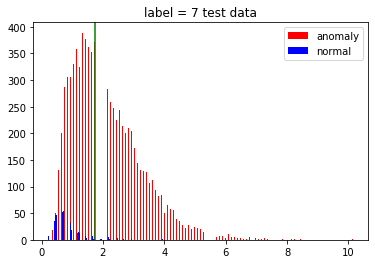

test label = 7 uncertain_img


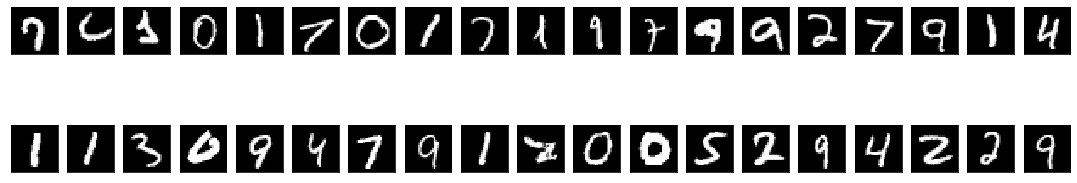

test label = 7 distance oder


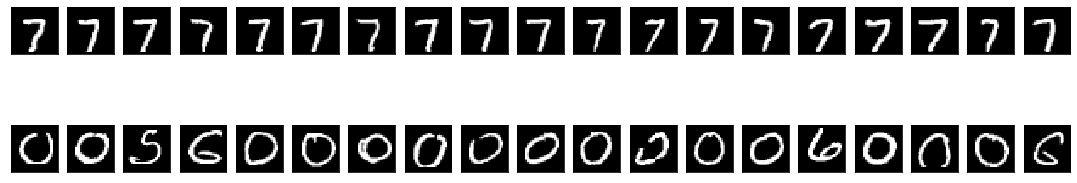

test label = 7 false_img


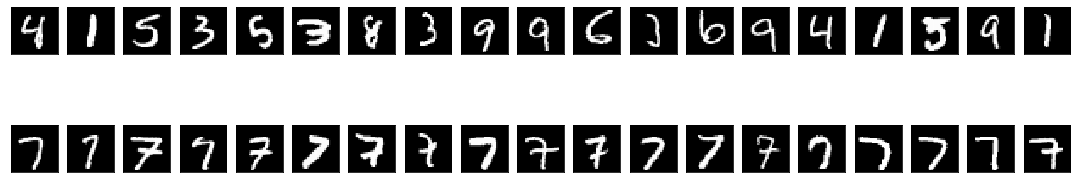

Loading  8
AUC: 0.8862615346635172
confusion_matrix:
[[ 325  260]
 [ 313 5538]]


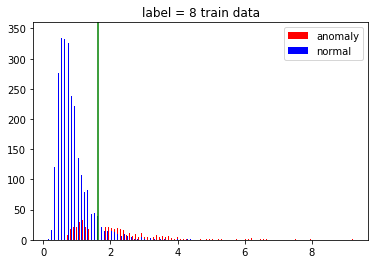

 train label = 8 uncertain_img


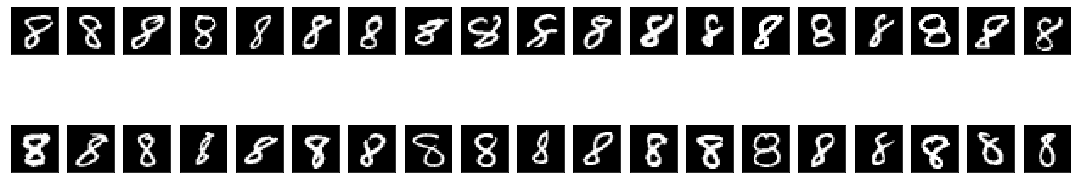

train label = 8 distance oder


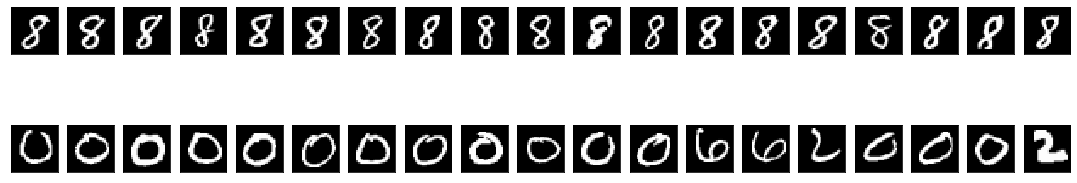

train label = 8 false_img


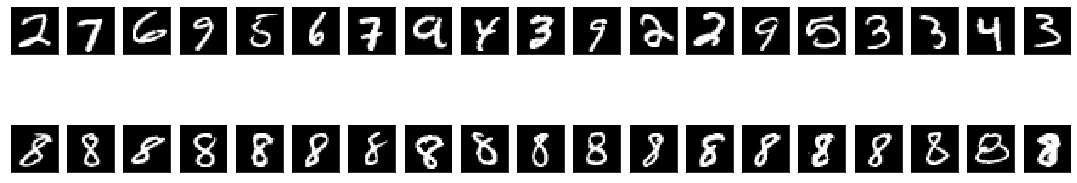

AUC: 0.8906097648090322
confusion_matrix:
[[4551 4475]
 [  40  934]]


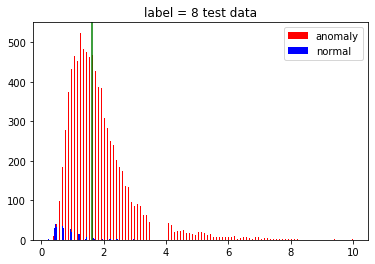

test label = 8 uncertain_img


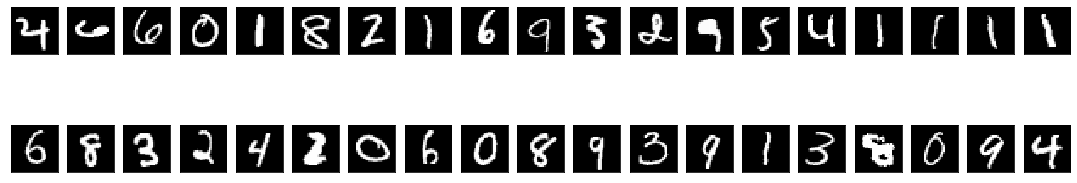

test label = 8 distance oder


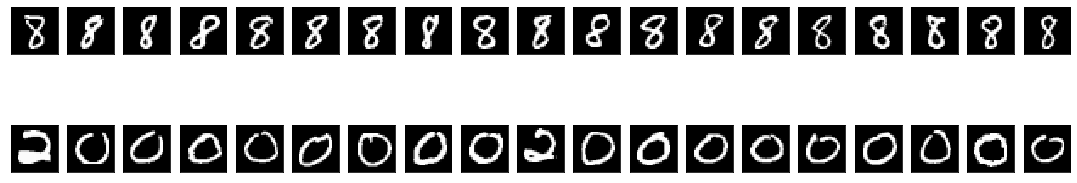

test label = 8 false_img


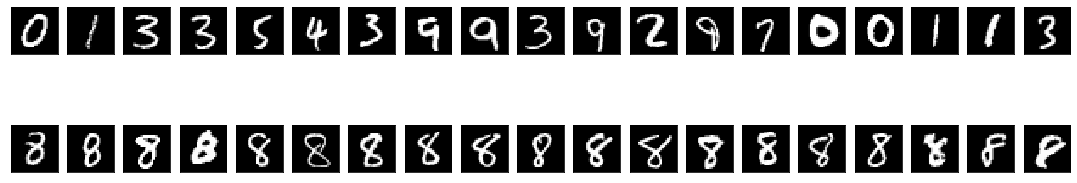

Loading  9
AUC: 0.9289273074783244
confusion_matrix:
[[ 367  227]
 [ 276 5673]]


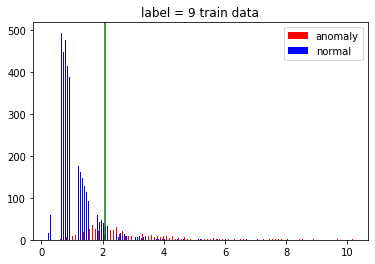

 train label = 9 uncertain_img


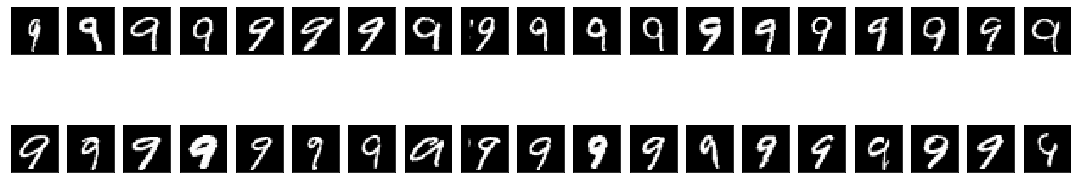

train label = 9 distance oder


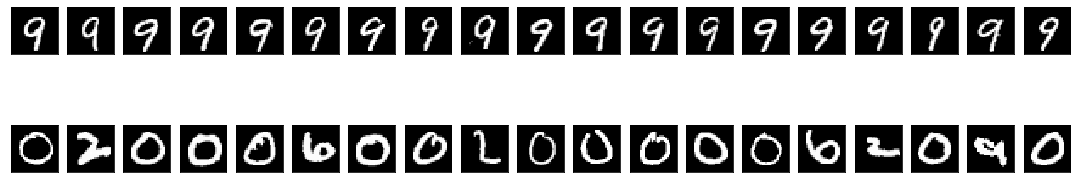

train label = 9 false_img


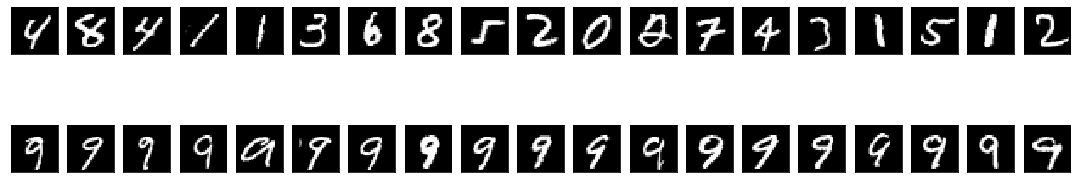

AUC: 0.9345559632972914
confusion_matrix:
[[5666 3325]
 [  38  971]]


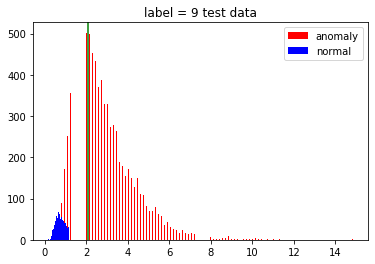

test label = 9 uncertain_img


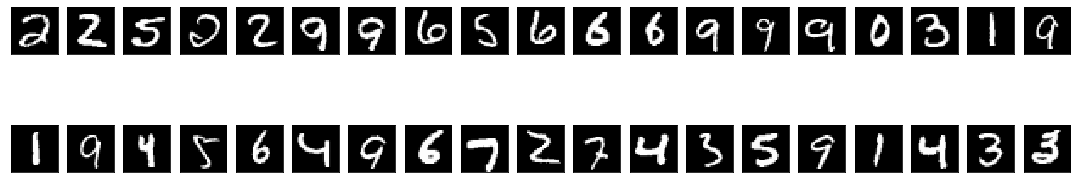

test label = 9 distance oder


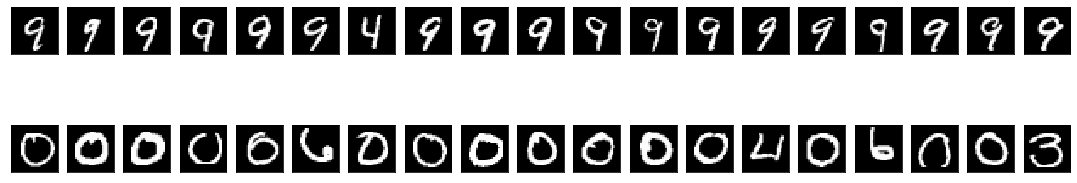

test label = 9 false_img


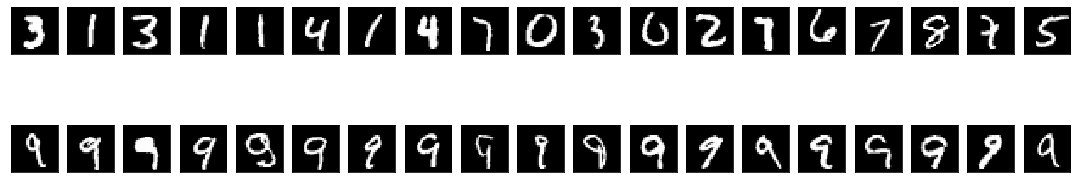

In [81]:
nu = 0.1
outlier_nu = 0.1
lr_milestone = 20
lr_change = 0.25
warm_up_n_epochs = 14
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset,
                                     warm_up_n_epochs, lr_change)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test,  load_model = True, show_img = True)


In [132]:
result = np.zeros((10, 4))
train_confusionmatrix_list = []
test_confusionmatrix_list = []

Loading  0


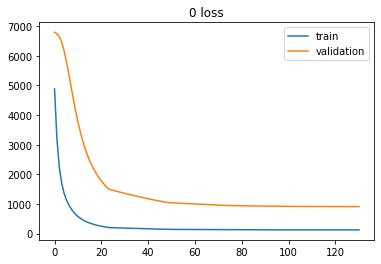

auc =  0.9000209285488031
Loading  1


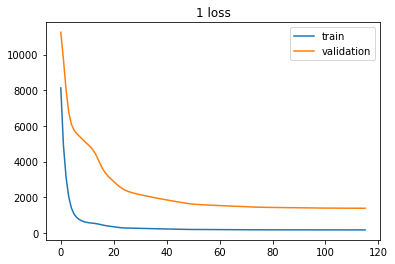

auc =  0.9795980331502147
Loading  2


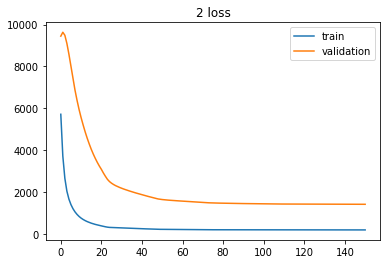

auc =  0.7228755104281198
Loading  3


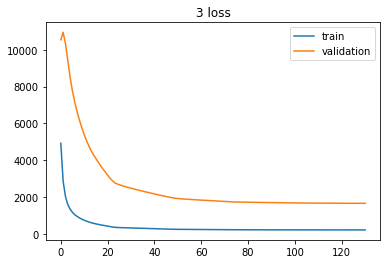

auc =  0.8246521437460765
Loading  4
model converge


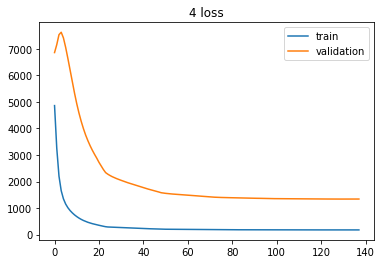

auc =  0.8578316889642305
Loading  5


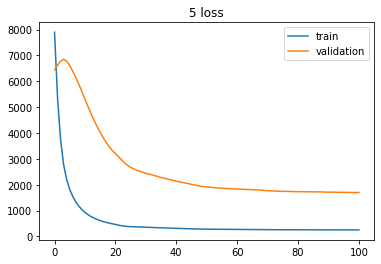

auc =  0.7940245208962307
Loading  6


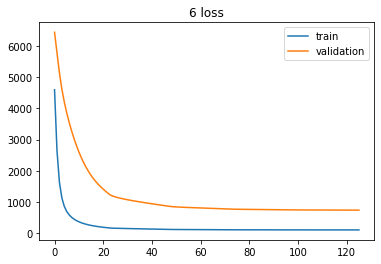

auc =  0.8935921394891573
Loading  7


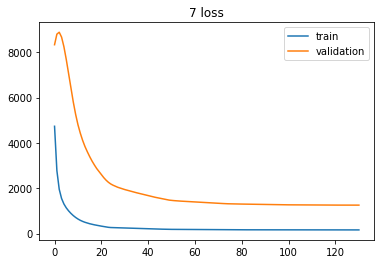

auc =  0.8833622133537803
Loading  8


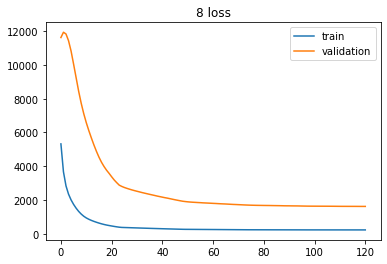

auc =  0.8523100161022391
Loading  9


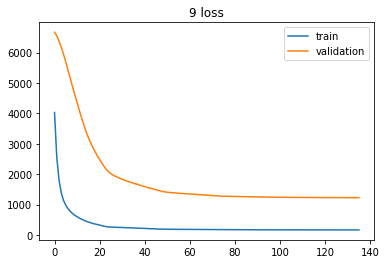

auc =  0.9196493046289325


array([[  0.        ,   0.        ,   0.90002093, 447.24680448],
       [  1.        ,   0.        ,   0.97959803, 538.21045089],
       [  2.        ,   0.        ,   0.72287551, 478.24231911],
       [  3.        ,   0.        ,   0.82465214, 475.26426029],
       [  4.        ,   0.        ,   0.85783169, 453.12416911],
       [  5.        ,   0.        ,   0.79402452, 360.11741257],
       [  6.        ,   0.        ,   0.89359214, 441.04671454],
       [  7.        ,   0.        ,   0.88336221, 499.5430851 ],
       [  8.        ,   0.        ,   0.85231002, 445.21196437],
       [  9.        ,   0.        ,   0.9196493 , 457.01085854]])

In [133]:
nu = 0.2
outlier_nu = 0.2
lr_milestone = 25
lr_change = 0.25
warm_up_n_epochs = 20
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae(n_ae_epochs = 10, train_dataset = train_dataset, ae_lr_milestone = 50)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset,
                                     warm_up_n_epochs, lr_change)
    train_SVDD.train( x_vali, x_novali)
    #train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    test_confusionmatrix_list.append(confusionmatrix)
result

Loading  0
AUC: 0.9174507531336841
confusion_matrix:
[[ 860  324]
 [ 639 5284]]


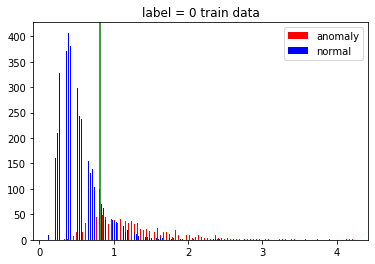

 train label = 0 uncertain_img


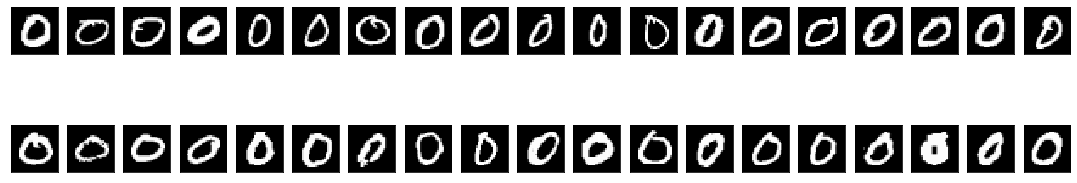

train label = 0 distance oder


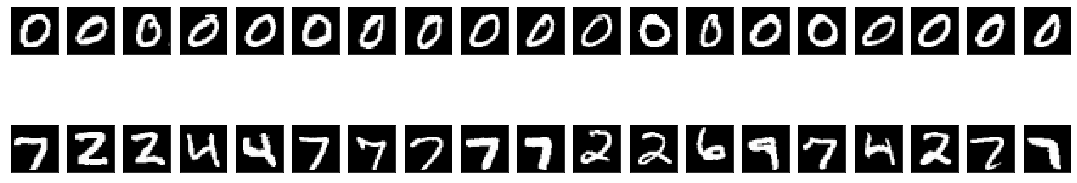

train label = 0 false_img


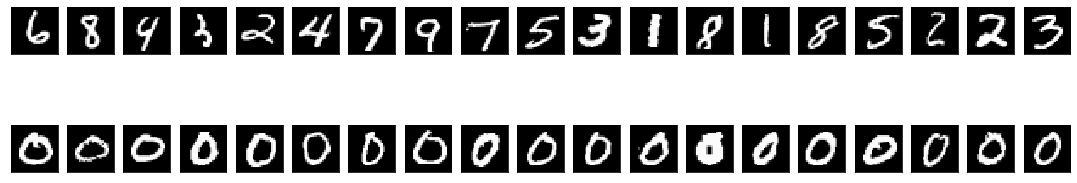

AUC: 0.9000209285488031
confusion_matrix:
[[6460 2560]
 [ 125  855]]


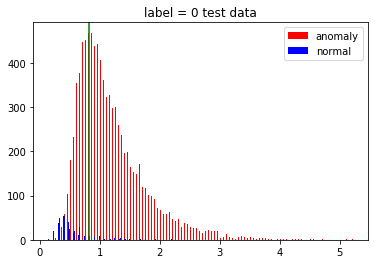

test label = 0 uncertain_img


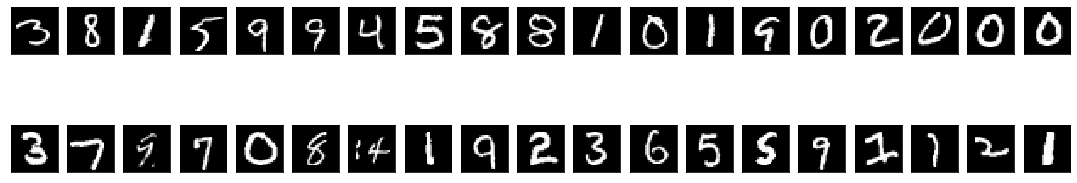

test label = 0 distance oder


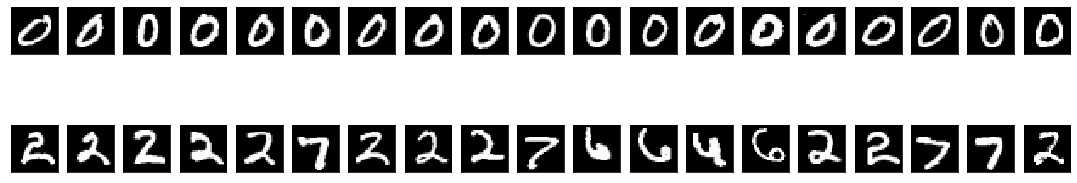

test label = 0 false_img


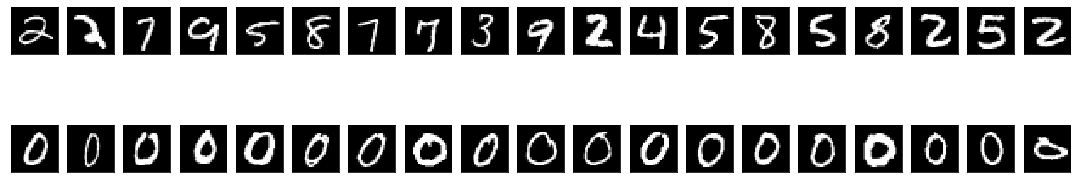

Loading  1
AUC: 0.9797653356830427
confusion_matrix:
[[1222  126]
 [ 397 6345]]


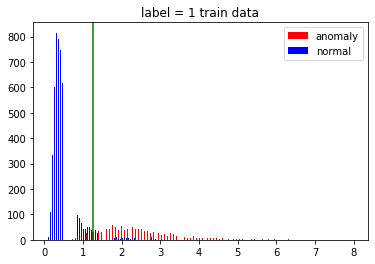

 train label = 1 uncertain_img


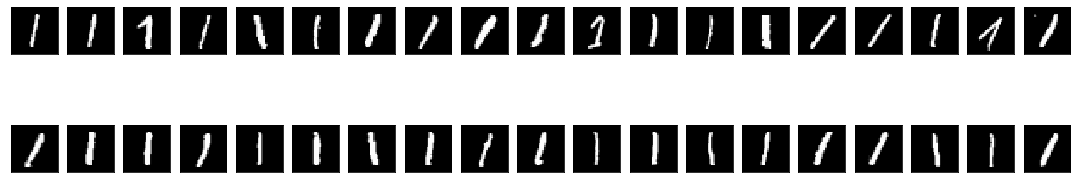

train label = 1 distance oder


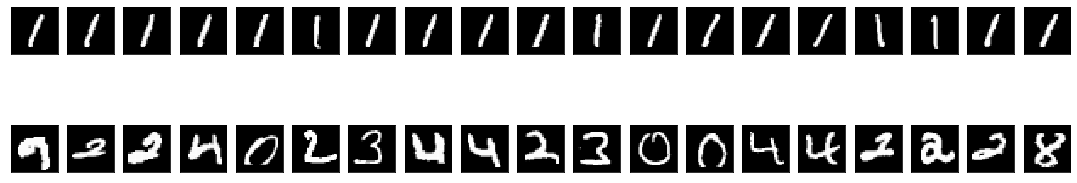

train label = 1 false_img


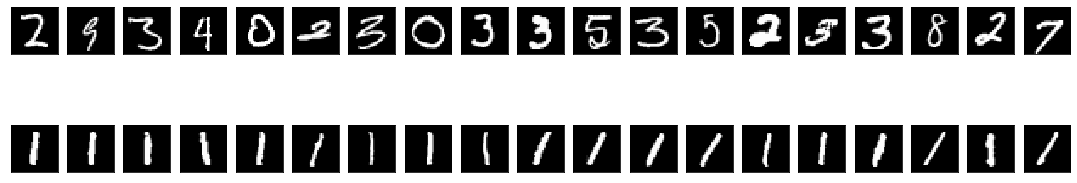

AUC: 0.9795980331502147
confusion_matrix:
[[8006  859]
 [  68 1067]]


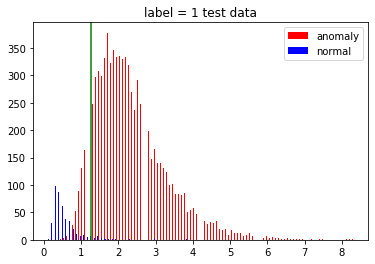

test label = 1 uncertain_img


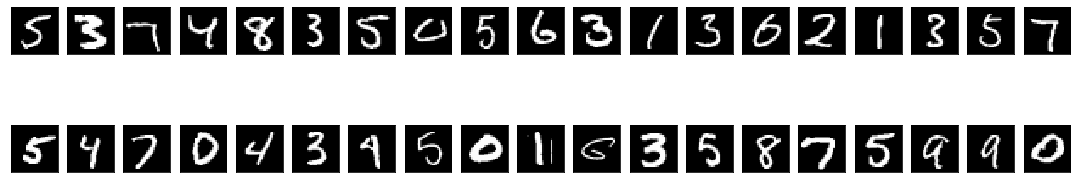

test label = 1 distance oder


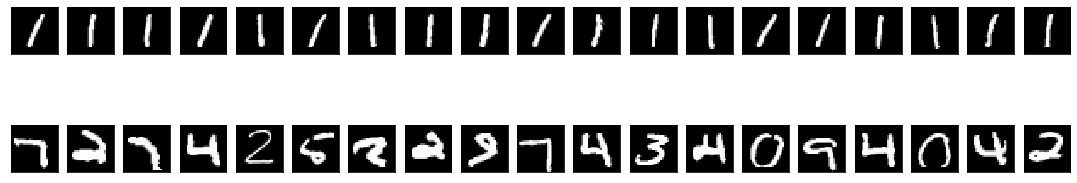

test label = 1 false_img


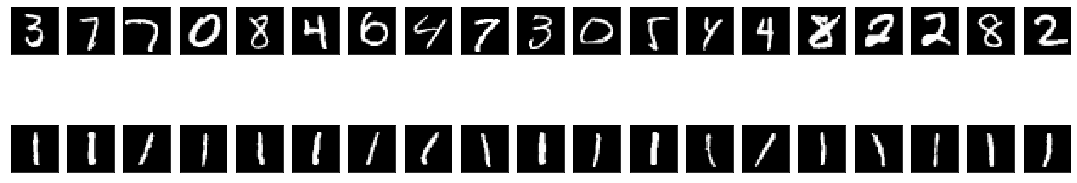

Loading  2
AUC: 0.7065942848188087
confusion_matrix:
[[ 530  661]
 [ 927 5031]]


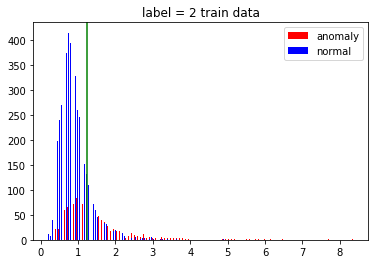

 train label = 2 uncertain_img


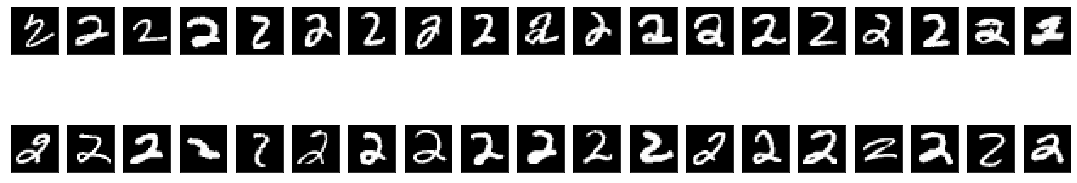

train label = 2 distance oder


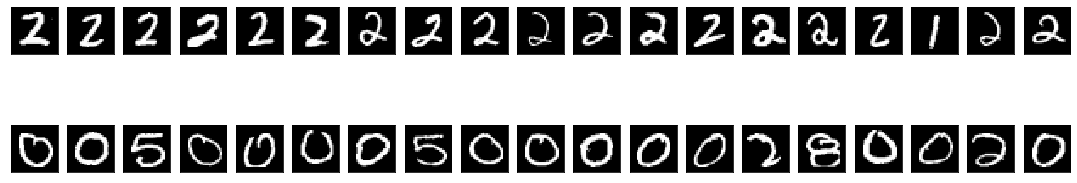

train label = 2 false_img


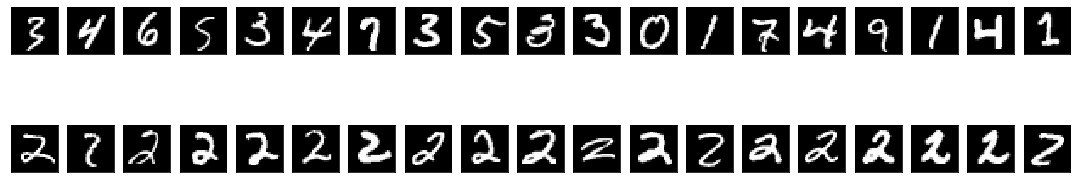

AUC: 0.7228755104281198
confusion_matrix:
[[4106 4862]
 [ 144  888]]


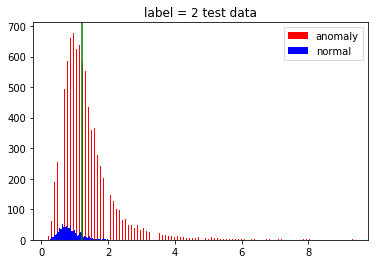

test label = 2 uncertain_img


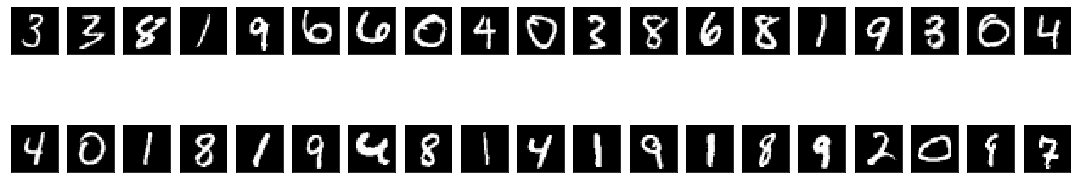

test label = 2 distance oder


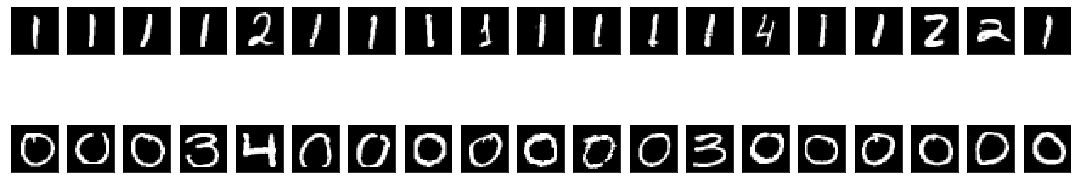

test label = 2 false_img


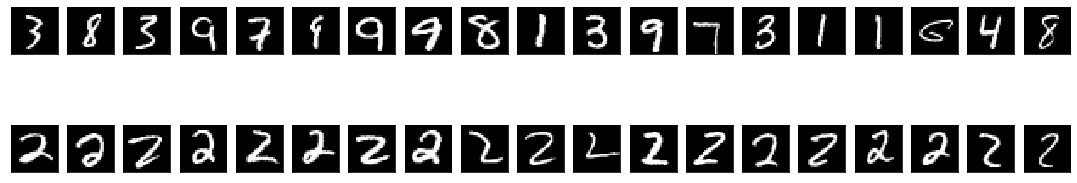

Loading  3
AUC: 0.822510053074486
confusion_matrix:
[[ 703  523]
 [ 809 5322]]


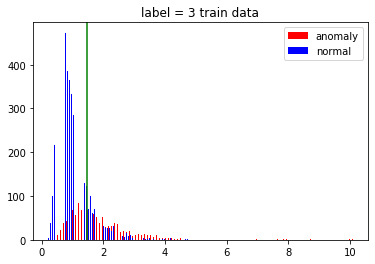

 train label = 3 uncertain_img


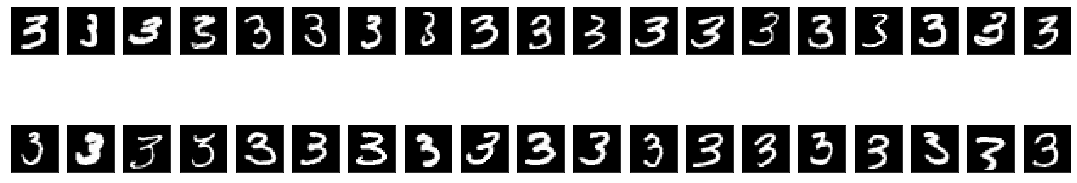

train label = 3 distance oder


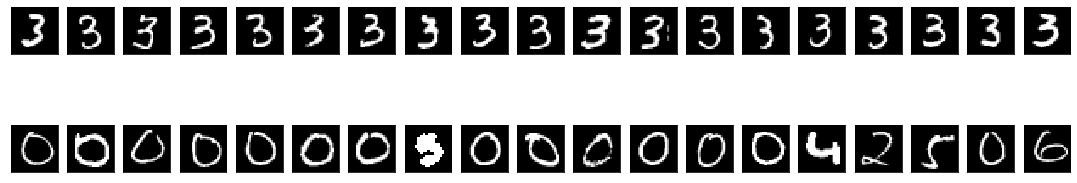

train label = 3 false_img


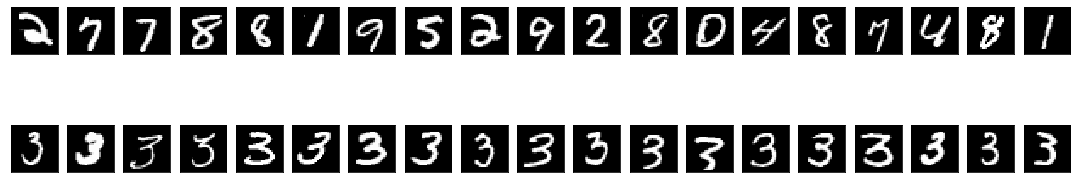

AUC: 0.8246521437460765
confusion_matrix:
[[5022 3968]
 [ 120  890]]


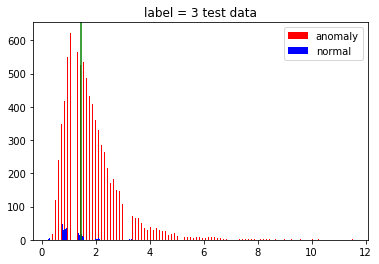

test label = 3 uncertain_img


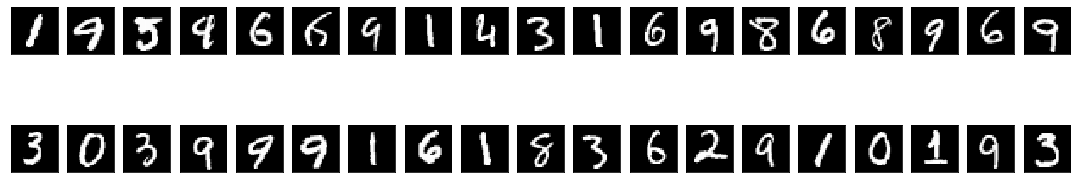

test label = 3 distance oder


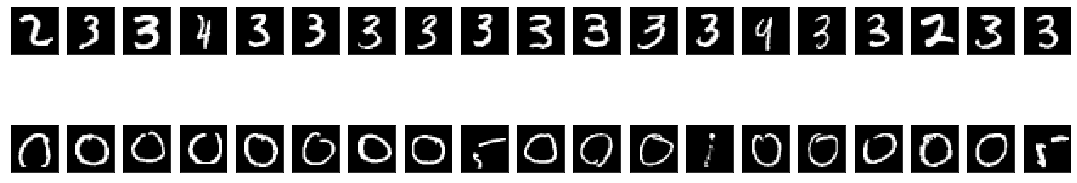

test label = 3 false_img


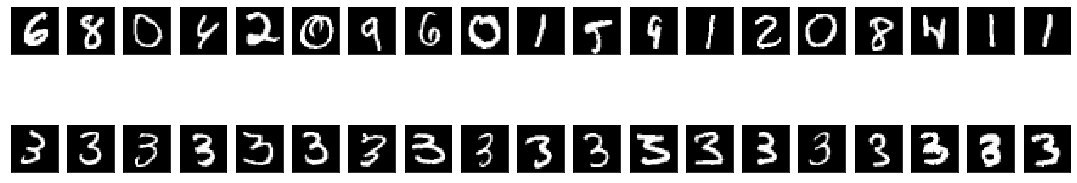

Loading  4
AUC: 0.8512614428817303
confusion_matrix:
[[ 736  432]
 [ 682 5160]]


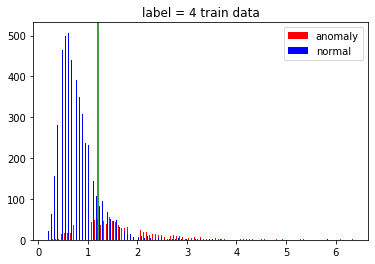

 train label = 4 uncertain_img


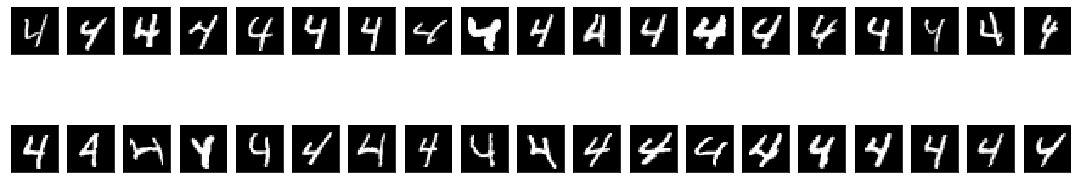

train label = 4 distance oder


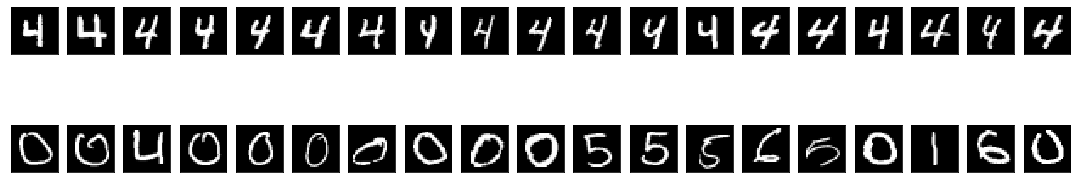

train label = 4 false_img


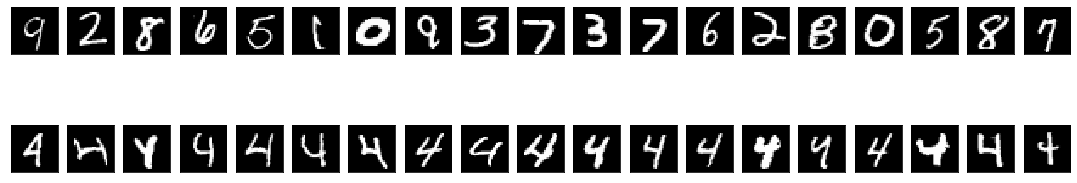

AUC: 0.8578316889642305
confusion_matrix:
[[5691 3327]
 [ 111  871]]


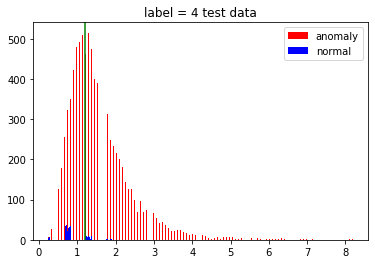

test label = 4 uncertain_img


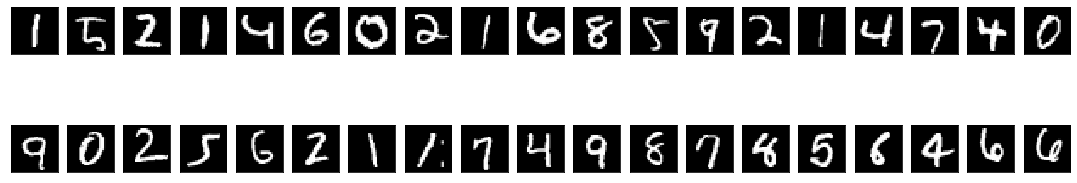

test label = 4 distance oder


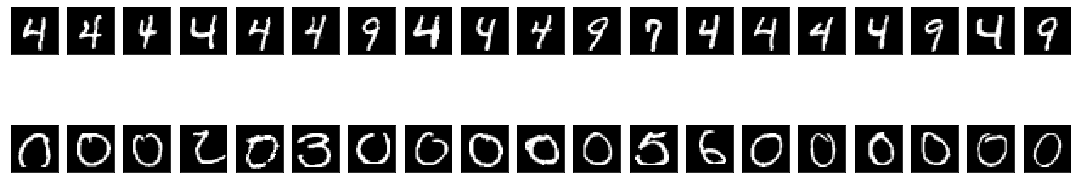

test label = 4 false_img


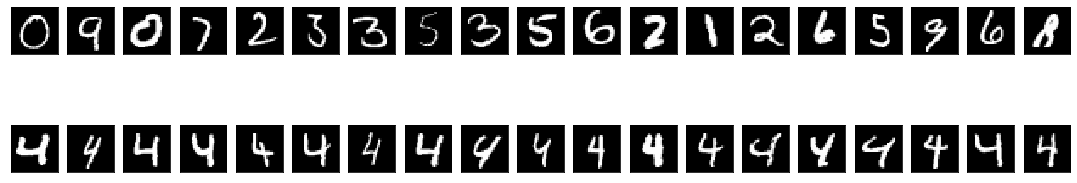

Loading  5
AUC: 0.7678637674589254
confusion_matrix:
[[ 522  562]
 [ 746 4675]]


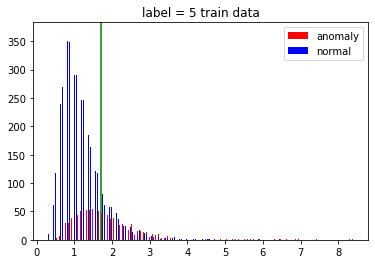

 train label = 5 uncertain_img


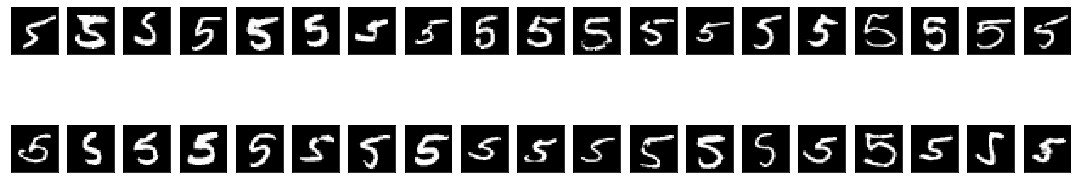

train label = 5 distance oder


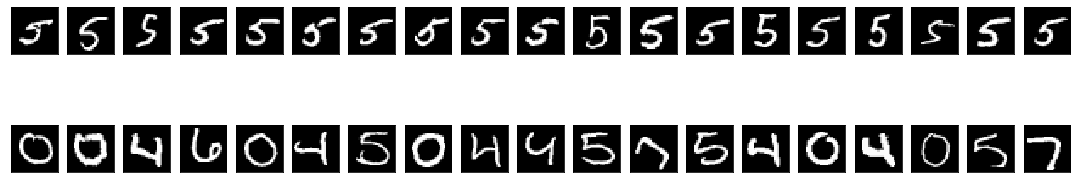

train label = 5 false_img


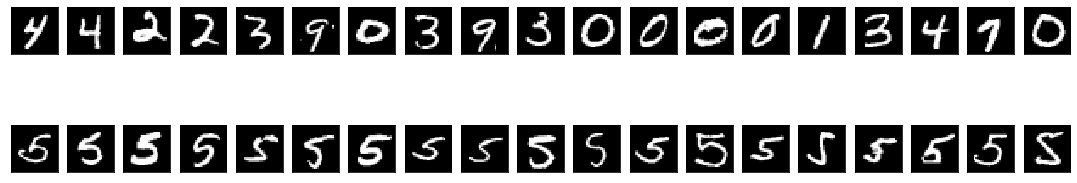

AUC: 0.7940245208962307
confusion_matrix:
[[4704 4404]
 [ 122  770]]


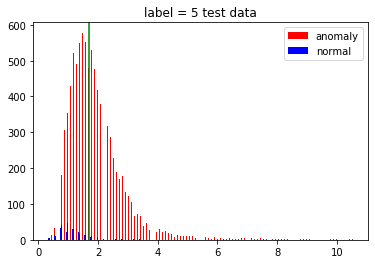

test label = 5 uncertain_img


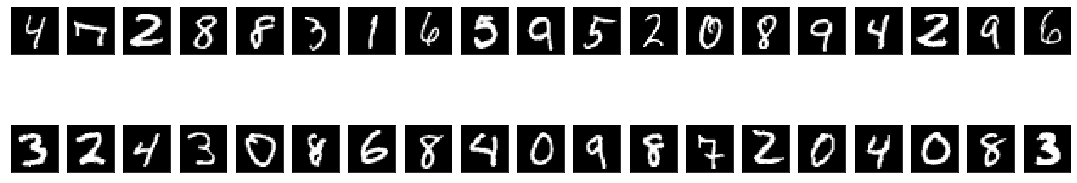

test label = 5 distance oder


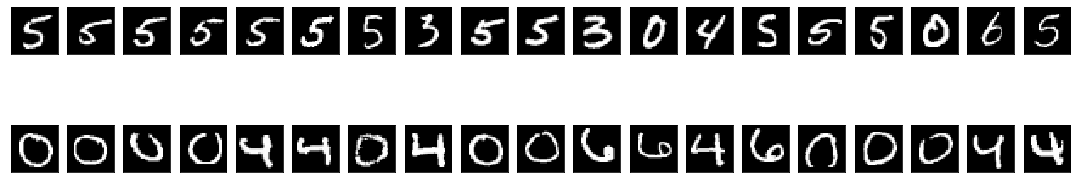

test label = 5 false_img


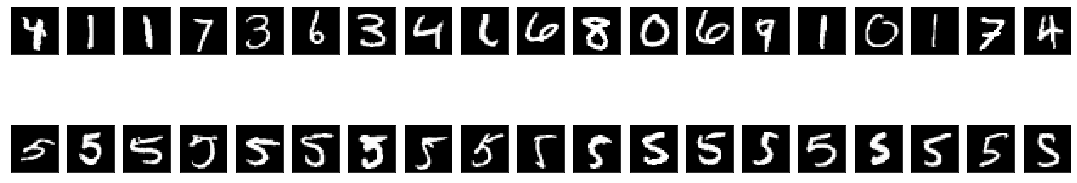

Loading  6
AUC: 0.9087975221804219
confusion_matrix:
[[ 836  347]
 [ 592 5326]]


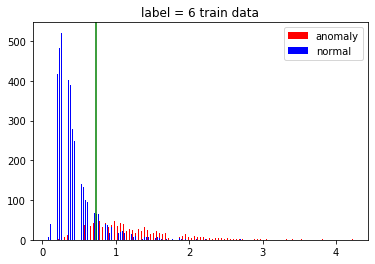

 train label = 6 uncertain_img


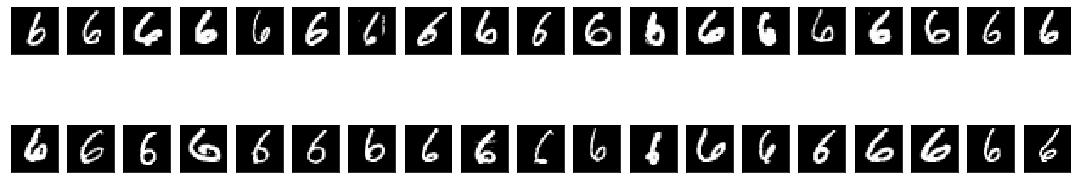

train label = 6 distance oder


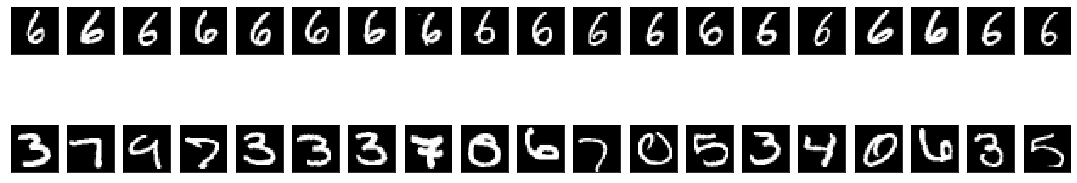

train label = 6 false_img


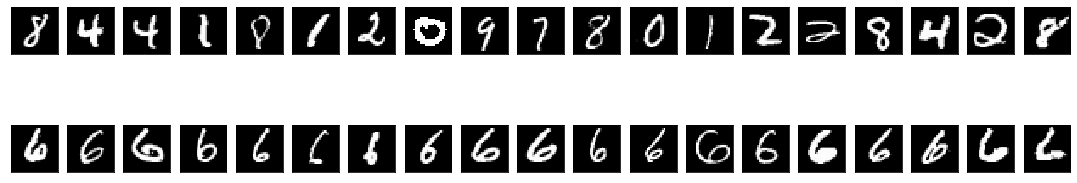

AUC: 0.8935921394891573
confusion_matrix:
[[6081 2961]
 [ 108  850]]


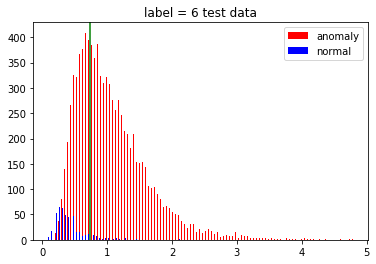

test label = 6 uncertain_img


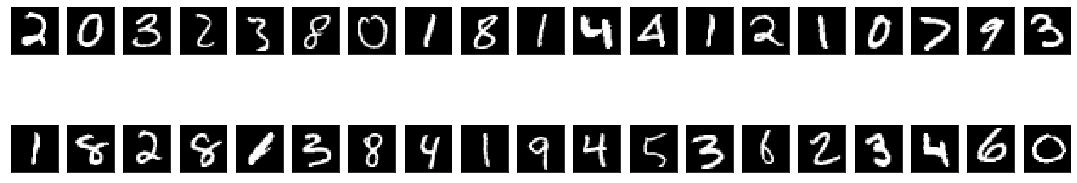

test label = 6 distance oder


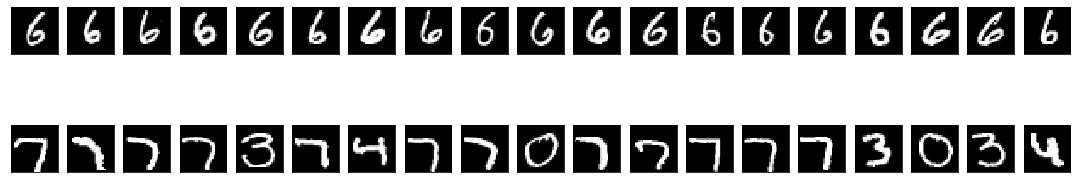

test label = 6 false_img


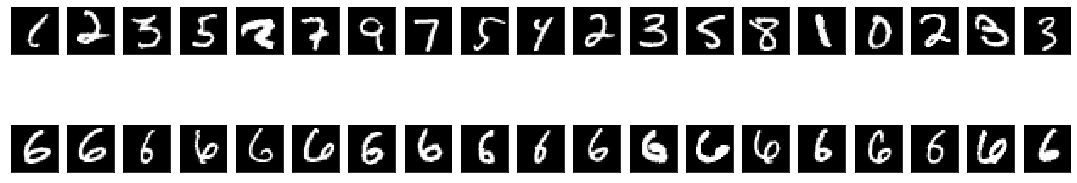

Loading  7
AUC: 0.8661738881751634
confusion_matrix:
[[ 746  507]
 [ 731 5534]]


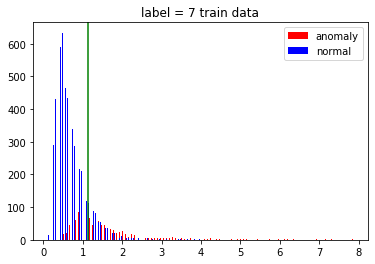

 train label = 7 uncertain_img


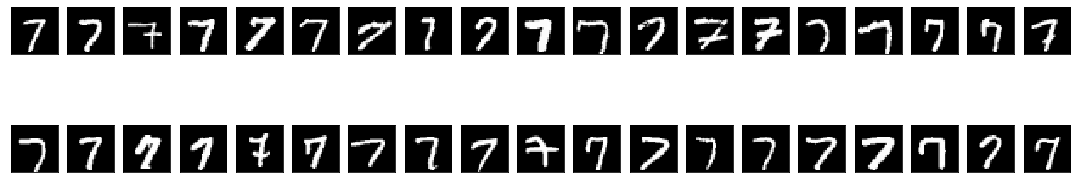

train label = 7 distance oder


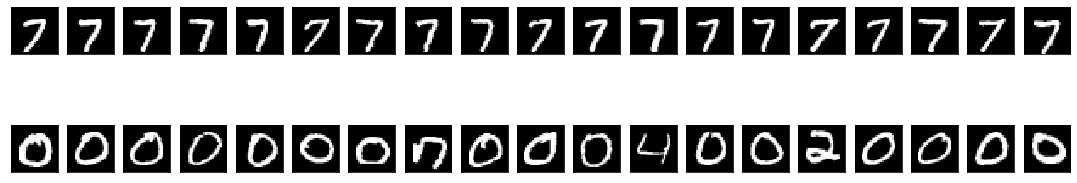

train label = 7 false_img


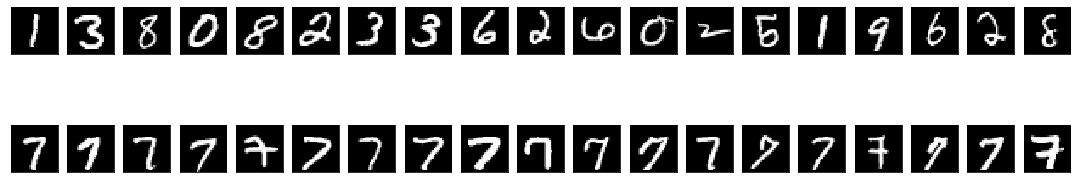

AUC: 0.8833622133537803
confusion_matrix:
[[5717 3255]
 [ 111  917]]


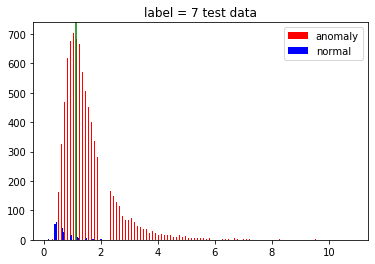

test label = 7 uncertain_img


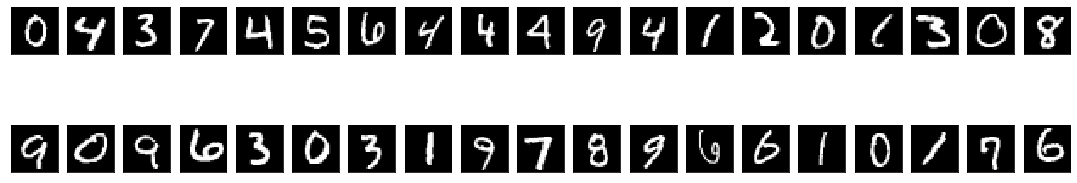

test label = 7 distance oder


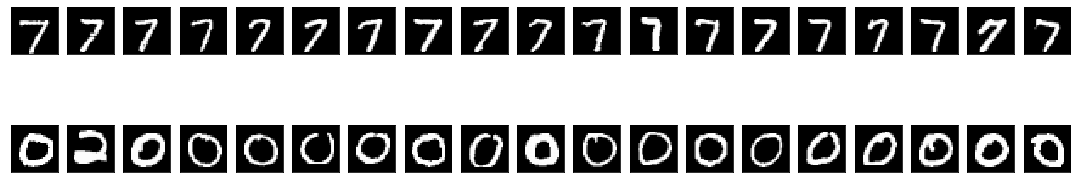

test label = 7 false_img


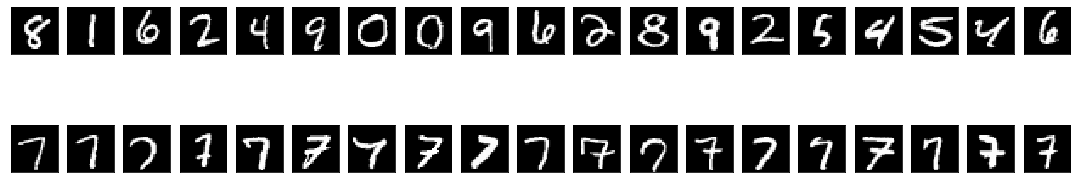

Loading  8
AUC: 0.8675800907727074
confusion_matrix:
[[ 743  427]
 [ 689 5162]]


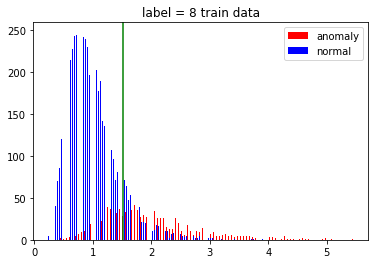

 train label = 8 uncertain_img


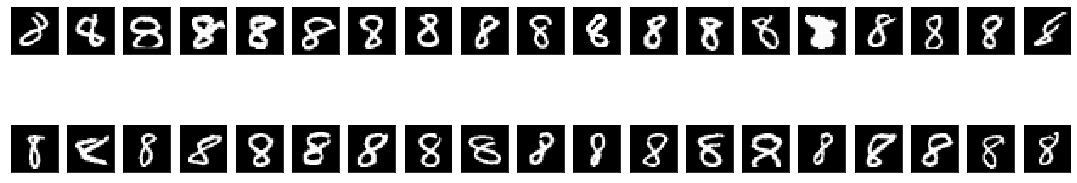

train label = 8 distance oder


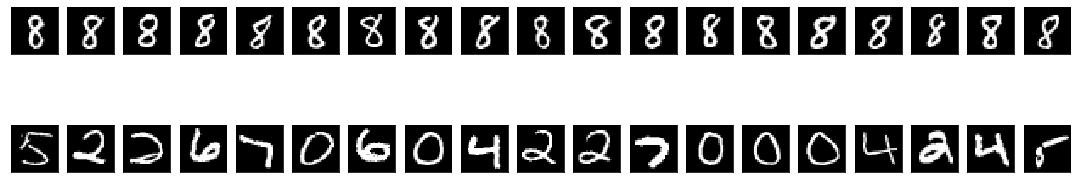

train label = 8 false_img


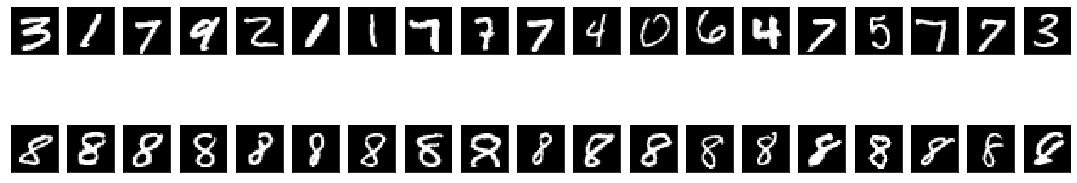

AUC: 0.8523100161022391
confusion_matrix:
[[5491 3535]
 [ 112  862]]


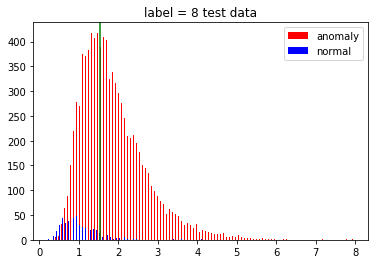

test label = 8 uncertain_img


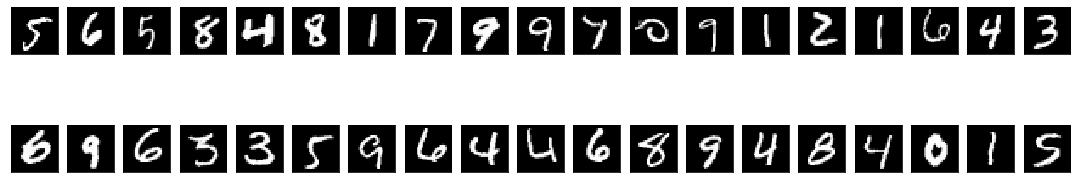

test label = 8 distance oder


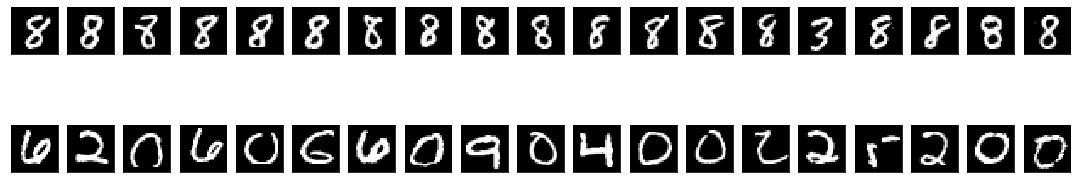

test label = 8 false_img


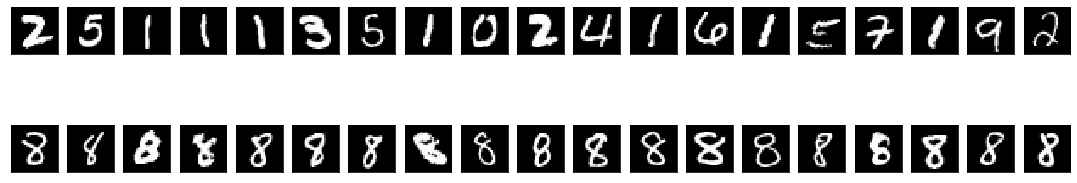

Loading  9
AUC: 0.9080521975338174
confusion_matrix:
[[ 871  318]
 [ 571 5378]]


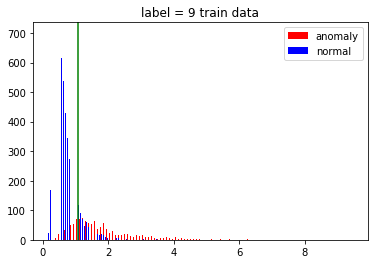

 train label = 9 uncertain_img


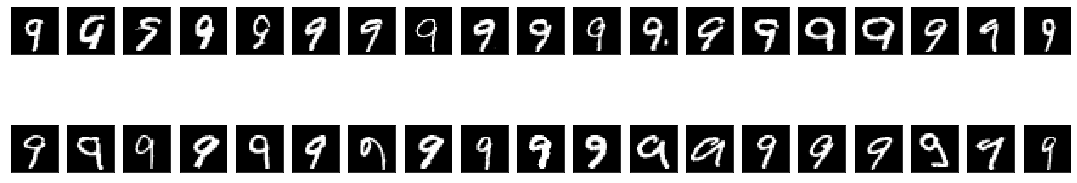

train label = 9 distance oder


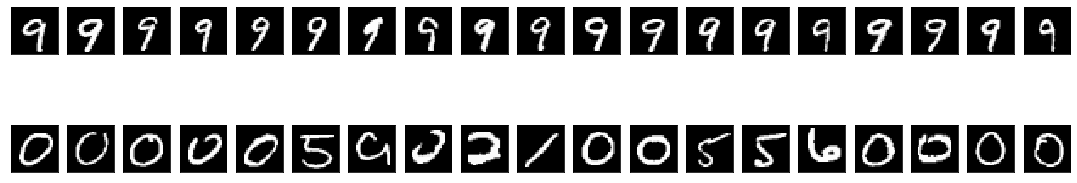

train label = 9 false_img


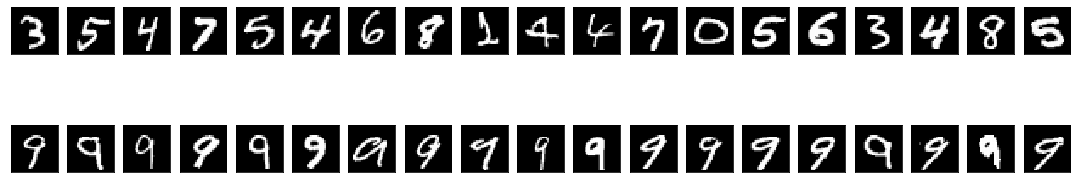

AUC: 0.9196493046289325
confusion_matrix:
[[6610 2381]
 [  78  931]]


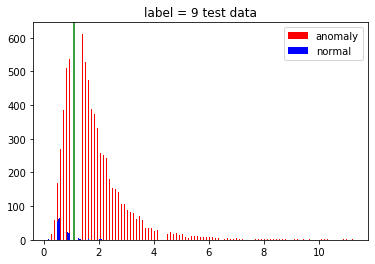

test label = 9 uncertain_img


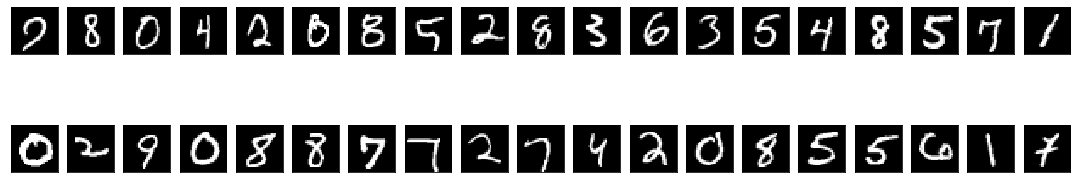

test label = 9 distance oder


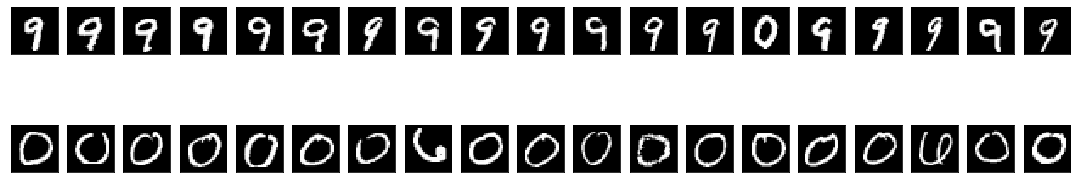

test label = 9 false_img


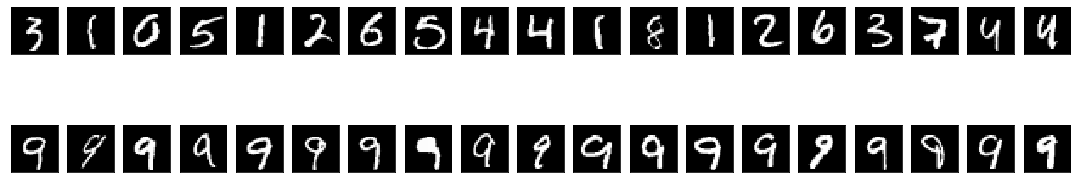

In [134]:
nu = 0.2
outlier_nu = 0.2
lr_milestone = 25
lr_change = 0.25
warm_up_n_epochs = 20
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset,
                                     warm_up_n_epochs, lr_change)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test,  load_model = True, show_img = True)


Loading  0
AUC: 0.9158293444550409
confusion_matrix:
[[1474  302]
 [ 882 5041]]


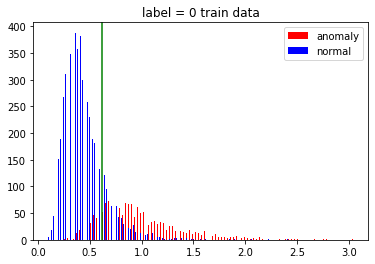

 train label = 0 uncertain_img


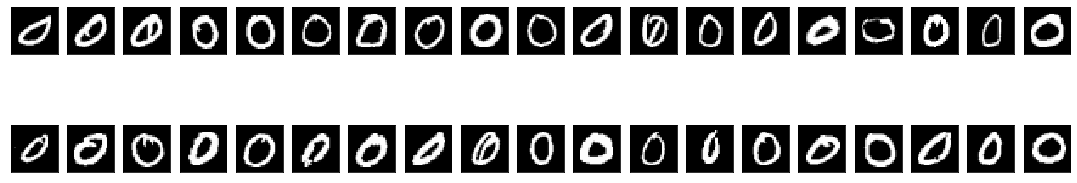

train label = 0 distance oder


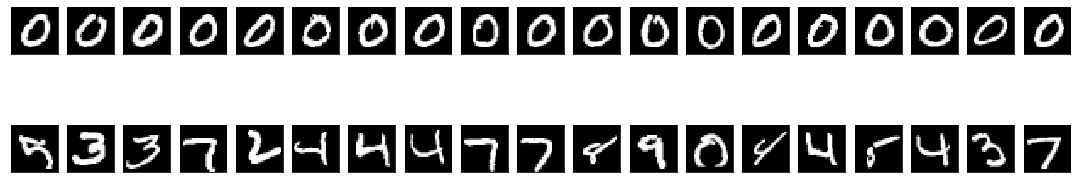

train label = 0 false_img


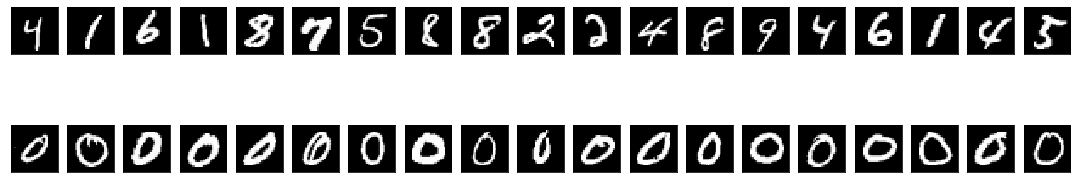

AUC: 0.9105485542332233
confusion_matrix:
[[7362 1658]
 [ 141  839]]


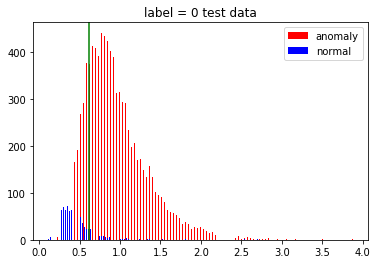

test label = 0 uncertain_img


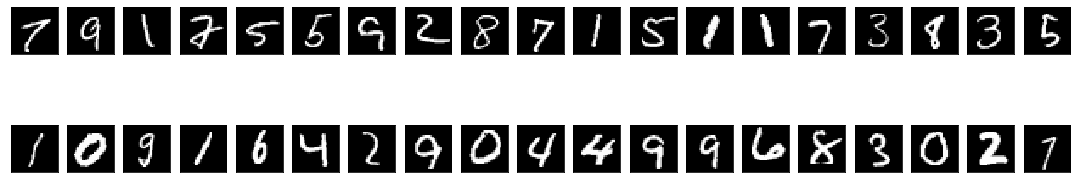

test label = 0 distance oder


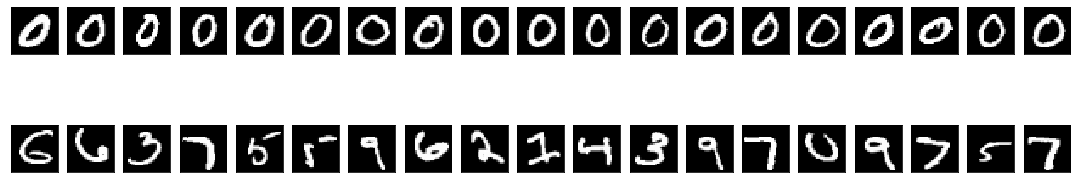

test label = 0 false_img


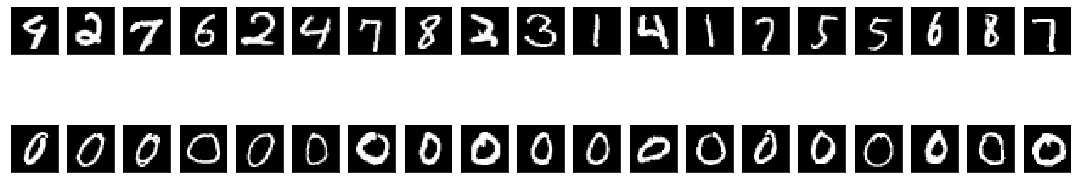

Loading  1
AUC: 0.9795154516573991
confusion_matrix:
[[1976   46]
 [ 652 6090]]


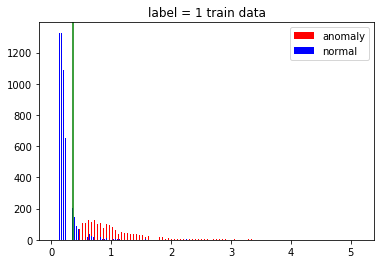

 train label = 1 uncertain_img


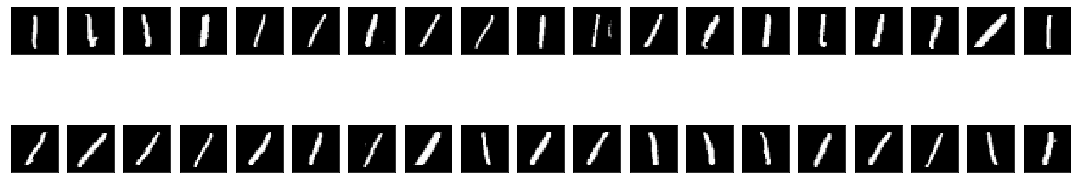

train label = 1 distance oder


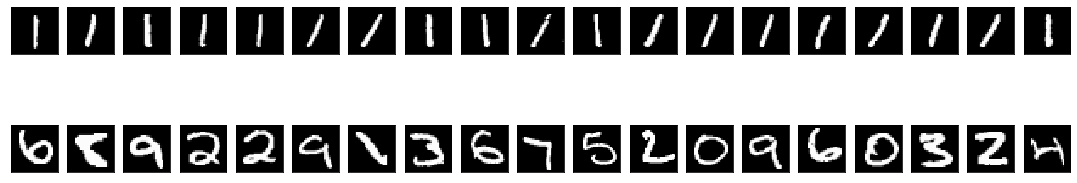

train label = 1 false_img


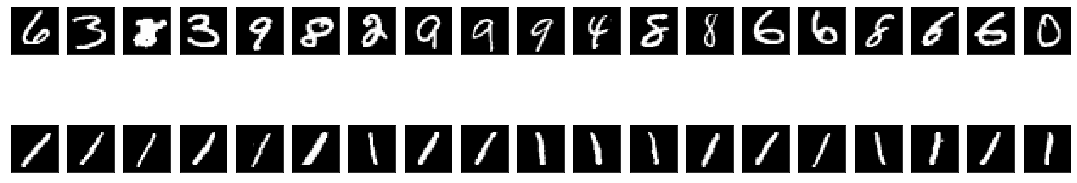

AUC: 0.983812299519717
confusion_matrix:
[[8669  196]
 [ 116 1019]]


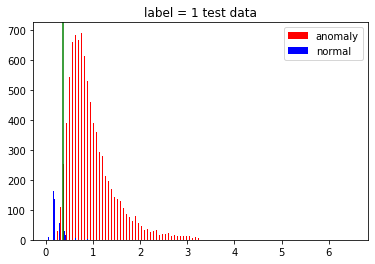

test label = 1 uncertain_img


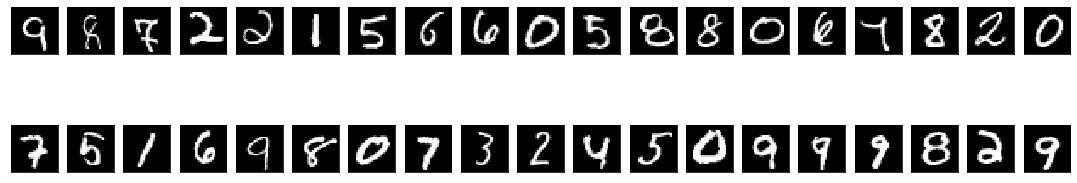

test label = 1 distance oder


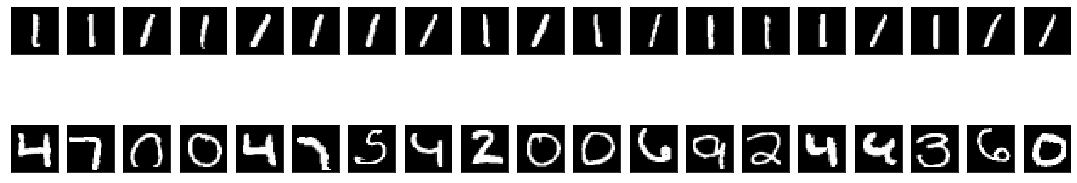

test label = 1 false_img


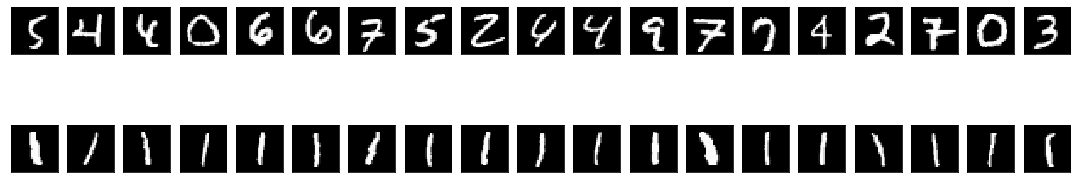

Loading  2
AUC: 0.7078520920459257
confusion_matrix:
[[ 935  852]
 [1424 4534]]


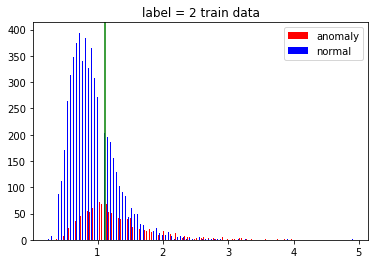

 train label = 2 uncertain_img


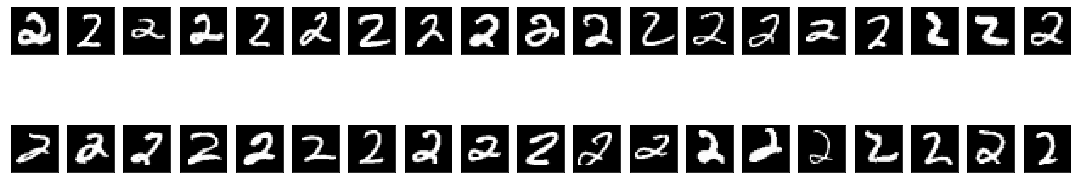

train label = 2 distance oder


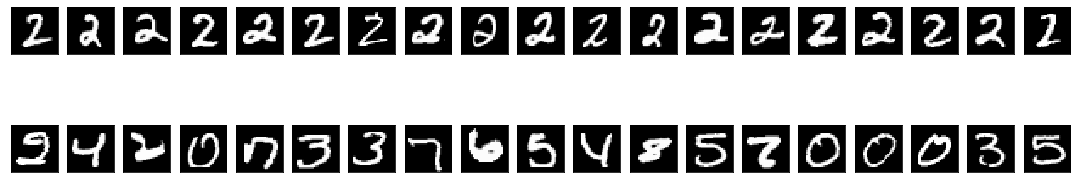

train label = 2 false_img


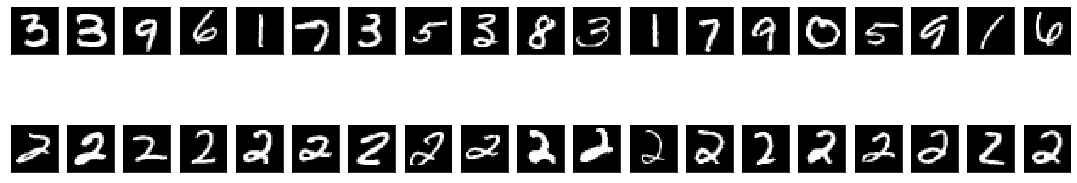

AUC: 0.7158080690862948
confusion_matrix:
[[4536 4432]
 [ 213  819]]


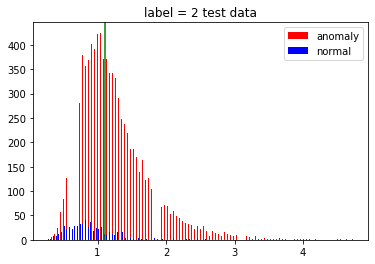

test label = 2 uncertain_img


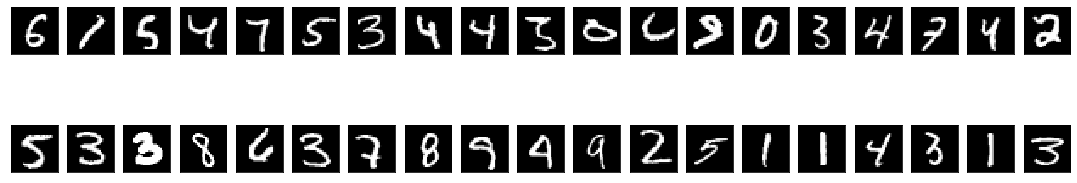

test label = 2 distance oder


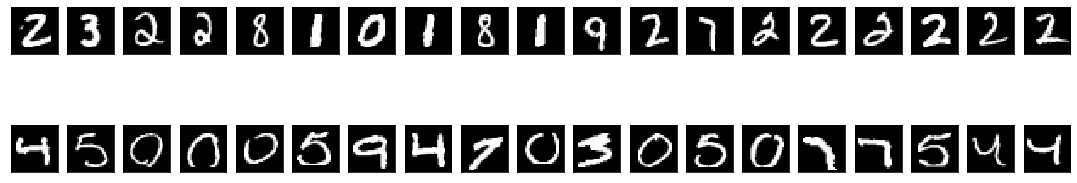

test label = 2 false_img


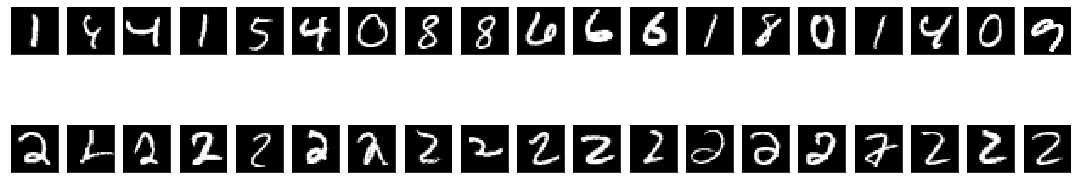

Loading  3
AUC: 0.7504694716383078
confusion_matrix:
[[1070  769]
 [1347 4784]]


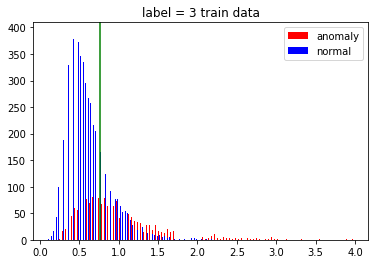

 train label = 3 uncertain_img


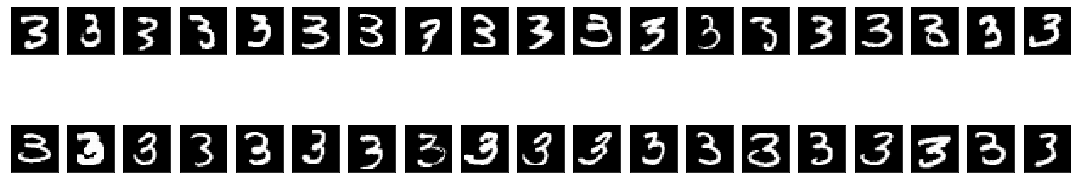

train label = 3 distance oder


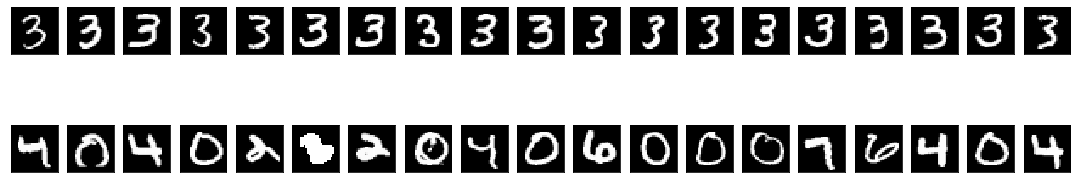

train label = 3 false_img


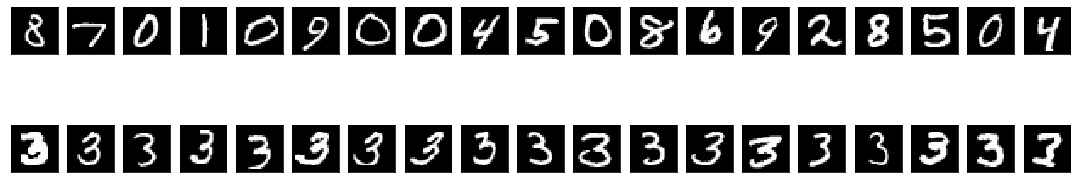

AUC: 0.763827189726759
confusion_matrix:
[[5220 3770]
 [ 199  811]]


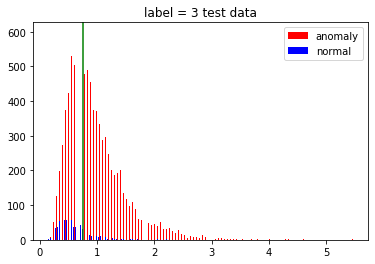

test label = 3 uncertain_img


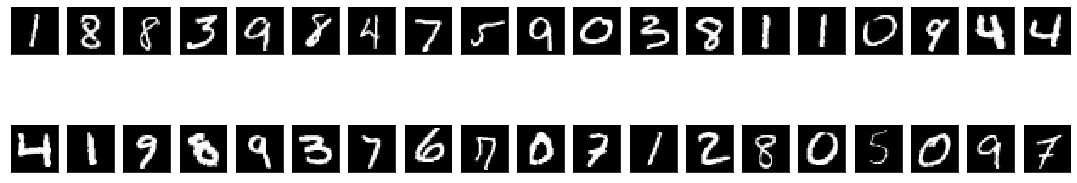

test label = 3 distance oder


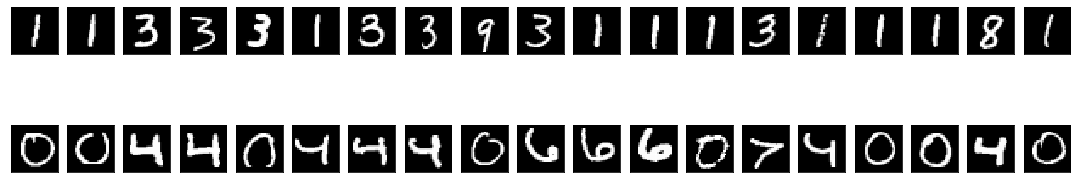

test label = 3 false_img


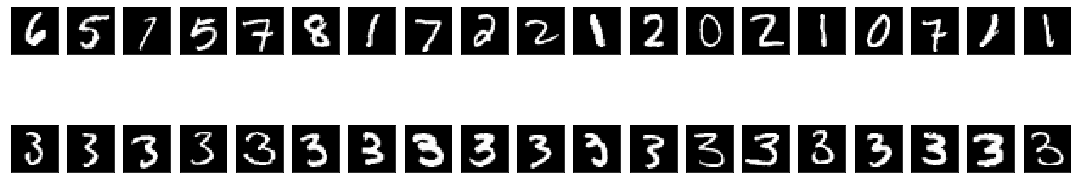

Loading  4
AUC: 0.7897288412206367
confusion_matrix:
[[1101  651]
 [1122 4720]]


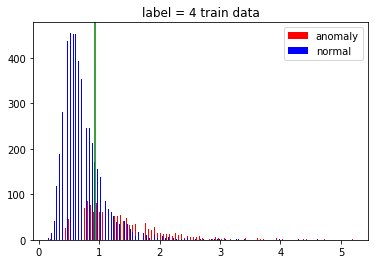

 train label = 4 uncertain_img


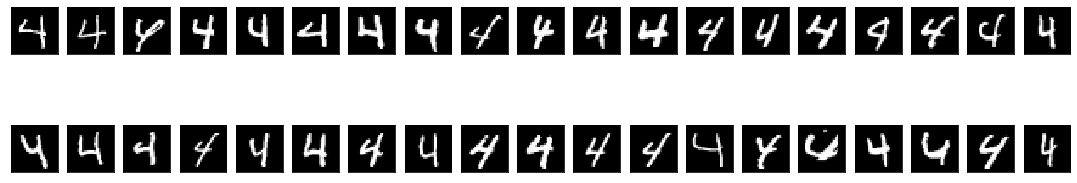

train label = 4 distance oder


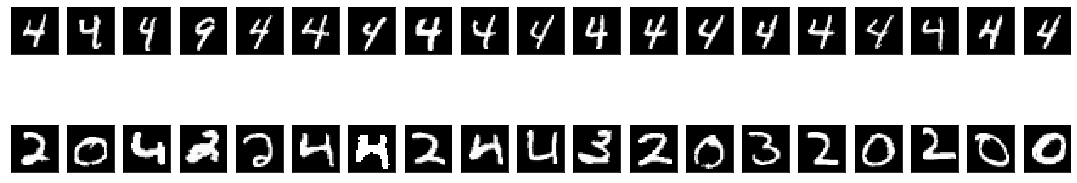

train label = 4 false_img


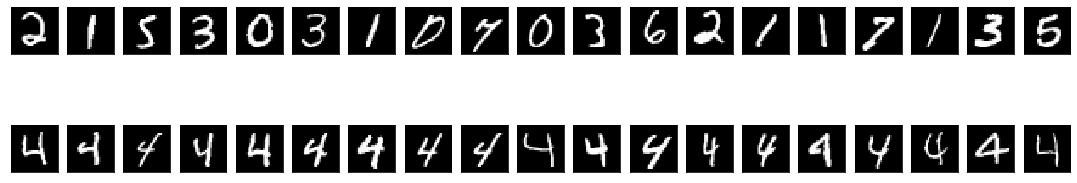

AUC: 0.8074406742071412
confusion_matrix:
[[5666 3352]
 [ 162  820]]


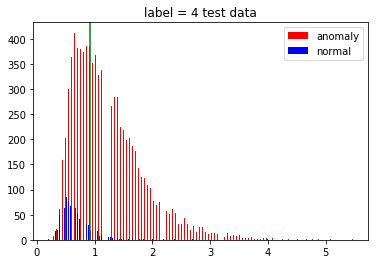

test label = 4 uncertain_img


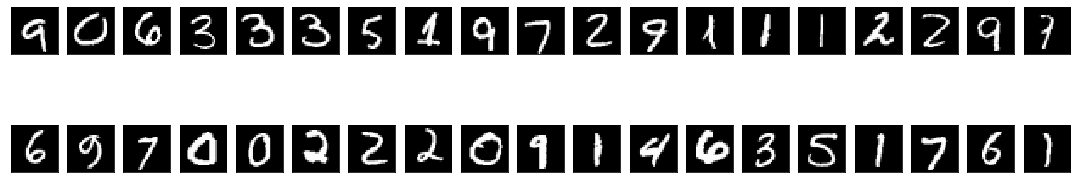

test label = 4 distance oder


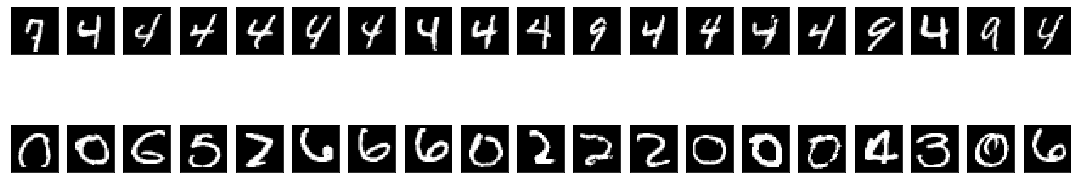

test label = 4 false_img


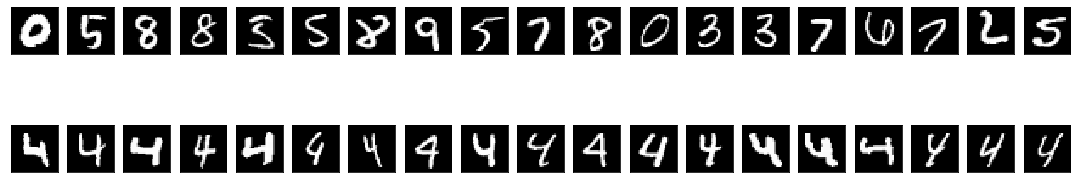

Loading  5
AUC: 0.7570547025337437
confusion_matrix:
[[ 946  680]
 [1138 4283]]


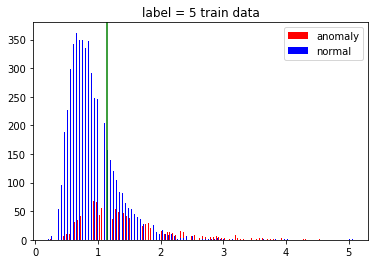

 train label = 5 uncertain_img


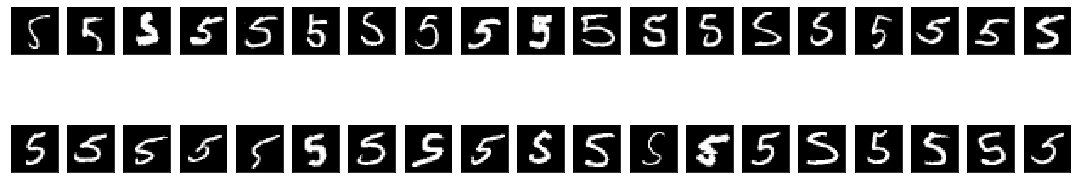

train label = 5 distance oder


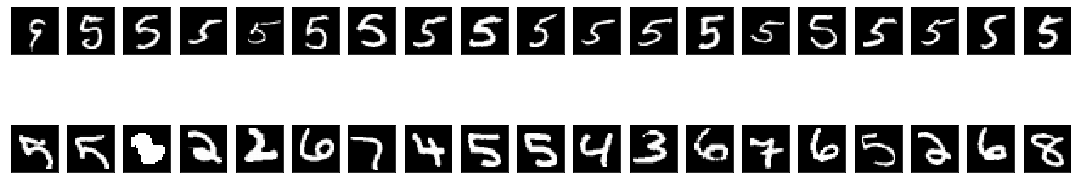

train label = 5 false_img


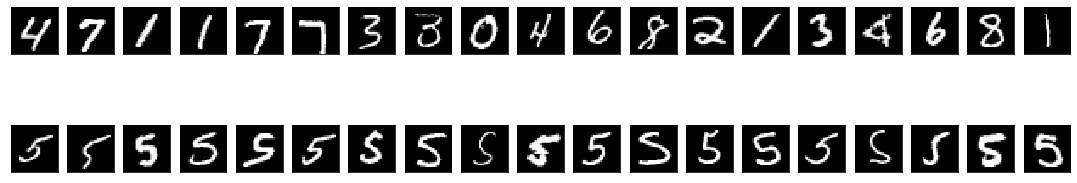

AUC: 0.7591211146363223
confusion_matrix:
[[5402 3706]
 [ 188  704]]


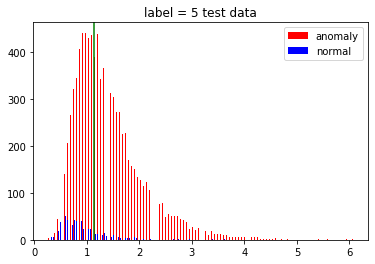

test label = 5 uncertain_img


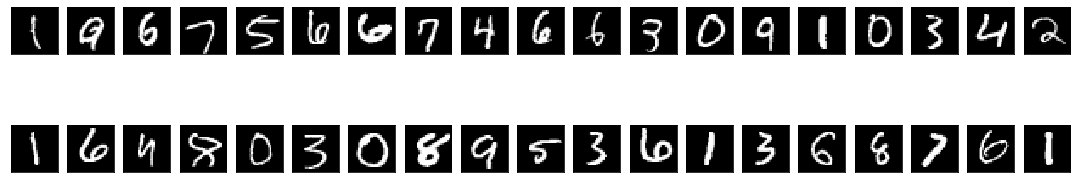

test label = 5 distance oder


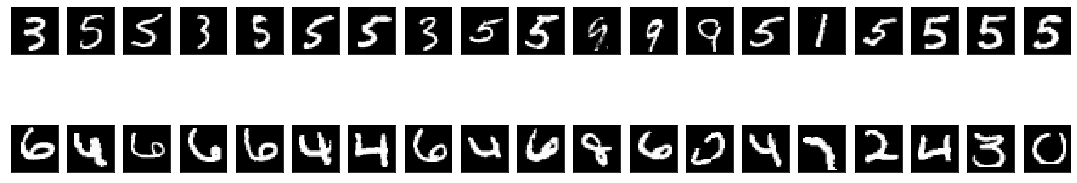

test label = 5 false_img


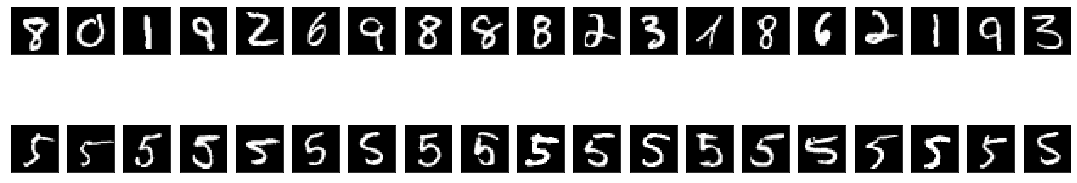

Loading  6
AUC: 0.8402539399968585
confusion_matrix:
[[1232  543]
 [1092 4826]]


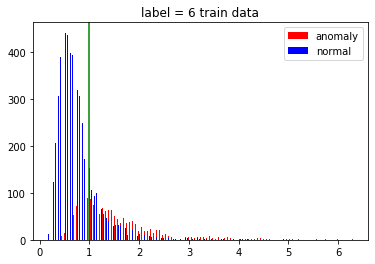

 train label = 6 uncertain_img


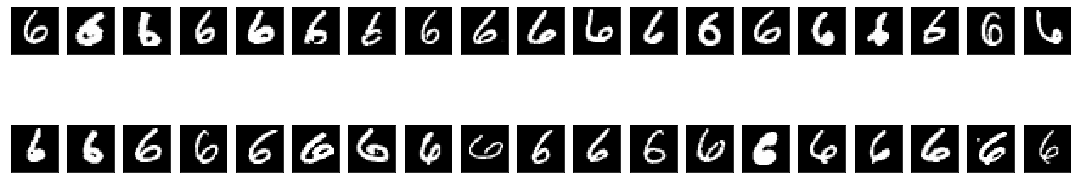

train label = 6 distance oder


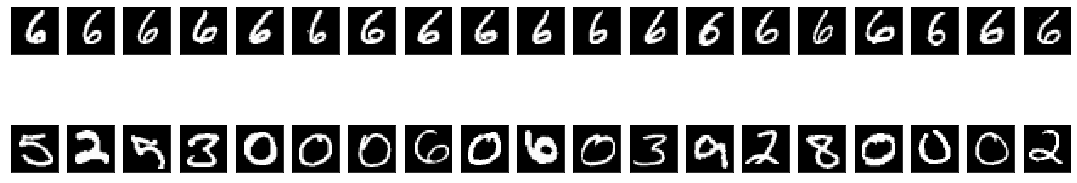

train label = 6 false_img


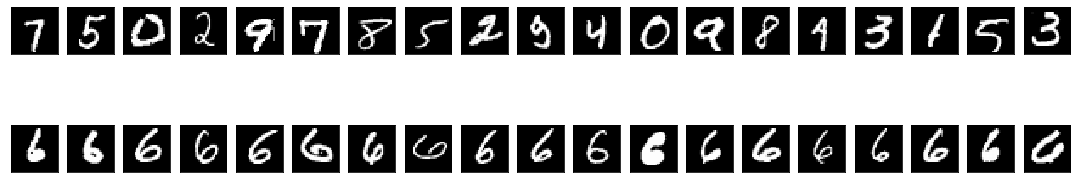

AUC: 0.828539305555748
confusion_matrix:
[[6345 2697]
 [ 210  748]]


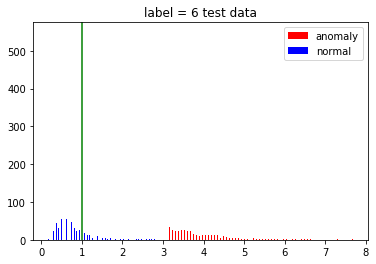

test label = 6 uncertain_img


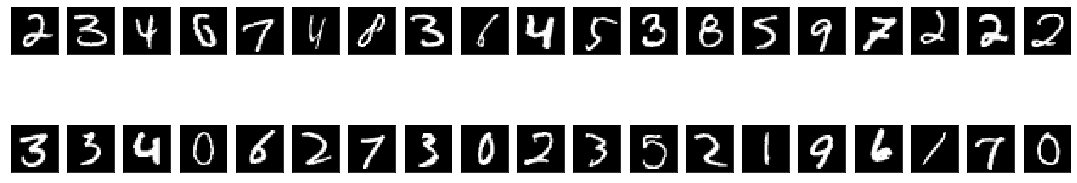

test label = 6 distance oder


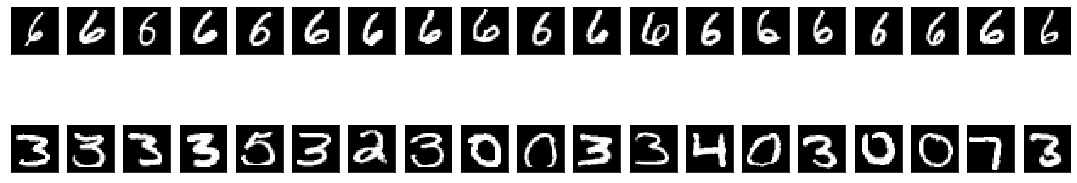

test label = 6 false_img


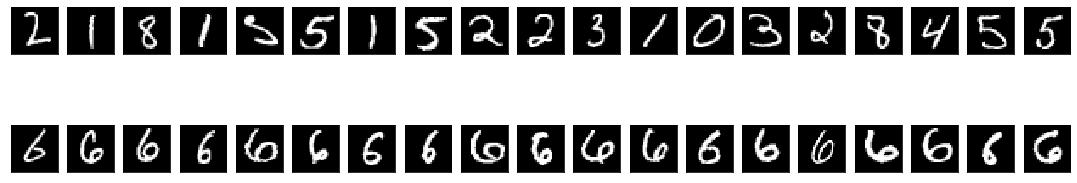

Loading  7
AUC: 0.8664237442697398
confusion_matrix:
[[1379  500]
 [1089 5176]]


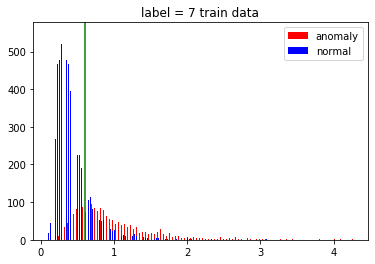

 train label = 7 uncertain_img


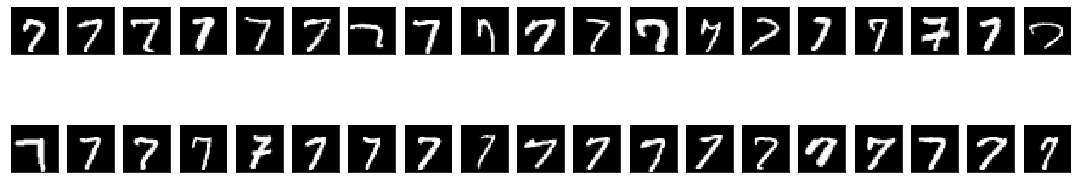

train label = 7 distance oder


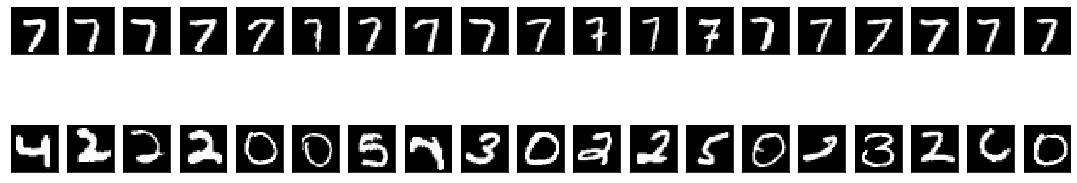

train label = 7 false_img


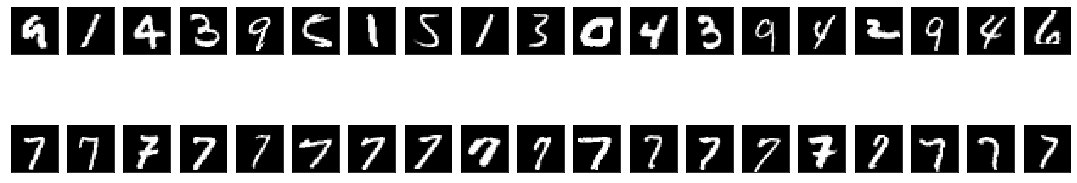

AUC: 0.8691208142582805
confusion_matrix:
[[6517 2455]
 [ 155  873]]


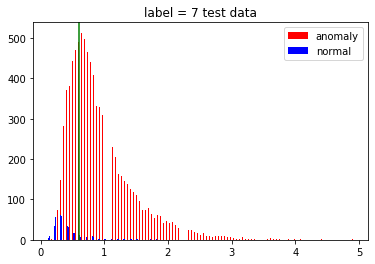

test label = 7 uncertain_img


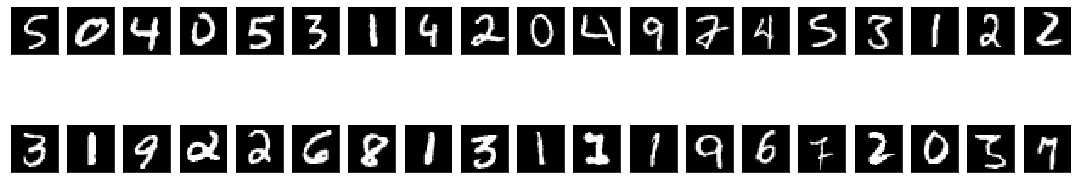

test label = 7 distance oder


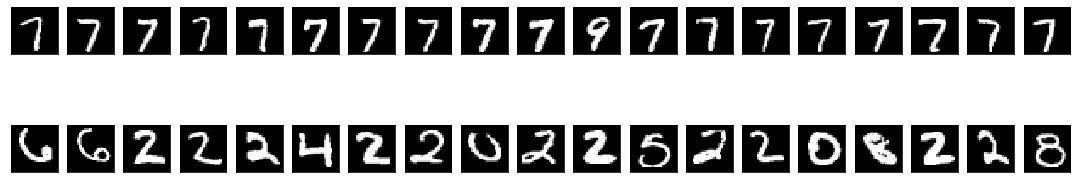

test label = 7 false_img


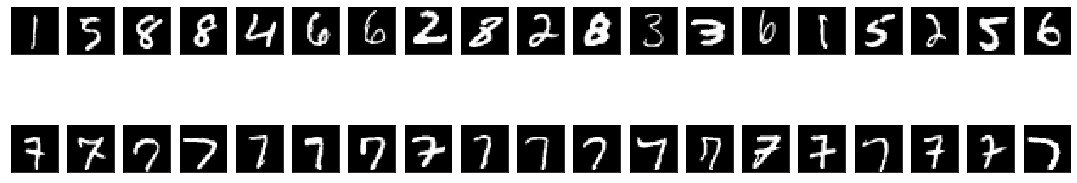

Loading  8
AUC: 0.7760133047605275
confusion_matrix:
[[1094  661]
 [1251 4600]]


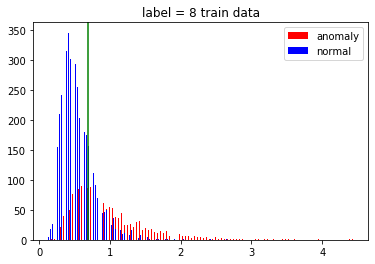

 train label = 8 uncertain_img


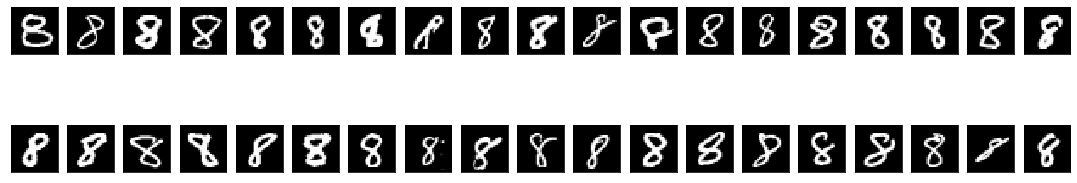

train label = 8 distance oder


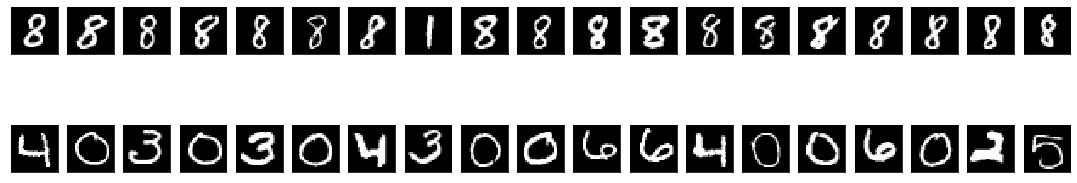

train label = 8 false_img


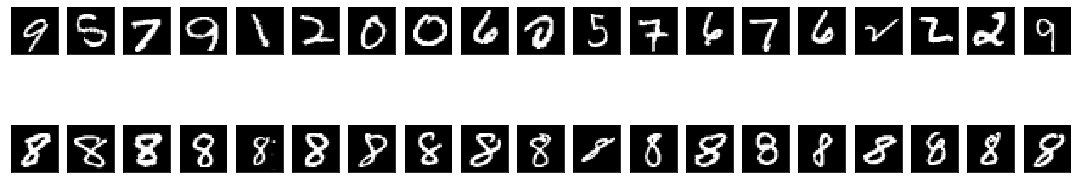

AUC: 0.7614576598473677
confusion_matrix:
[[5423 3603]
 [ 198  776]]


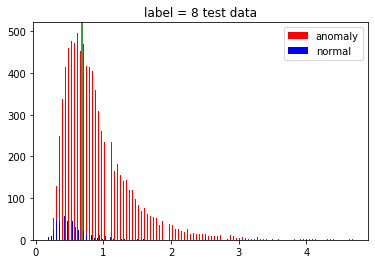

test label = 8 uncertain_img


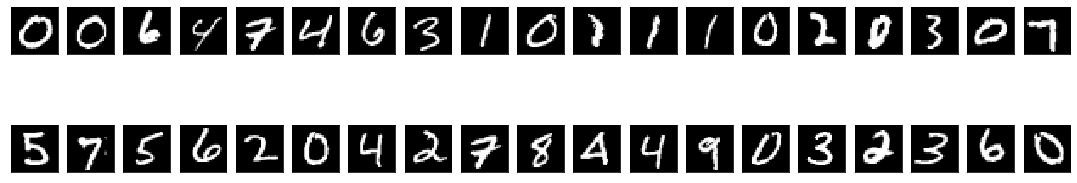

test label = 8 distance oder


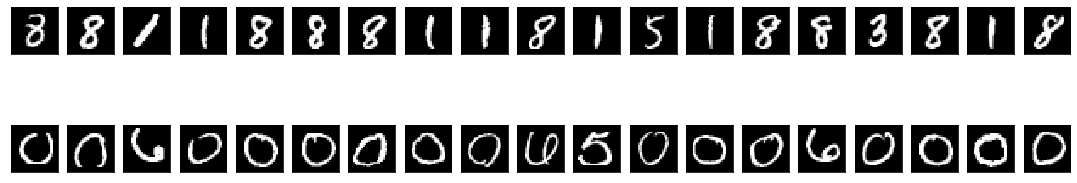

test label = 8 false_img


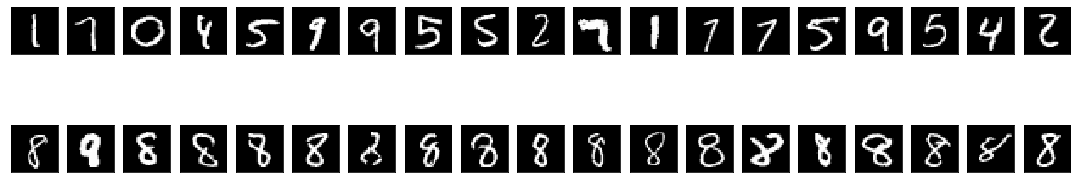

Loading  9
AUC: 0.8966262747554512
confusion_matrix:
[[1403  381]
 [ 935 5014]]


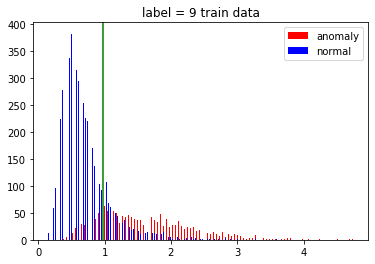

 train label = 9 uncertain_img


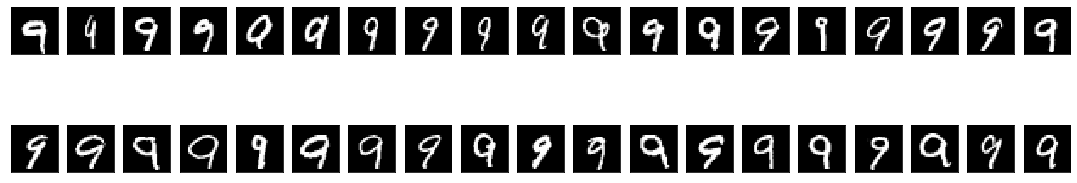

train label = 9 distance oder


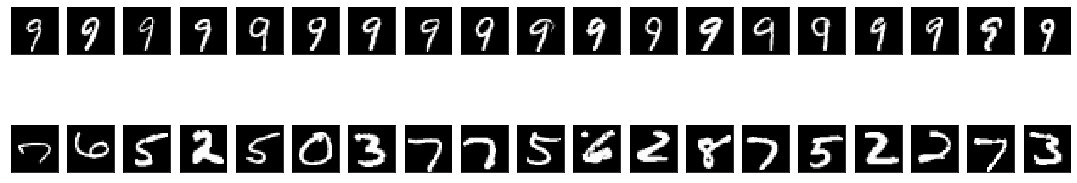

train label = 9 false_img


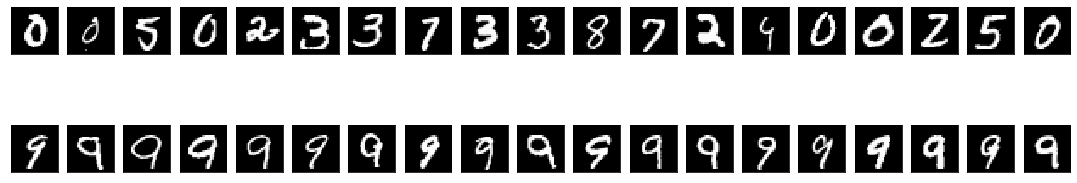

AUC: 0.9052312415928758
confusion_matrix:
[[7165 1826]
 [ 143  866]]


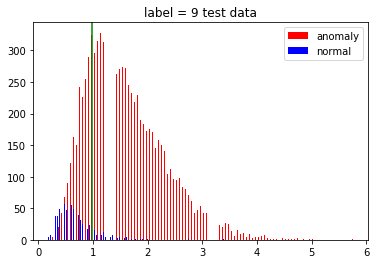

test label = 9 uncertain_img


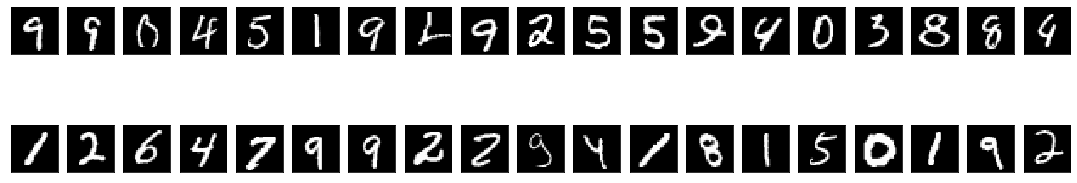

test label = 9 distance oder


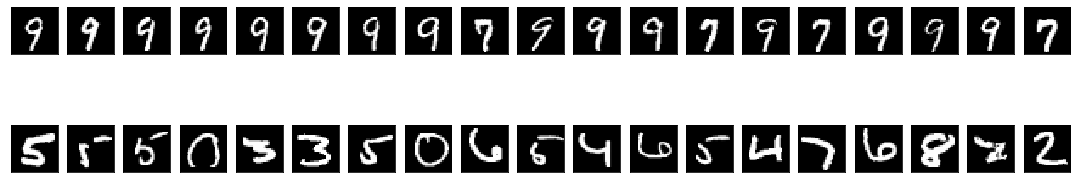

test label = 9 false_img


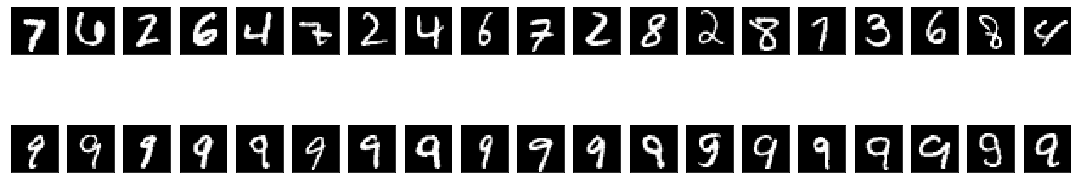

In [36]:
nu = 0.3
outlier_nu = 0.3
lr_milestone = 30
warm_up_n_epochs = 7
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, lr_milestone, train_dataset, warm_up_n_epochs)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test,  load_model = True, show_img = True)
